In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime
import json
# import fitsio
import pandas as pd
import time
import pickle
import re


%reload_ext autoreload
%autoreload 2

In [2]:
import survey_ops
from survey_ops.utils import units, geometry, interpolate
from survey_ops.src.offline_dataset import OfflineDECamDataset
from survey_ops.src.agents import Agent
from survey_ops.src.algorithms import DDQN, BehaviorCloning
from survey_ops.utils.pytorch_utils import seed_everything


In [3]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

# Load and cut data from fits file, save as .json

In [4]:
data_json_fn = '../data/data_w_dith.json'
data_fits_fn = '../data/decam-exposures-20251211_w_dith.fits'

try:
    # --- Load json df ---- #
    df = pd.read_json(data_json_fn)
    print('Loaded data from json')
except:
    # --- Load fits ---- #
    print(data_json_fn, 'DNE. Loading and processing data from fits.')
    d = fitsio.read(data_fits_fn)
    sel = (d['propid'] == '2012B-0001') & (d['exptime'] > 40) & (d['exptime'] < 100) & (~np.isnan(d['teff']))
    selected_d = d[sel]
    column_names = selected_d.dtype.names
    df = pd.DataFrame(selected_d, columns=column_names)
    
    # mask = np.array([False if 'None' in dt else True for dt in subs_data['datetime']])
    # subs_data = {key: subs_data[key][mask] for key in subs_data.keys()}
    
    df.to_json(data_json_fn, indent=2)
    df = pd.read_json(data_json_fn)
    

Loaded data from json


# Instantiate the offline dataset choosing binning method (healpix vs uniform_grid)

In [7]:
binning_method='healpix'
nside=8
bin_space='radec'
specific_years=[2014]
specific_months=[12]
specific_days=[15, 16, 17, 18, 19]
specific_months = None
specific_days=None
include_default_features=True
include_bin_features=False
do_z_score_norm=True
do_cyclical_norm=True

In [8]:
dataset = OfflineDECamDataset(
    df, 
    binning_method=binning_method,
    nside=nside,
    bin_space=bin_space,
    specific_years=specific_years,
    specific_months=specific_months,
    specific_days=specific_days,
    include_default_features=include_default_features,
    include_bin_features=include_bin_features,
    do_z_score_norm=do_z_score_norm,
    do_cyclical_norm=do_cyclical_norm,
)

# Visualize dataset in az, el and ra, dec

(array([1.790e+02, 2.173e+03, 8.502e+03, 4.760e+03, 6.840e+02, 1.400e+02,
        7.100e+01, 2.900e+01, 6.000e+00, 3.000e+00]),
 array([-0.76999998, -0.39199999, -0.014     ,  0.36399996,  0.74199998,
         1.12      ,  1.49799991,  1.87599993,  2.25399995,  2.63199997,
         3.00999999]),
 <BarContainer object of 10 artists>)

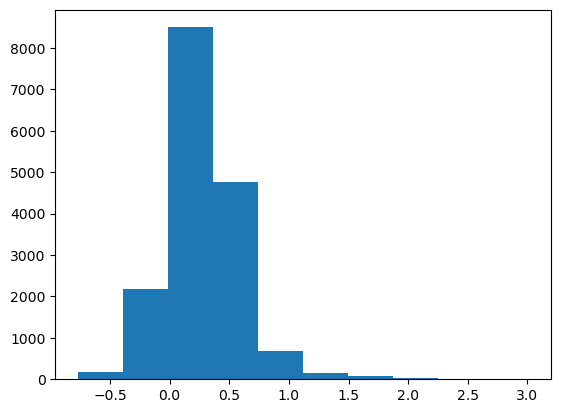

In [14]:
plt.hist(dataset._df['qc_sky'])

In [9]:
obj_names, counts = np.unique(dataset._df.object, return_counts=True)

In [ ]:
plt.hist(counts)
plt.xlabel('Number of visits to a field')
plt.ylabel('Number of fields')

In [ ]:
plt.hist(dataset.n_obs_per_night)
plt.xlabel('Number of observations in a night')

In [ ]:
colors = [f'C{i}' for i in range(7)]
for i, (bin_id, g) in enumerate(dataset._df.groupby('bin')):
    plt.scatter(g.ra, g.dec, label=bin_id, color=colors[i%len(colors)], s=1)

# Train

In [ ]:
batch_size = 1024
num_workers = 4
pin_memory = True if device == 'cuda' else False
trainloader = dataset.get_dataloader(batch_size, num_workers = num_workers, pin_memory = pin_memory)


In [ ]:
dataset.do_z_score_norm

In [ ]:
dataset.do_cyclical_norm

In [ ]:
dataset.next_states.shape

In [ ]:
dataset.num_actions

In [19]:
"""Algorithm and Train setup"""
exp_name_prefix = 'with_bin_info_Zscore_on_Cyclical_on_'

bc_alg_config = {
    'obs_dim': dataset.obs_dim,
    'num_actions': dataset.num_actions,
    'hidden_dim': 4096,
    'device': device,
    'lr': 1e-3,
    'loss_fxn': None, #torch.nn.cross_entropy,
    # 'use_double': True,
}
alg = BehaviorCloning(**bc_alg_config)

# ddqn_alg_config = {
#     'obs_dim': dataset.obs_dim,
#     'num_actions': dataset.num_actions,
#     'hidden_dim': 128,
#     'device': device,
#     'gamma': .95,
#     'tau': 1e-4,
#     'lr': 1e-3,
#     'loss_fxn': None,
#     use_double=True,
# }
# alg = DDQN(**ddqn_alg_config)

fit_config = {
    'num_epochs' : 10,
    'batch_size': batch_size,
    # 'learning_start': 
    }

env_name = 'OfflineEnv'

def create_exp_name(alg, env_name, dataset, fit_config, alg_config, prefix=None):
    if prefix is not None:
        exp_name = prefix
    else:
        exp_name = ''
    exp_name += f"{alg.name}"
    exp_name += f"-{env_name}"
    exp_name += f"-n_nights={dataset.n_nights}"
    # config_prefix += f"-use_double={alg_config['use_double']}"
    exp_name += f"-num_epochs={fit_config['num_epochs']}"
    exp_name += f"-batch_size={fit_config['batch_size']}"
    exp_name += f"-lr={alg_config['lr']}"
    return exp_name

exp_name = create_exp_name(alg, env_name, dataset, fit_config, bc_alg_config, prefix=exp_name_prefix)

outdir = f'../results/{exp_name}/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_outdir = outdir + 'figures/'
if not os.path.exists(fig_outdir):
    os.makedirs(fig_outdir)

agent_config = {
    'algorithm': alg,
    'normalize_obs': True,
    'outdir': outdir
    }

agent = Agent(**agent_config)

# Train

In [20]:
# circle on gif is a 1.1deg radius --> maybe nside = 16 is enough, (nside=32 is about a 3 deg area)

In [21]:
try:
    agent.load(filepath=outdir + 'weights.pt')
except:
    start_time = time.time()
    """Train"""
    agent.fit(
        dataloader=trainloader,
        **fit_config
        )
    end_time = time.time()
    train_time = end_time - start_time
    print(f'Total train time = {train_time}s')

  0%|                                                | 0/165470 [00:00<?, ?it/s]/home/hurra/Projects/survey-ops/survey_ops/src/agents.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eval_obs = torch.tensor(eval_obs, device=self.device)
/home/hurra/Projects/survey-ops/survey_ops/src/agents.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expert_actions = torch.tensor(expert_actions, device=self.device)
  0%|                                      | 8/165470 [00:00<4:11:02, 10.99it/s]

Train step 0: Accuracy = 0.017, Loss = 6.7426, Q-val=0.004


  0%|                                      | 111/165470 [00:02<45:58, 59.95it/s]

Train step 100: Accuracy = 0.163, Loss = 3.1334, Q-val=-8.270


  0%|                                      | 208/165470 [00:04<44:49, 61.46it/s]

Train step 200: Accuracy = 0.196, Loss = 2.8919, Q-val=-9.608


  0%|                                      | 310/165470 [00:06<46:56, 58.65it/s]

Train step 300: Accuracy = 0.263, Loss = 2.6286, Q-val=-11.815


  0%|                                      | 409/165470 [00:07<47:52, 57.47it/s]

Train step 400: Accuracy = 0.323, Loss = 2.3405, Q-val=-12.964


  0%|                                      | 511/165470 [00:09<45:40, 60.20it/s]

Train step 500: Accuracy = 0.363, Loss = 2.0466, Q-val=-14.018


  0%|▏                                     | 607/165470 [00:11<47:20, 58.03it/s]

Train step 600: Accuracy = 0.429, Loss = 1.8961, Q-val=-15.112


  0%|▏                                     | 709/165470 [00:13<46:13, 59.42it/s]

Train step 700: Accuracy = 0.465, Loss = 1.7698, Q-val=-16.153


  0%|▏                                     | 808/165470 [00:14<49:25, 55.53it/s]

Train step 800: Accuracy = 0.467, Loss = 1.6151, Q-val=-16.316


  1%|▏                                     | 909/165470 [00:16<54:52, 49.97it/s]

Train step 900: Accuracy = 0.520, Loss = 1.5509, Q-val=-17.574


  1%|▏                                    | 1008/165470 [00:18<47:06, 58.19it/s]

Train step 1000: Accuracy = 0.489, Loss = 1.4856, Q-val=-17.231


  1%|▏                                    | 1109/165470 [00:20<46:20, 59.11it/s]

Train step 1100: Accuracy = 0.534, Loss = 1.3564, Q-val=-17.731


  1%|▎                                    | 1208/165470 [00:22<49:48, 54.97it/s]

Train step 1200: Accuracy = 0.355, Loss = 1.7213, Q-val=-17.288


  1%|▎                                    | 1310/165470 [00:23<53:59, 50.68it/s]

Train step 1300: Accuracy = 0.533, Loss = 1.2666, Q-val=-18.479


  1%|▎                                    | 1410/165470 [00:25<46:40, 58.58it/s]

Train step 1400: Accuracy = 0.558, Loss = 1.2398, Q-val=-19.061


  1%|▎                                    | 1512/165470 [00:27<46:56, 58.22it/s]

Train step 1500: Accuracy = 0.522, Loss = 1.5562, Q-val=-19.223


  1%|▎                                    | 1609/165470 [00:29<48:00, 56.88it/s]

Train step 1600: Accuracy = 0.589, Loss = 1.2090, Q-val=-19.445


  1%|▍                                    | 1707/165470 [00:30<58:06, 46.97it/s]

Train step 1700: Accuracy = 0.585, Loss = 1.2321, Q-val=-19.814


  1%|▍                                    | 1808/165470 [00:32<46:38, 58.49it/s]

Train step 1800: Accuracy = 0.596, Loss = 1.1960, Q-val=-20.259


  1%|▍                                    | 1907/165470 [00:34<46:21, 58.80it/s]

Train step 1900: Accuracy = 0.597, Loss = 1.1704, Q-val=-20.515


  1%|▍                                    | 2013/165470 [00:36<46:16, 58.87it/s]

Train step 2000: Accuracy = 0.620, Loss = 1.0367, Q-val=-20.277


  1%|▍                                    | 2113/165470 [00:38<51:36, 52.76it/s]

Train step 2100: Accuracy = 0.638, Loss = 0.9817, Q-val=-20.563


  1%|▍                                    | 2212/165470 [00:39<46:38, 58.34it/s]

Train step 2200: Accuracy = 0.615, Loss = 1.0659, Q-val=-20.659


  1%|▌                                    | 2312/165470 [00:41<45:59, 59.14it/s]

Train step 2300: Accuracy = 0.613, Loss = 1.0324, Q-val=-21.183


  1%|▌                                    | 2412/165470 [00:43<47:21, 57.38it/s]

Train step 2400: Accuracy = 0.611, Loss = 1.1293, Q-val=-20.825


  2%|▌                                    | 2512/165470 [00:45<53:50, 50.44it/s]

Train step 2500: Accuracy = 0.631, Loss = 1.0718, Q-val=-20.741


  2%|▌                                    | 2610/165470 [00:47<47:10, 57.55it/s]

Train step 2600: Accuracy = 0.662, Loss = 1.0072, Q-val=-21.643


  2%|▌                                    | 2708/165470 [00:48<46:04, 58.87it/s]

Train step 2700: Accuracy = 0.642, Loss = 0.9640, Q-val=-21.156


  2%|▋                                    | 2807/165470 [00:50<47:06, 57.56it/s]

Train step 2800: Accuracy = 0.632, Loss = 1.0011, Q-val=-21.592


  2%|▋                                    | 2910/165470 [00:52<49:53, 54.30it/s]

Train step 2900: Accuracy = 0.607, Loss = 0.9700, Q-val=-21.865


  2%|▋                                    | 3012/165470 [00:54<51:04, 53.02it/s]

Train step 3000: Accuracy = 0.642, Loss = 1.0838, Q-val=-21.794


  2%|▋                                    | 3108/165470 [00:56<46:40, 57.98it/s]

Train step 3100: Accuracy = 0.640, Loss = 1.0267, Q-val=-21.557


  2%|▋                                    | 3210/165470 [00:58<46:37, 58.00it/s]

Train step 3200: Accuracy = 0.664, Loss = 0.9169, Q-val=-21.509


  2%|▋                                    | 3313/165470 [01:00<48:54, 55.27it/s]

Train step 3300: Accuracy = 0.663, Loss = 0.8806, Q-val=-22.021


  2%|▊                                    | 3411/165470 [01:02<58:44, 45.98it/s]

Train step 3400: Accuracy = 0.652, Loss = 0.9381, Q-val=-22.000


  2%|▊                                    | 3511/165470 [01:03<47:04, 57.33it/s]

Train step 3500: Accuracy = 0.646, Loss = 0.8989, Q-val=-21.907


  2%|▊                                    | 3612/165470 [01:05<46:38, 57.85it/s]

Train step 3600: Accuracy = 0.661, Loss = 0.8952, Q-val=-22.278


  2%|▊                                    | 3710/165470 [01:07<49:25, 54.54it/s]

Train step 3700: Accuracy = 0.646, Loss = 0.8163, Q-val=-22.011


  2%|▊                                    | 3812/165470 [01:09<57:35, 46.79it/s]

Train step 3800: Accuracy = 0.652, Loss = 0.8868, Q-val=-22.172


  2%|▊                                    | 3910/165470 [01:11<46:19, 58.12it/s]

Train step 3900: Accuracy = 0.654, Loss = 0.8813, Q-val=-21.799


  2%|▉                                    | 4008/165470 [01:13<45:37, 58.98it/s]

Train step 4000: Accuracy = 0.657, Loss = 0.8394, Q-val=-22.596


  2%|▉                                    | 4108/165470 [01:15<48:04, 55.94it/s]

Train step 4100: Accuracy = 0.677, Loss = 0.8770, Q-val=-22.704


  3%|▉                                  | 4210/165470 [01:17<1:00:44, 44.25it/s]

Train step 4200: Accuracy = 0.657, Loss = 0.8054, Q-val=-22.628


  3%|▉                                    | 4313/165470 [01:18<45:42, 58.76it/s]

Train step 4300: Accuracy = 0.699, Loss = 0.8224, Q-val=-22.819


  3%|▉                                    | 4409/165470 [01:20<45:26, 59.08it/s]

Train step 4400: Accuracy = 0.668, Loss = 0.8394, Q-val=-22.838


  3%|█                                    | 4512/165470 [01:22<45:59, 58.33it/s]

Train step 4500: Accuracy = 0.655, Loss = 0.8394, Q-val=-22.357


  3%|█                                    | 4610/165470 [01:24<53:28, 50.14it/s]

Train step 4600: Accuracy = 0.679, Loss = 0.7844, Q-val=-23.361


  3%|█                                    | 4708/165470 [01:26<45:18, 59.13it/s]

Train step 4700: Accuracy = 0.691, Loss = 0.7690, Q-val=-22.782


  3%|█                                    | 4807/165470 [01:28<45:54, 58.32it/s]

Train step 4800: Accuracy = 0.718, Loss = 0.7752, Q-val=-23.081


  3%|█                                    | 4908/165470 [01:30<45:58, 58.20it/s]

Train step 4900: Accuracy = 0.697, Loss = 0.7499, Q-val=-23.545


  3%|█                                    | 5012/165470 [01:32<48:28, 55.18it/s]

Train step 5000: Accuracy = 0.630, Loss = 0.8577, Q-val=-23.031


  3%|█▏                                   | 5111/165470 [01:33<50:27, 52.96it/s]

Train step 5100: Accuracy = 0.694, Loss = 0.7718, Q-val=-23.999


  3%|█▏                                   | 5208/165470 [01:35<45:35, 58.59it/s]

Train step 5200: Accuracy = 0.674, Loss = 0.8347, Q-val=-23.906


  3%|█▏                                   | 5309/165470 [01:37<45:35, 58.55it/s]

Train step 5300: Accuracy = 0.719, Loss = 0.7094, Q-val=-23.359


  3%|█▏                                   | 5409/165470 [01:39<48:12, 55.34it/s]

Train step 5400: Accuracy = 0.712, Loss = 0.7847, Q-val=-23.496


  3%|█▏                                   | 5511/165470 [01:41<57:14, 46.57it/s]

Train step 5500: Accuracy = 0.694, Loss = 0.7087, Q-val=-23.819


  3%|█▎                                   | 5606/165470 [01:43<45:48, 58.16it/s]

Train step 5600: Accuracy = 0.696, Loss = 0.7263, Q-val=-23.972


  3%|█▎                                   | 5709/165470 [01:44<45:39, 58.32it/s]

Train step 5700: Accuracy = 0.702, Loss = 0.6834, Q-val=-23.676


  4%|█▎                                   | 5813/165470 [01:47<47:32, 55.96it/s]

Train step 5800: Accuracy = 0.715, Loss = 0.7742, Q-val=-24.224


  4%|█▎                                   | 5911/165470 [01:48<56:55, 46.72it/s]

Train step 5900: Accuracy = 0.730, Loss = 0.7657, Q-val=-24.656


  4%|█▎                                   | 6012/165470 [01:50<44:42, 59.45it/s]

Train step 6000: Accuracy = 0.713, Loss = 0.7463, Q-val=-24.099


  4%|█▎                                   | 6113/165470 [01:52<45:30, 58.37it/s]

Train step 6100: Accuracy = 0.727, Loss = 0.7124, Q-val=-24.891


  4%|█▍                                   | 6209/165470 [01:54<46:58, 56.51it/s]

Train step 6200: Accuracy = 0.699, Loss = 0.7803, Q-val=-24.307


  4%|█▍                                   | 6313/165470 [01:56<53:35, 49.49it/s]

Train step 6300: Accuracy = 0.714, Loss = 0.7225, Q-val=-24.444


  4%|█▍                                   | 6412/165470 [01:58<44:57, 58.97it/s]

Train step 6400: Accuracy = 0.752, Loss = 0.6727, Q-val=-24.677


  4%|█▍                                   | 6512/165470 [01:59<45:36, 58.09it/s]

Train step 6500: Accuracy = 0.721, Loss = 0.6642, Q-val=-24.764


  4%|█▍                                   | 6612/165470 [02:01<45:19, 58.41it/s]

Train step 6600: Accuracy = 0.732, Loss = 0.6978, Q-val=-24.985


  4%|█▌                                   | 6713/165470 [02:03<50:31, 52.37it/s]

Train step 6700: Accuracy = 0.743, Loss = 0.7171, Q-val=-24.480


  4%|█▌                                   | 6803/165470 [02:05<45:51, 57.66it/s]

Train step 6800: Accuracy = 0.720, Loss = 0.6866, Q-val=-25.327


  4%|█▌                                   | 6908/165470 [02:07<44:44, 59.06it/s]

Train step 6900: Accuracy = 0.745, Loss = 0.6784, Q-val=-25.048


  4%|█▌                                   | 7008/165470 [02:09<45:17, 58.31it/s]

Train step 7000: Accuracy = 0.717, Loss = 0.6776, Q-val=-25.266


  4%|█▌                                   | 7110/165470 [02:11<47:27, 55.62it/s]

Train step 7100: Accuracy = 0.726, Loss = 0.6792, Q-val=-25.425


  4%|█▌                                   | 7213/165470 [02:13<47:45, 55.22it/s]

Train step 7200: Accuracy = 0.738, Loss = 0.6604, Q-val=-25.907


  4%|█▋                                   | 7313/165470 [02:14<44:45, 58.88it/s]

Train step 7300: Accuracy = 0.740, Loss = 0.6688, Q-val=-25.537


  4%|█▋                                   | 7411/165470 [02:16<45:57, 57.32it/s]

Train step 7400: Accuracy = 0.757, Loss = 0.6609, Q-val=-26.055


  5%|█▋                                   | 7507/165470 [02:18<47:57, 54.90it/s]

Train step 7500: Accuracy = 0.786, Loss = 0.6129, Q-val=-25.555


  5%|█▋                                   | 7611/165470 [02:20<53:54, 48.81it/s]

Train step 7600: Accuracy = 0.754, Loss = 0.6241, Q-val=-25.502


  5%|█▋                                   | 7706/165470 [02:22<45:20, 58.00it/s]

Train step 7700: Accuracy = 0.745, Loss = 0.6536, Q-val=-26.004


  5%|█▋                                   | 7811/165470 [02:24<45:04, 58.30it/s]

Train step 7800: Accuracy = 0.723, Loss = 0.5802, Q-val=-26.120


  5%|█▊                                   | 7907/165470 [02:26<48:04, 54.63it/s]

Train step 7900: Accuracy = 0.732, Loss = 0.6370, Q-val=-26.242


  5%|█▊                                   | 8010/165470 [02:28<54:24, 48.24it/s]

Train step 8000: Accuracy = 0.746, Loss = 0.6585, Q-val=-26.658


  5%|█▊                                   | 8104/165470 [02:29<45:00, 58.26it/s]

Train step 8100: Accuracy = 0.758, Loss = 0.6148, Q-val=-26.608


  5%|█▊                                   | 8209/165470 [02:31<44:49, 58.48it/s]

Train step 8200: Accuracy = 0.761, Loss = 0.6149, Q-val=-26.755


  5%|█▊                                   | 8310/165470 [02:33<45:29, 57.58it/s]

Train step 8300: Accuracy = 0.757, Loss = 0.5664, Q-val=-26.374


  5%|█▉                                   | 8410/165470 [02:35<53:39, 48.79it/s]

Train step 8400: Accuracy = 0.759, Loss = 0.5152, Q-val=-26.400


  5%|█▉                                   | 8502/165470 [02:37<46:04, 56.78it/s]

Train step 8500: Accuracy = 0.747, Loss = 0.5853, Q-val=-26.354


  5%|█▉                                   | 8613/165470 [02:39<44:52, 58.26it/s]

Train step 8600: Accuracy = 0.765, Loss = 0.5424, Q-val=-26.754


  5%|█▉                                   | 8712/165470 [02:41<44:12, 59.10it/s]

Train step 8700: Accuracy = 0.767, Loss = 0.4996, Q-val=-26.899


  5%|█▉                                   | 8812/165470 [02:43<48:16, 54.09it/s]

Train step 8800: Accuracy = 0.769, Loss = 0.6034, Q-val=-27.010


  5%|█▉                                   | 8904/165470 [02:44<45:19, 57.56it/s]

Train step 8900: Accuracy = 0.780, Loss = 0.5713, Q-val=-27.689


  5%|██                                   | 9008/165470 [02:46<43:51, 59.45it/s]

Train step 9000: Accuracy = 0.750, Loss = 0.5870, Q-val=-27.107


  6%|██                                   | 9108/165470 [02:48<44:25, 58.67it/s]

Train step 9100: Accuracy = 0.762, Loss = 0.6124, Q-val=-26.929


  6%|██                                   | 9209/165470 [02:50<49:19, 52.80it/s]

Train step 9200: Accuracy = 0.799, Loss = 0.5944, Q-val=-27.484


  6%|██                                   | 9312/165470 [02:52<46:44, 55.69it/s]

Train step 9300: Accuracy = 0.784, Loss = 0.5925, Q-val=-27.418


  6%|██                                   | 9411/165470 [02:54<44:37, 58.28it/s]

Train step 9400: Accuracy = 0.793, Loss = 0.5677, Q-val=-27.556


  6%|██▏                                  | 9507/165470 [02:56<44:56, 57.84it/s]

Train step 9500: Accuracy = 0.734, Loss = 0.5743, Q-val=-27.290


  6%|██▏                                  | 9611/165470 [02:58<45:35, 56.98it/s]

Train step 9600: Accuracy = 0.790, Loss = 0.5095, Q-val=-27.900


  6%|██▏                                  | 9711/165470 [02:59<46:42, 55.59it/s]

Train step 9700: Accuracy = 0.775, Loss = 0.5090, Q-val=-28.017


  6%|██▏                                  | 9800/165470 [03:01<43:04, 60.24it/s]

Train step 9800: Accuracy = 0.764, Loss = 0.5497, Q-val=-27.634


  6%|██▏                                  | 9909/165470 [03:03<44:41, 58.01it/s]

Train step 9900: Accuracy = 0.777, Loss = 0.5115, Q-val=-28.385


  6%|██▏                                 | 10011/165470 [03:05<45:48, 56.57it/s]

Train step 10000: Accuracy = 0.792, Loss = 0.5684, Q-val=-28.640


  6%|██▏                                 | 10107/165470 [03:07<54:19, 47.67it/s]

Train step 10100: Accuracy = 0.797, Loss = 0.5046, Q-val=-28.584


  6%|██▏                                 | 10205/165470 [03:09<58:11, 44.46it/s]

Train step 10200: Accuracy = 0.800, Loss = 0.4931, Q-val=-27.602


  6%|██▏                                 | 10312/165470 [03:11<44:53, 57.61it/s]

Train step 10300: Accuracy = 0.778, Loss = 0.5323, Q-val=-28.308


  6%|██▎                                 | 10408/165470 [03:12<45:34, 56.71it/s]

Train step 10400: Accuracy = 0.787, Loss = 0.5262, Q-val=-28.217


  6%|██▎                                 | 10512/165470 [03:14<51:29, 50.16it/s]

Train step 10500: Accuracy = 0.835, Loss = 0.5792, Q-val=-28.262


  6%|██▎                                 | 10603/165470 [03:16<44:43, 57.71it/s]

Train step 10600: Accuracy = 0.784, Loss = 0.5051, Q-val=-28.282


  6%|██▎                                 | 10708/165470 [03:18<43:49, 58.85it/s]

Train step 10700: Accuracy = 0.791, Loss = 0.4982, Q-val=-28.482


  7%|██▎                                 | 10810/165470 [03:20<45:20, 56.85it/s]

Train step 10800: Accuracy = 0.804, Loss = 0.5477, Q-val=-29.688


  7%|██▎                                 | 10910/165470 [03:22<48:25, 53.19it/s]

Train step 10900: Accuracy = 0.783, Loss = 0.5561, Q-val=-29.411


  7%|██▍                                 | 11007/165470 [03:24<54:47, 46.98it/s]

Train step 11000: Accuracy = 0.832, Loss = 0.4875, Q-val=-29.642


  7%|██▍                                 | 11108/165470 [03:25<43:47, 58.76it/s]

Train step 11100: Accuracy = 0.799, Loss = 0.5174, Q-val=-28.967


  7%|██▍                                 | 11210/165470 [03:27<44:50, 57.33it/s]

Train step 11200: Accuracy = 0.831, Loss = 0.4411, Q-val=-29.228


  7%|██▍                                 | 11309/165470 [03:29<48:28, 53.00it/s]

Train step 11300: Accuracy = 0.830, Loss = 0.4905, Q-val=-29.182


  7%|██▍                                 | 11411/165470 [03:31<45:23, 56.56it/s]

Train step 11400: Accuracy = 0.806, Loss = 0.5443, Q-val=-29.226


  7%|██▌                                 | 11508/165470 [03:33<43:41, 58.74it/s]

Train step 11500: Accuracy = 0.809, Loss = 0.4367, Q-val=-29.261


  7%|██▌                                 | 11611/165470 [03:35<43:38, 58.75it/s]

Train step 11600: Accuracy = 0.789, Loss = 0.4275, Q-val=-29.366


  7%|██▌                                 | 11708/165470 [03:37<45:35, 56.22it/s]

Train step 11700: Accuracy = 0.769, Loss = 0.4868, Q-val=-29.682


  7%|██▌                                 | 11805/165470 [03:38<47:11, 54.26it/s]

Train step 11800: Accuracy = 0.818, Loss = 0.3957, Q-val=-29.802


  7%|██▌                                 | 11910/165470 [03:40<52:58, 48.31it/s]

Train step 11900: Accuracy = 0.803, Loss = 0.5613, Q-val=-30.229


  7%|██▌                                 | 12008/165470 [03:42<44:16, 57.76it/s]

Train step 12000: Accuracy = 0.810, Loss = 0.4268, Q-val=-30.225


  7%|██▋                                 | 12107/165470 [03:44<45:01, 56.78it/s]

Train step 12100: Accuracy = 0.826, Loss = 0.4542, Q-val=-29.907


  7%|██▋                                 | 12207/165470 [03:46<51:50, 49.27it/s]

Train step 12200: Accuracy = 0.835, Loss = 0.4541, Q-val=-29.239


  7%|██▋                                 | 12307/165470 [03:48<54:06, 47.17it/s]

Train step 12300: Accuracy = 0.799, Loss = 0.4217, Q-val=-30.679


  7%|██▋                                 | 12409/165470 [03:50<43:17, 58.94it/s]

Train step 12400: Accuracy = 0.800, Loss = 0.4477, Q-val=-30.057


  8%|██▋                                 | 12512/165470 [03:52<43:58, 57.97it/s]

Train step 12500: Accuracy = 0.845, Loss = 0.4114, Q-val=-30.611


  8%|██▋                                 | 12610/165470 [03:54<48:46, 52.24it/s]

Train step 12600: Accuracy = 0.850, Loss = 0.3765, Q-val=-30.782


  8%|██▊                                 | 12702/165470 [03:55<58:47, 43.31it/s]

Train step 12700: Accuracy = 0.839, Loss = 0.4423, Q-val=-30.455


  8%|██▊                                 | 12808/165470 [03:57<43:02, 59.12it/s]

Train step 12800: Accuracy = 0.824, Loss = 0.4499, Q-val=-30.631


  8%|██▊                                 | 12911/165470 [03:59<44:19, 57.37it/s]

Train step 12900: Accuracy = 0.819, Loss = 0.4077, Q-val=-31.363


  8%|██▊                                 | 13010/165470 [04:01<47:54, 53.04it/s]

Train step 13000: Accuracy = 0.824, Loss = 0.4313, Q-val=-30.727


  8%|██▊                                 | 13106/165470 [04:03<54:41, 46.43it/s]

Train step 13100: Accuracy = 0.843, Loss = 0.4467, Q-val=-31.025


  8%|██▊                                 | 13208/165470 [04:05<43:54, 57.79it/s]

Train step 13200: Accuracy = 0.796, Loss = 0.4713, Q-val=-31.014


  8%|██▉                                 | 13310/165470 [04:07<43:34, 58.20it/s]

Train step 13300: Accuracy = 0.828, Loss = 0.3745, Q-val=-31.176


  8%|██▉                                 | 13412/165470 [04:08<46:53, 54.05it/s]

Train step 13400: Accuracy = 0.827, Loss = 0.5017, Q-val=-31.316


  8%|██▉                                 | 13507/165470 [04:10<46:07, 54.91it/s]

Train step 13500: Accuracy = 0.846, Loss = 0.4007, Q-val=-31.446


  8%|██▉                                 | 13607/165470 [04:12<43:35, 58.07it/s]

Train step 13600: Accuracy = 0.838, Loss = 0.3995, Q-val=-32.138


  8%|██▉                                 | 13708/165470 [04:14<43:22, 58.31it/s]

Train step 13700: Accuracy = 0.836, Loss = 0.4860, Q-val=-31.683


  8%|███                                 | 13813/165470 [04:16<43:29, 58.12it/s]

Train step 13800: Accuracy = 0.848, Loss = 0.4302, Q-val=-32.207


  8%|██▊                               | 13906/165470 [04:18<1:00:05, 42.04it/s]

Train step 13900: Accuracy = 0.860, Loss = 0.3800, Q-val=-31.807


  8%|███                                 | 14012/165470 [04:20<50:18, 50.18it/s]

Train step 14000: Accuracy = 0.855, Loss = 0.3591, Q-val=-32.012


  9%|███                                 | 14107/165470 [04:21<43:36, 57.86it/s]

Train step 14100: Accuracy = 0.854, Loss = 0.4127, Q-val=-32.362


  9%|███                                 | 14209/165470 [04:23<44:41, 56.41it/s]

Train step 14200: Accuracy = 0.837, Loss = 0.3750, Q-val=-31.946


  9%|███                                 | 14313/165470 [04:25<47:13, 53.35it/s]

Train step 14300: Accuracy = 0.817, Loss = 0.4091, Q-val=-32.106


  9%|███▏                                | 14410/165470 [04:27<49:56, 50.41it/s]

Train step 14400: Accuracy = 0.814, Loss = 0.4496, Q-val=-32.039


  9%|███▏                                | 14511/165470 [04:29<43:40, 57.61it/s]

Train step 14500: Accuracy = 0.848, Loss = 0.4455, Q-val=-31.944


  9%|███▏                                | 14613/165470 [04:31<43:43, 57.50it/s]

Train step 14600: Accuracy = 0.869, Loss = 0.3913, Q-val=-31.809


  9%|███▏                                | 14713/165470 [04:33<46:23, 54.16it/s]

Train step 14700: Accuracy = 0.841, Loss = 0.4295, Q-val=-32.466


  9%|███▏                                | 14801/165470 [04:35<56:25, 44.50it/s]

Train step 14800: Accuracy = 0.853, Loss = 0.4620, Q-val=-32.756


  9%|███▏                                | 14908/165470 [04:37<42:36, 58.90it/s]

Train step 14900: Accuracy = 0.845, Loss = 0.3789, Q-val=-32.640


  9%|███▎                                | 15008/165470 [04:38<43:59, 57.01it/s]

Train step 15000: Accuracy = 0.867, Loss = 0.3690, Q-val=-33.037


  9%|███▎                                | 15110/165470 [04:40<46:00, 54.47it/s]

Train step 15100: Accuracy = 0.854, Loss = 0.4059, Q-val=-32.803


  9%|███▎                                | 15202/165470 [04:42<53:59, 46.39it/s]

Train step 15200: Accuracy = 0.861, Loss = 0.3128, Q-val=-33.449


  9%|███▎                                | 15307/165470 [04:44<42:17, 59.18it/s]

Train step 15300: Accuracy = 0.842, Loss = 0.4103, Q-val=-32.491


  9%|███▎                                | 15408/165470 [04:46<42:55, 58.26it/s]

Train step 15400: Accuracy = 0.846, Loss = 0.3191, Q-val=-32.506


  9%|███▎                                | 15508/165470 [04:48<45:30, 54.92it/s]

Train step 15500: Accuracy = 0.849, Loss = 0.3729, Q-val=-32.770


  9%|███▍                                | 15605/165470 [04:50<44:44, 55.83it/s]

Train step 15600: Accuracy = 0.867, Loss = 0.3619, Q-val=-32.679


  9%|███▍                                | 15713/165470 [04:52<42:41, 58.45it/s]

Train step 15700: Accuracy = 0.873, Loss = 0.3217, Q-val=-33.977


 10%|███▍                                | 15808/165470 [04:53<42:54, 58.13it/s]

Train step 15800: Accuracy = 0.862, Loss = 0.3819, Q-val=-34.216


 10%|███▍                                | 15907/165470 [04:55<43:20, 57.51it/s]

Train step 15900: Accuracy = 0.859, Loss = 0.3480, Q-val=-33.959


 10%|███▍                                | 16004/165470 [04:57<57:44, 43.14it/s]

Train step 16000: Accuracy = 0.877, Loss = 0.3197, Q-val=-33.233


 10%|███▌                                | 16107/165470 [04:59<51:00, 48.80it/s]

Train step 16100: Accuracy = 0.830, Loss = 0.3594, Q-val=-33.101


 10%|███▌                                | 16211/165470 [05:01<42:43, 58.22it/s]

Train step 16200: Accuracy = 0.876, Loss = 0.3602, Q-val=-33.651


 10%|███▌                                | 16308/165470 [05:03<44:14, 56.19it/s]

Train step 16300: Accuracy = 0.858, Loss = 0.3440, Q-val=-34.161


 10%|███▌                                | 16410/165470 [05:05<47:51, 51.91it/s]

Train step 16400: Accuracy = 0.863, Loss = 0.3365, Q-val=-34.066


 10%|███▌                                | 16509/165470 [05:07<50:07, 49.53it/s]

Train step 16500: Accuracy = 0.880, Loss = 0.3203, Q-val=-33.885


 10%|███▌                                | 16609/165470 [05:09<42:53, 57.85it/s]

Train step 16600: Accuracy = 0.879, Loss = 0.3505, Q-val=-34.402


 10%|███▋                                | 16711/165470 [05:11<42:04, 58.92it/s]

Train step 16700: Accuracy = 0.834, Loss = 0.3627, Q-val=-34.465


 10%|███▋                                | 16809/165470 [05:12<46:16, 53.54it/s]

Train step 16800: Accuracy = 0.875, Loss = 0.3398, Q-val=-34.306


 10%|███▍                              | 16907/165470 [05:14<1:02:38, 39.53it/s]

Train step 16900: Accuracy = 0.837, Loss = 0.4055, Q-val=-34.270


 10%|███▋                                | 17012/165470 [05:16<42:20, 58.44it/s]

Train step 17000: Accuracy = 0.879, Loss = 0.3935, Q-val=-34.796


 10%|███▋                                | 17108/165470 [05:18<42:45, 57.83it/s]

Train step 17100: Accuracy = 0.876, Loss = 0.3491, Q-val=-35.228


 10%|███▋                                | 17213/165470 [05:20<43:34, 56.71it/s]

Train step 17200: Accuracy = 0.887, Loss = 0.3527, Q-val=-34.340


 10%|███▊                                | 17312/165470 [05:22<56:35, 43.63it/s]

Train step 17300: Accuracy = 0.871, Loss = 0.2707, Q-val=-35.069


 11%|███▊                                | 17409/165470 [05:24<42:23, 58.20it/s]

Train step 17400: Accuracy = 0.875, Loss = 0.3139, Q-val=-34.829


 11%|███▊                                | 17508/165470 [05:25<41:46, 59.03it/s]

Train step 17500: Accuracy = 0.862, Loss = 0.3800, Q-val=-34.139


 11%|███▊                                | 17610/165470 [05:27<44:40, 55.15it/s]

Train step 17600: Accuracy = 0.836, Loss = 0.3323, Q-val=-35.224


 11%|███▊                                | 17707/165470 [05:29<55:21, 44.48it/s]

Train step 17700: Accuracy = 0.874, Loss = 0.3308, Q-val=-35.351


 11%|███▊                                | 17809/165470 [05:31<42:25, 58.00it/s]

Train step 17800: Accuracy = 0.853, Loss = 0.3556, Q-val=-34.968


 11%|███▉                                | 17909/165470 [05:33<42:15, 58.19it/s]

Train step 17900: Accuracy = 0.877, Loss = 0.3322, Q-val=-34.374


 11%|███▉                                | 18011/165470 [05:35<42:51, 57.34it/s]

Train step 18000: Accuracy = 0.845, Loss = 0.3528, Q-val=-34.733


 11%|███▉                                | 18110/165470 [05:37<51:40, 47.53it/s]

Train step 18100: Accuracy = 0.857, Loss = 0.3092, Q-val=-35.189


 11%|███▉                                | 18208/165470 [05:39<47:28, 51.70it/s]

Train step 18200: Accuracy = 0.899, Loss = 0.3274, Q-val=-35.719


 11%|███▉                                | 18312/165470 [05:41<42:01, 58.35it/s]

Train step 18300: Accuracy = 0.843, Loss = 0.4094, Q-val=-33.910


 11%|████                                | 18407/165470 [05:42<42:50, 57.22it/s]

Train step 18400: Accuracy = 0.878, Loss = 0.3206, Q-val=-35.882


 11%|████                                | 18512/165470 [05:44<45:11, 54.19it/s]

Train step 18500: Accuracy = 0.896, Loss = 0.3183, Q-val=-35.714


 11%|████                                | 18608/165470 [05:46<46:28, 52.66it/s]

Train step 18600: Accuracy = 0.854, Loss = 0.3366, Q-val=-35.473


 11%|████                                | 18711/165470 [05:48<41:13, 59.32it/s]

Train step 18700: Accuracy = 0.903, Loss = 0.3137, Q-val=-36.905


 11%|████                                | 18813/165470 [05:50<41:59, 58.22it/s]

Train step 18800: Accuracy = 0.844, Loss = 0.2957, Q-val=-36.003


 11%|████                                | 18910/165470 [05:52<44:28, 54.93it/s]

Train step 18900: Accuracy = 0.873, Loss = 0.2960, Q-val=-36.188


 11%|████▏                               | 19007/165470 [05:54<55:51, 43.70it/s]

Train step 19000: Accuracy = 0.882, Loss = 0.3037, Q-val=-35.858


 12%|████▏                               | 19112/165470 [05:56<41:35, 58.65it/s]

Train step 19100: Accuracy = 0.878, Loss = 0.3553, Q-val=-34.821


 12%|████▏                               | 19208/165470 [05:57<42:46, 56.99it/s]

Train step 19200: Accuracy = 0.883, Loss = 0.3673, Q-val=-36.134


 12%|████▏                               | 19313/165470 [05:59<43:33, 55.91it/s]

Train step 19300: Accuracy = 0.877, Loss = 0.3342, Q-val=-36.060


 12%|████▏                               | 19409/165470 [06:01<52:55, 46.00it/s]

Train step 19400: Accuracy = 0.902, Loss = 0.2706, Q-val=-36.524


 12%|████▏                               | 19506/165470 [06:03<41:45, 58.26it/s]

Train step 19500: Accuracy = 0.877, Loss = 0.2532, Q-val=-37.194


 12%|████▎                               | 19610/165470 [06:05<41:24, 58.71it/s]

Train step 19600: Accuracy = 0.882, Loss = 0.2669, Q-val=-36.835


 12%|████▎                               | 19712/165470 [06:07<42:10, 57.60it/s]

Train step 19700: Accuracy = 0.901, Loss = 0.2684, Q-val=-36.858


 12%|████▎                               | 19807/165470 [06:09<51:15, 47.36it/s]

Train step 19800: Accuracy = 0.894, Loss = 0.2432, Q-val=-36.975


 12%|████▎                               | 19907/165470 [06:10<41:32, 58.41it/s]

Train step 19900: Accuracy = 0.855, Loss = 0.2710, Q-val=-36.089


 12%|████▎                               | 20007/165470 [06:12<41:55, 57.83it/s]

Train step 20000: Accuracy = 0.869, Loss = 0.3164, Q-val=-37.321


 12%|████▎                               | 20107/165470 [06:14<42:40, 56.76it/s]

Train step 20100: Accuracy = 0.863, Loss = 0.3902, Q-val=-36.515


 12%|████▍                               | 20208/165470 [06:16<48:06, 50.32it/s]

Train step 20200: Accuracy = 0.908, Loss = 0.2178, Q-val=-37.471


 12%|████▍                               | 20312/165470 [06:18<44:13, 54.70it/s]

Train step 20300: Accuracy = 0.899, Loss = 0.2654, Q-val=-36.546


 12%|████▍                               | 20408/165470 [06:20<42:19, 57.12it/s]

Train step 20400: Accuracy = 0.876, Loss = 0.2663, Q-val=-38.449


 12%|████▍                               | 20509/165470 [06:22<41:30, 58.21it/s]

Train step 20500: Accuracy = 0.882, Loss = 0.3190, Q-val=-37.345


 12%|████▍                               | 20610/165470 [06:24<43:17, 55.77it/s]

Train step 20600: Accuracy = 0.866, Loss = 0.3336, Q-val=-36.904


 13%|████▌                               | 20707/165470 [06:25<46:04, 52.36it/s]

Train step 20700: Accuracy = 0.889, Loss = 0.2756, Q-val=-37.956


 13%|████▌                               | 20803/165470 [06:27<41:47, 57.68it/s]

Train step 20800: Accuracy = 0.884, Loss = 0.2821, Q-val=-37.025


 13%|████▌                               | 20909/165470 [06:29<41:19, 58.30it/s]

Train step 20900: Accuracy = 0.864, Loss = 0.2991, Q-val=-36.770


 13%|████▌                               | 21013/165470 [06:31<42:18, 56.90it/s]

Train step 21000: Accuracy = 0.896, Loss = 0.2584, Q-val=-36.987


 13%|████▌                               | 21111/165470 [06:33<49:28, 48.62it/s]

Train step 21100: Accuracy = 0.923, Loss = 0.2325, Q-val=-37.327


 13%|████▌                               | 21203/165470 [06:35<42:05, 57.13it/s]

Train step 21200: Accuracy = 0.899, Loss = 0.2514, Q-val=-37.059


 13%|████▋                               | 21308/165470 [06:37<41:49, 57.44it/s]

Train step 21300: Accuracy = 0.887, Loss = 0.2441, Q-val=-37.216


 13%|████▋                               | 21407/165470 [06:39<42:29, 56.51it/s]

Train step 21400: Accuracy = 0.896, Loss = 0.3050, Q-val=-37.729


 13%|████▋                               | 21508/165470 [06:41<51:58, 46.16it/s]

Train step 21500: Accuracy = 0.903, Loss = 0.2810, Q-val=-36.821


 13%|████▋                               | 21604/165470 [06:42<41:06, 58.33it/s]

Train step 21600: Accuracy = 0.865, Loss = 0.3037, Q-val=-37.761


 13%|████▋                               | 21707/165470 [06:44<41:15, 58.08it/s]

Train step 21700: Accuracy = 0.898, Loss = 0.2623, Q-val=-37.743


 13%|████▋                               | 21807/165470 [06:46<42:50, 55.89it/s]

Train step 21800: Accuracy = 0.896, Loss = 0.3001, Q-val=-38.170


 13%|████▊                               | 21911/165470 [06:48<47:30, 50.37it/s]

Train step 21900: Accuracy = 0.884, Loss = 0.4122, Q-val=-38.028


 13%|████▊                               | 22006/165470 [06:50<54:20, 44.00it/s]

Train step 22000: Accuracy = 0.901, Loss = 0.2607, Q-val=-37.200


 13%|████▊                               | 22113/165470 [06:52<40:52, 58.45it/s]

Train step 22100: Accuracy = 0.909, Loss = 0.2118, Q-val=-38.612


 13%|████▊                               | 22210/165470 [06:54<41:09, 58.02it/s]

Train step 22200: Accuracy = 0.907, Loss = 0.4330, Q-val=-37.257


 13%|████▊                               | 22308/165470 [06:56<46:39, 51.13it/s]

Train step 22300: Accuracy = 0.882, Loss = 0.3365, Q-val=-37.969


 14%|████▉                               | 22412/165470 [06:57<43:33, 54.74it/s]

Train step 22400: Accuracy = 0.893, Loss = 0.2668, Q-val=-38.477


 14%|████▉                               | 22512/165470 [06:59<40:45, 58.46it/s]

Train step 22500: Accuracy = 0.896, Loss = 0.2718, Q-val=-38.679


 14%|████▉                               | 22610/165470 [07:01<41:00, 58.05it/s]

Train step 22600: Accuracy = 0.911, Loss = 0.2163, Q-val=-38.178


 14%|████▉                               | 22708/165470 [07:03<42:17, 56.27it/s]

Train step 22700: Accuracy = 0.878, Loss = 0.3423, Q-val=-39.513


 14%|████▉                               | 22811/165470 [07:05<43:18, 54.91it/s]

Train step 22800: Accuracy = 0.904, Loss = 0.3077, Q-val=-38.406


 14%|████▉                               | 22902/165470 [07:07<42:00, 56.57it/s]

Train step 22900: Accuracy = 0.911, Loss = 0.2659, Q-val=-39.101


 14%|█████                               | 23007/165470 [07:09<41:07, 57.72it/s]

Train step 23000: Accuracy = 0.906, Loss = 0.2774, Q-val=-38.984


 14%|█████                               | 23108/165470 [07:11<42:33, 55.76it/s]

Train step 23100: Accuracy = 0.894, Loss = 0.2855, Q-val=-39.080


 14%|█████                               | 23209/165470 [07:13<48:57, 48.42it/s]

Train step 23200: Accuracy = 0.902, Loss = 0.3344, Q-val=-38.431


 14%|█████                               | 23305/165470 [07:14<53:18, 44.44it/s]

Train step 23300: Accuracy = 0.933, Loss = 0.2211, Q-val=-40.178


 14%|█████                               | 23408/165470 [07:16<40:07, 59.01it/s]

Train step 23400: Accuracy = 0.905, Loss = 0.3113, Q-val=-40.069


 14%|█████                               | 23507/165470 [07:18<42:40, 55.44it/s]

Train step 23500: Accuracy = 0.920, Loss = 0.2961, Q-val=-39.230


 14%|█████▏                              | 23611/165470 [07:20<47:40, 49.59it/s]

Train step 23600: Accuracy = 0.913, Loss = 0.2513, Q-val=-39.450


 14%|█████▏                              | 23701/165470 [07:22<41:03, 57.54it/s]

Train step 23700: Accuracy = 0.926, Loss = 0.1920, Q-val=-38.823


 14%|█████▏                              | 23812/165470 [07:24<39:46, 59.35it/s]

Train step 23800: Accuracy = 0.886, Loss = 0.2643, Q-val=-39.916


 14%|█████▏                              | 23908/165470 [07:26<41:16, 57.17it/s]

Train step 23900: Accuracy = 0.887, Loss = 0.3959, Q-val=-39.357


 15%|█████▏                              | 24010/165470 [07:28<45:23, 51.94it/s]

Train step 24000: Accuracy = 0.897, Loss = 0.3010, Q-val=-39.288


 15%|█████▏                              | 24110/165470 [07:29<48:54, 48.16it/s]

Train step 24100: Accuracy = 0.918, Loss = 0.2197, Q-val=-40.421


 15%|█████▎                              | 24209/165470 [07:31<40:44, 57.79it/s]

Train step 24200: Accuracy = 0.911, Loss = 0.3436, Q-val=-40.500


 15%|█████▎                              | 24312/165470 [07:33<40:11, 58.54it/s]

Train step 24300: Accuracy = 0.900, Loss = 0.2314, Q-val=-39.359


 15%|█████▎                              | 24410/165470 [07:35<44:32, 52.78it/s]

Train step 24400: Accuracy = 0.903, Loss = 0.2906, Q-val=-39.854


 15%|█████▎                              | 24507/165470 [07:37<42:55, 54.73it/s]

Train step 24500: Accuracy = 0.905, Loss = 0.1912, Q-val=-40.023


 15%|█████▎                              | 24610/165470 [07:39<40:26, 58.05it/s]

Train step 24600: Accuracy = 0.911, Loss = 0.2267, Q-val=-39.854


 15%|█████▍                              | 24713/165470 [07:41<40:00, 58.64it/s]

Train step 24700: Accuracy = 0.883, Loss = 0.2724, Q-val=-39.530


 15%|█████▍                              | 24808/165470 [07:43<41:43, 56.17it/s]

Train step 24800: Accuracy = 0.886, Loss = 0.3761, Q-val=-40.121


 15%|█████▍                              | 24908/165470 [07:44<43:19, 54.07it/s]

Train step 24900: Accuracy = 0.865, Loss = 0.2704, Q-val=-40.084


 15%|█████▍                              | 25012/165470 [07:46<50:41, 46.19it/s]

Train step 25000: Accuracy = 0.890, Loss = 0.3195, Q-val=-40.599


 15%|█████▍                              | 25111/165470 [07:48<41:25, 56.46it/s]

Train step 25100: Accuracy = 0.867, Loss = 0.3184, Q-val=-39.105


 15%|█████▍                              | 25212/165470 [07:50<41:16, 56.63it/s]

Train step 25200: Accuracy = 0.911, Loss = 0.2650, Q-val=-39.752


 15%|█████▌                              | 25308/165470 [07:52<47:01, 49.67it/s]

Train step 25300: Accuracy = 0.930, Loss = 0.1920, Q-val=-40.107


 15%|█████▌                              | 25410/165470 [07:54<50:09, 46.54it/s]

Train step 25400: Accuracy = 0.925, Loss = 0.1832, Q-val=-41.002


 15%|█████▌                              | 25510/165470 [07:56<39:43, 58.73it/s]

Train step 25500: Accuracy = 0.910, Loss = 0.2004, Q-val=-40.583


 15%|█████▌                              | 25612/165470 [07:58<40:56, 56.93it/s]

Train step 25600: Accuracy = 0.921, Loss = 0.2065, Q-val=-40.255


 16%|█████▌                              | 25708/165470 [07:59<46:04, 50.55it/s]

Train step 25700: Accuracy = 0.896, Loss = 0.2395, Q-val=-39.943


 16%|█████▌                              | 25800/165470 [08:01<38:46, 60.03it/s]

Train step 25800: Accuracy = 0.909, Loss = 0.2248, Q-val=-40.603


 16%|█████▋                              | 25907/165470 [08:03<40:00, 58.15it/s]

Train step 25900: Accuracy = 0.891, Loss = 0.3049, Q-val=-40.278


 16%|█████▋                              | 26007/165470 [08:05<40:38, 57.18it/s]

Train step 26000: Accuracy = 0.915, Loss = 0.2506, Q-val=-40.567


 16%|█████▋                              | 26108/165470 [08:07<43:06, 53.88it/s]

Train step 26100: Accuracy = 0.902, Loss = 0.3061, Q-val=-41.230


 16%|█████▋                              | 26203/165470 [08:09<52:34, 44.14it/s]

Train step 26200: Accuracy = 0.917, Loss = 0.3001, Q-val=-40.605


 16%|█████▋                              | 26311/165470 [08:11<40:00, 57.96it/s]

Train step 26300: Accuracy = 0.904, Loss = 0.2437, Q-val=-41.011


 16%|█████▋                              | 26411/165470 [08:13<39:12, 59.10it/s]

Train step 26400: Accuracy = 0.905, Loss = 0.2970, Q-val=-40.661


 16%|█████▊                              | 26509/165470 [08:14<43:45, 52.92it/s]

Train step 26500: Accuracy = 0.928, Loss = 0.1995, Q-val=-41.572


 16%|█████▊                              | 26605/165470 [08:16<42:06, 54.96it/s]

Train step 26600: Accuracy = 0.917, Loss = 0.2586, Q-val=-41.438


 16%|█████▊                              | 26707/165470 [08:18<40:08, 57.60it/s]

Train step 26700: Accuracy = 0.916, Loss = 0.2285, Q-val=-40.958


 16%|█████▊                              | 26813/165470 [08:20<39:30, 58.49it/s]

Train step 26800: Accuracy = 0.845, Loss = 0.2775, Q-val=-40.897


 16%|█████▊                              | 26908/165470 [08:22<40:33, 56.93it/s]

Train step 26900: Accuracy = 0.914, Loss = 0.2366, Q-val=-41.194


 16%|█████▊                              | 27003/165470 [08:24<42:02, 54.90it/s]

Train step 27000: Accuracy = 0.865, Loss = 0.3225, Q-val=-41.227


 16%|█████▉                              | 27108/165470 [08:26<49:44, 46.36it/s]

Train step 27100: Accuracy = 0.917, Loss = 0.2182, Q-val=-41.129


 16%|█████▉                              | 27207/165470 [08:27<39:53, 57.77it/s]

Train step 27200: Accuracy = 0.921, Loss = 0.2584, Q-val=-41.310


 17%|█████▉                              | 27308/165470 [08:29<40:08, 57.37it/s]

Train step 27300: Accuracy = 0.846, Loss = 0.2546, Q-val=-40.603


 17%|█████▉                              | 27408/165470 [08:31<44:46, 51.39it/s]

Train step 27400: Accuracy = 0.929, Loss = 0.1822, Q-val=-41.259


 17%|█████▉                              | 27509/165470 [08:33<46:11, 49.77it/s]

Train step 27500: Accuracy = 0.927, Loss = 0.1463, Q-val=-41.563


 17%|██████                              | 27612/165470 [08:35<39:00, 58.89it/s]

Train step 27600: Accuracy = 0.891, Loss = 0.2411, Q-val=-42.322


 17%|██████                              | 27709/165470 [08:37<40:11, 57.12it/s]

Train step 27700: Accuracy = 0.904, Loss = 0.2870, Q-val=-41.657


 17%|██████                              | 27808/165470 [08:39<44:59, 51.00it/s]

Train step 27800: Accuracy = 0.938, Loss = 0.2176, Q-val=-41.263


 17%|██████                              | 27899/165470 [08:41<49:18, 46.50it/s]

Train step 27900: Accuracy = 0.913, Loss = 0.2441, Q-val=-40.844


 17%|██████                              | 28007/165470 [08:43<39:00, 58.73it/s]

Train step 28000: Accuracy = 0.884, Loss = 0.3241, Q-val=-42.011


 17%|██████                              | 28112/165470 [08:45<39:23, 58.11it/s]

Train step 28100: Accuracy = 0.907, Loss = 0.2909, Q-val=-43.186


 17%|██████▏                             | 28208/165470 [08:47<44:43, 51.14it/s]

Train step 28200: Accuracy = 0.931, Loss = 0.2646, Q-val=-42.058


 17%|█████▊                            | 28306/165470 [08:49<1:12:09, 31.68it/s]

Train step 28300: Accuracy = 0.943, Loss = 0.1916, Q-val=-42.520


 17%|██████▏                             | 28409/165470 [08:50<39:24, 57.97it/s]

Train step 28400: Accuracy = 0.927, Loss = 0.2506, Q-val=-41.868


 17%|██████▏                             | 28511/165470 [08:52<39:50, 57.29it/s]

Train step 28500: Accuracy = 0.894, Loss = 0.2660, Q-val=-42.183


 17%|██████▏                             | 28612/165470 [08:54<41:00, 55.63it/s]

Train step 28600: Accuracy = 0.896, Loss = 0.2289, Q-val=-41.561


 17%|█████▉                            | 28706/165470 [08:56<1:02:59, 36.19it/s]

Train step 28700: Accuracy = 0.926, Loss = 0.2629, Q-val=-43.615


 17%|██████▎                             | 28812/165470 [08:58<39:13, 58.07it/s]

Train step 28800: Accuracy = 0.925, Loss = 0.2395, Q-val=-42.508


 17%|██████▎                             | 28911/165470 [09:00<39:14, 57.99it/s]

Train step 28900: Accuracy = 0.931, Loss = 0.2397, Q-val=-42.932


 18%|██████▎                             | 29008/165470 [09:02<39:48, 57.13it/s]

Train step 29000: Accuracy = 0.937, Loss = 0.2226, Q-val=-42.660


 18%|██████▎                             | 29101/165470 [09:04<41:48, 54.37it/s]

Train step 29100: Accuracy = 0.918, Loss = 0.2252, Q-val=-42.726


 18%|██████▎                             | 29208/165470 [09:06<44:35, 50.92it/s]

Train step 29200: Accuracy = 0.917, Loss = 0.2123, Q-val=-41.831


 18%|██████▍                             | 29313/165470 [09:08<38:38, 58.74it/s]

Train step 29300: Accuracy = 0.890, Loss = 0.2192, Q-val=-42.313


 18%|██████▍                             | 29409/165470 [09:10<40:13, 56.38it/s]

Train step 29400: Accuracy = 0.912, Loss = 0.2416, Q-val=-43.015


 18%|██████▍                             | 29512/165470 [09:12<42:34, 53.22it/s]

Train step 29500: Accuracy = 0.886, Loss = 0.2540, Q-val=-43.067


 18%|██████▍                             | 29608/165470 [09:13<46:21, 48.84it/s]

Train step 29600: Accuracy = 0.883, Loss = 0.2899, Q-val=-42.678


 18%|██████▍                             | 29709/165470 [09:15<38:43, 58.43it/s]

Train step 29700: Accuracy = 0.917, Loss = 0.2236, Q-val=-42.443


 18%|██████▍                             | 29808/165470 [09:17<39:59, 56.53it/s]

Train step 29800: Accuracy = 0.927, Loss = 0.2640, Q-val=-42.226


 18%|██████▌                             | 29910/165470 [09:19<43:17, 52.18it/s]

Train step 29900: Accuracy = 0.929, Loss = 0.2404, Q-val=-43.243


 18%|██████▌                             | 30012/165470 [09:21<51:53, 43.51it/s]

Train step 30000: Accuracy = 0.917, Loss = 0.2067, Q-val=-44.169


 18%|██████▌                             | 30111/165470 [09:23<38:30, 58.58it/s]

Train step 30100: Accuracy = 0.914, Loss = 0.1690, Q-val=-42.279


 18%|██████▌                             | 30209/165470 [09:25<38:29, 58.57it/s]

Train step 30200: Accuracy = 0.911, Loss = 0.2101, Q-val=-43.375


 18%|██████▌                             | 30311/165470 [09:27<42:28, 53.04it/s]

Train step 30300: Accuracy = 0.933, Loss = 0.1931, Q-val=-43.184


 18%|██████▌                             | 30408/165470 [09:29<59:09, 38.05it/s]

Train step 30400: Accuracy = 0.931, Loss = 0.2371, Q-val=-42.735


 18%|██████▋                             | 30511/165470 [09:31<38:09, 58.96it/s]

Train step 30500: Accuracy = 0.917, Loss = 0.1789, Q-val=-43.475


 19%|██████▋                             | 30612/165470 [09:33<38:58, 57.67it/s]

Train step 30600: Accuracy = 0.926, Loss = 0.1776, Q-val=-44.265


 19%|██████▋                             | 30709/165470 [09:34<40:03, 56.07it/s]

Train step 30700: Accuracy = 0.912, Loss = 0.2681, Q-val=-42.931


 19%|██████▋                             | 30809/165470 [09:36<52:52, 42.45it/s]

Train step 30800: Accuracy = 0.884, Loss = 0.2669, Q-val=-43.742


 19%|██████▋                             | 30913/165470 [09:38<38:00, 59.00it/s]

Train step 30900: Accuracy = 0.911, Loss = 0.2222, Q-val=-42.013


 19%|██████▋                             | 31009/165470 [09:40<38:57, 57.52it/s]

Train step 31000: Accuracy = 0.938, Loss = 0.1857, Q-val=-43.754


 19%|██████▊                             | 31108/165470 [09:42<38:49, 57.68it/s]

Train step 31100: Accuracy = 0.907, Loss = 0.1878, Q-val=-44.768


 19%|██████▊                             | 31208/165470 [09:44<47:03, 47.54it/s]

Train step 31200: Accuracy = 0.907, Loss = 0.2178, Q-val=-44.214


 19%|██████▊                             | 31312/165470 [09:46<41:52, 53.40it/s]

Train step 31300: Accuracy = 0.926, Loss = 0.2103, Q-val=-43.686


 19%|██████▊                             | 31407/165470 [09:48<38:17, 58.35it/s]

Train step 31400: Accuracy = 0.935, Loss = 0.1624, Q-val=-42.872


 19%|██████▊                             | 31508/165470 [09:50<38:38, 57.77it/s]

Train step 31500: Accuracy = 0.910, Loss = 0.3363, Q-val=-42.321


 19%|██████▉                             | 31610/165470 [09:52<41:22, 53.93it/s]

Train step 31600: Accuracy = 0.946, Loss = 0.2948, Q-val=-43.936


 19%|██████▉                             | 31710/165470 [09:53<43:51, 50.83it/s]

Train step 31700: Accuracy = 0.898, Loss = 0.2269, Q-val=-43.821


 19%|██████▉                             | 31811/165470 [09:55<38:05, 58.49it/s]

Train step 31800: Accuracy = 0.949, Loss = 0.1799, Q-val=-44.202


 19%|██████▉                             | 31909/165470 [09:57<38:09, 58.33it/s]

Train step 31900: Accuracy = 0.921, Loss = 0.1748, Q-val=-44.980


 19%|██████▉                             | 32007/165470 [09:59<42:54, 51.83it/s]

Train step 32000: Accuracy = 0.906, Loss = 0.2408, Q-val=-44.299


 19%|██████▉                             | 32112/165470 [10:01<48:03, 46.25it/s]

Train step 32100: Accuracy = 0.924, Loss = 0.2207, Q-val=-43.310


 19%|███████                             | 32212/165470 [10:03<37:43, 58.88it/s]

Train step 32200: Accuracy = 0.947, Loss = 0.3367, Q-val=-45.099


 20%|███████                             | 32310/165470 [10:05<38:18, 57.94it/s]

Train step 32300: Accuracy = 0.941, Loss = 0.1664, Q-val=-44.703


 20%|███████                             | 32408/165470 [10:07<40:37, 54.59it/s]

Train step 32400: Accuracy = 0.929, Loss = 0.1911, Q-val=-43.906


 20%|███████                             | 32511/165470 [10:09<51:58, 42.63it/s]

Train step 32500: Accuracy = 0.939, Loss = 0.1859, Q-val=-44.157


 20%|███████                             | 32610/165470 [10:11<37:52, 58.46it/s]

Train step 32600: Accuracy = 0.937, Loss = 0.2327, Q-val=-45.626


 20%|███████                             | 32709/165470 [10:13<37:52, 58.43it/s]

Train step 32700: Accuracy = 0.920, Loss = 0.2096, Q-val=-45.548


 20%|███████▏                            | 32812/165470 [10:15<39:36, 55.83it/s]

Train step 32800: Accuracy = 0.927, Loss = 0.2671, Q-val=-42.690


 20%|███████▏                            | 32907/165470 [10:17<51:17, 43.07it/s]

Train step 32900: Accuracy = 0.911, Loss = 0.1908, Q-val=-44.028


 20%|███████▏                            | 33008/165470 [10:18<37:52, 58.29it/s]

Train step 33000: Accuracy = 0.882, Loss = 0.2654, Q-val=-43.195


 20%|███████▏                            | 33112/165470 [10:20<37:33, 58.73it/s]

Train step 33100: Accuracy = 0.947, Loss = 0.1520, Q-val=-43.793


 20%|███████▏                            | 33208/165470 [10:22<38:52, 56.70it/s]

Train step 33200: Accuracy = 0.926, Loss = 0.2335, Q-val=-44.510


 20%|███████▏                            | 33313/165470 [10:24<42:00, 52.44it/s]

Train step 33300: Accuracy = 0.904, Loss = 0.1972, Q-val=-44.812


 20%|███████▎                            | 33409/165470 [10:26<41:53, 52.53it/s]

Train step 33400: Accuracy = 0.896, Loss = 0.4561, Q-val=-51.692


 20%|███████▎                            | 33509/165470 [10:28<37:35, 58.51it/s]

Train step 33500: Accuracy = 0.928, Loss = 0.1629, Q-val=-50.861


 20%|███████▎                            | 33610/165470 [10:30<38:25, 57.20it/s]

Train step 33600: Accuracy = 0.929, Loss = 0.1674, Q-val=-53.521


 20%|███████▎                            | 33710/165470 [10:32<40:30, 54.21it/s]

Train step 33700: Accuracy = 0.903, Loss = 0.1783, Q-val=-52.098


 20%|███████▎                            | 33807/165470 [10:34<43:02, 50.98it/s]

Train step 33800: Accuracy = 0.938, Loss = 0.1637, Q-val=-52.653


 20%|███████▍                            | 33906/165470 [10:36<37:45, 58.09it/s]

Train step 33900: Accuracy = 0.940, Loss = 0.1981, Q-val=-53.174


 21%|███████▍                            | 34011/165470 [10:38<37:44, 58.05it/s]

Train step 34000: Accuracy = 0.928, Loss = 0.1915, Q-val=-51.549


 21%|███████▍                            | 34109/165470 [10:40<41:01, 53.37it/s]

Train step 34100: Accuracy = 0.920, Loss = 0.2095, Q-val=-53.950


 21%|███████▍                            | 34213/165470 [10:42<45:00, 48.61it/s]

Train step 34200: Accuracy = 0.940, Loss = 0.1828, Q-val=-54.125


 21%|███████▍                            | 34308/165470 [10:44<37:23, 58.47it/s]

Train step 34300: Accuracy = 0.919, Loss = 0.1605, Q-val=-53.265


 21%|███████▍                            | 34408/165470 [10:46<38:19, 56.99it/s]

Train step 34400: Accuracy = 0.901, Loss = 0.2455, Q-val=-53.378


 21%|███████▌                            | 34508/165470 [10:48<41:41, 52.36it/s]

Train step 34500: Accuracy = 0.928, Loss = 0.2630, Q-val=-52.474


 21%|███████▌                            | 34611/165470 [10:50<53:24, 40.84it/s]

Train step 34600: Accuracy = 0.932, Loss = 0.1803, Q-val=-52.913


 21%|███████▌                            | 34705/165470 [10:52<38:45, 56.24it/s]

Train step 34700: Accuracy = 0.951, Loss = 0.1477, Q-val=-53.119


 21%|███████▌                            | 34812/165470 [10:54<37:52, 57.49it/s]

Train step 34800: Accuracy = 0.954, Loss = 0.1749, Q-val=-54.520


 21%|███████▌                            | 34912/165470 [10:56<39:46, 54.71it/s]

Train step 34900: Accuracy = 0.951, Loss = 0.2067, Q-val=-53.183


 21%|███████▌                            | 35010/165470 [10:58<55:19, 39.30it/s]

Train step 35000: Accuracy = 0.914, Loss = 0.2479, Q-val=-51.851


 21%|███████▋                            | 35105/165470 [11:00<38:34, 56.33it/s]

Train step 35100: Accuracy = 0.928, Loss = 0.2023, Q-val=-51.915


 21%|███████▋                            | 35208/165470 [11:02<37:29, 57.90it/s]

Train step 35200: Accuracy = 0.935, Loss = 0.2006, Q-val=-53.752


 21%|███████▋                            | 35308/165470 [11:04<39:44, 54.58it/s]

Train step 35300: Accuracy = 0.938, Loss = 0.2297, Q-val=-52.610


 21%|███████▋                            | 35401/165470 [11:06<46:48, 46.31it/s]

Train step 35400: Accuracy = 0.930, Loss = 0.1714, Q-val=-53.589


 21%|███████▋                            | 35508/165470 [11:08<39:57, 54.21it/s]

Train step 35500: Accuracy = 0.949, Loss = 0.1447, Q-val=-54.384


 22%|███████▋                            | 35611/165470 [11:10<37:33, 57.64it/s]

Train step 35600: Accuracy = 0.951, Loss = 0.1219, Q-val=-54.677


 22%|███████▊                            | 35707/165470 [11:12<39:57, 54.13it/s]

Train step 35700: Accuracy = 0.947, Loss = 0.1604, Q-val=-53.697


 22%|███████▊                            | 35806/165470 [11:14<50:32, 42.75it/s]

Train step 35800: Accuracy = 0.909, Loss = 0.2462, Q-val=-55.208


 22%|███████▊                            | 35910/165470 [11:16<40:24, 53.43it/s]

Train step 35900: Accuracy = 0.892, Loss = 0.5248, Q-val=-50.642


 22%|███████▊                            | 36003/165470 [11:18<37:57, 56.85it/s]

Train step 36000: Accuracy = 0.890, Loss = 0.2919, Q-val=-50.982


 22%|███████▊                            | 36107/165470 [11:20<38:08, 56.53it/s]

Train step 36100: Accuracy = 0.938, Loss = 0.2051, Q-val=-52.930


 22%|███████▉                            | 36208/165470 [11:22<46:21, 46.47it/s]

Train step 36200: Accuracy = 0.960, Loss = 0.1223, Q-val=-53.439


 22%|███████▉                            | 36309/165470 [11:24<45:27, 47.36it/s]

Train step 36300: Accuracy = 0.951, Loss = 0.1185, Q-val=-55.043


 22%|███████▉                            | 36404/165470 [11:26<37:43, 57.02it/s]

Train step 36400: Accuracy = 0.948, Loss = 0.1029, Q-val=-54.160


 22%|███████▉                            | 36508/165470 [11:28<37:40, 57.06it/s]

Train step 36500: Accuracy = 0.916, Loss = 0.1240, Q-val=-54.628


 22%|███████▉                            | 36610/165470 [11:30<40:03, 53.62it/s]

Train step 36600: Accuracy = 0.933, Loss = 0.2543, Q-val=-53.140


 22%|███████▉                            | 36710/165470 [11:32<45:37, 47.04it/s]

Train step 36700: Accuracy = 0.925, Loss = 0.2629, Q-val=-54.278


 22%|████████                            | 36804/165470 [11:34<37:30, 57.17it/s]

Train step 36800: Accuracy = 0.945, Loss = 0.1592, Q-val=-52.323


 22%|████████                            | 36908/165470 [11:36<37:20, 57.38it/s]

Train step 36900: Accuracy = 0.888, Loss = 0.2116, Q-val=-52.586


 22%|████████                            | 37012/165470 [11:38<38:43, 55.28it/s]

Train step 37000: Accuracy = 0.880, Loss = 0.3151, Q-val=-51.548


 22%|████████                            | 37109/165470 [11:40<50:41, 42.20it/s]

Train step 37100: Accuracy = 0.908, Loss = 0.2493, Q-val=-52.617


 22%|████████                            | 37206/165470 [11:42<49:01, 43.60it/s]

Train step 37200: Accuracy = 0.953, Loss = 0.1521, Q-val=-52.824


 23%|████████                            | 37309/165470 [11:44<36:59, 57.75it/s]

Train step 37300: Accuracy = 0.954, Loss = 0.1487, Q-val=-54.298


 23%|████████▏                           | 37408/165470 [11:46<39:18, 54.29it/s]

Train step 37400: Accuracy = 0.947, Loss = 0.1407, Q-val=-55.558


 23%|████████▏                           | 37513/165470 [11:48<44:19, 48.11it/s]

Train step 37500: Accuracy = 0.950, Loss = 0.2208, Q-val=-54.170


 23%|████████▏                           | 37605/165470 [11:50<49:46, 42.81it/s]

Train step 37600: Accuracy = 0.942, Loss = 0.2352, Q-val=-54.741


 23%|████████▏                           | 37710/165470 [11:52<36:29, 58.35it/s]

Train step 37700: Accuracy = 0.905, Loss = 0.3450, Q-val=-55.055


 23%|████████▏                           | 37812/165470 [11:54<38:16, 55.60it/s]

Train step 37800: Accuracy = 0.925, Loss = 0.2607, Q-val=-54.280


 23%|████████▏                           | 37910/165470 [11:56<45:25, 46.80it/s]

Train step 37900: Accuracy = 0.928, Loss = 0.2725, Q-val=-52.969


 23%|████████▎                           | 38007/165470 [11:58<39:24, 53.90it/s]

Train step 38000: Accuracy = 0.960, Loss = 0.1740, Q-val=-55.963


 23%|████████▎                           | 38106/165470 [12:00<47:16, 44.91it/s]

Train step 38100: Accuracy = 0.928, Loss = 0.1882, Q-val=-53.909


 23%|████████▎                           | 38213/165470 [12:02<36:19, 58.39it/s]

Train step 38200: Accuracy = 0.917, Loss = 0.1950, Q-val=-54.517


 23%|████████▎                           | 38309/165470 [12:04<43:39, 48.55it/s]

Train step 38300: Accuracy = 0.925, Loss = 0.1604, Q-val=-53.184


 23%|████████▎                           | 38408/165470 [12:06<39:03, 54.22it/s]

Train step 38400: Accuracy = 0.956, Loss = 0.1500, Q-val=-54.678


 23%|████████▍                           | 38504/165470 [12:08<46:37, 45.39it/s]

Train step 38500: Accuracy = 0.950, Loss = 0.1670, Q-val=-54.717


 23%|████████▍                           | 38608/165470 [12:10<36:46, 57.48it/s]

Train step 38600: Accuracy = 0.923, Loss = 0.3044, Q-val=-54.387


 23%|████████▍                           | 38710/165470 [12:12<43:21, 48.73it/s]

Train step 38700: Accuracy = 0.907, Loss = 0.2048, Q-val=-52.696


 23%|████████▍                           | 38812/165470 [12:14<44:08, 47.82it/s]

Train step 38800: Accuracy = 0.932, Loss = 0.2116, Q-val=-52.600


 24%|████████▍                           | 38902/165470 [12:16<36:07, 58.40it/s]

Train step 38900: Accuracy = 0.926, Loss = 0.2479, Q-val=-53.441


 24%|████████▍                           | 39007/165470 [12:18<36:28, 57.79it/s]

Train step 39000: Accuracy = 0.930, Loss = 0.1661, Q-val=-53.550


 24%|████████▌                           | 39113/165470 [12:20<38:12, 55.12it/s]

Train step 39100: Accuracy = 0.947, Loss = 0.1403, Q-val=-55.938


 24%|████████▌                           | 39210/165470 [12:22<41:33, 50.63it/s]

Train step 39200: Accuracy = 0.950, Loss = 0.1384, Q-val=-54.179


 24%|████████▌                           | 39305/165470 [12:24<56:41, 37.09it/s]

Train step 39300: Accuracy = 0.929, Loss = 0.2700, Q-val=-53.094


 24%|████████▌                           | 39410/165470 [12:26<37:25, 56.14it/s]

Train step 39400: Accuracy = 0.928, Loss = 0.1962, Q-val=-54.463


 24%|████████▌                           | 39511/165470 [12:28<38:51, 54.03it/s]

Train step 39500: Accuracy = 0.917, Loss = 0.2868, Q-val=-54.345


 24%|████████▌                           | 39610/165470 [12:30<48:23, 43.34it/s]

Train step 39600: Accuracy = 0.943, Loss = 0.1565, Q-val=-54.720


 24%|████████▋                           | 39709/165470 [12:32<44:38, 46.96it/s]

Train step 39700: Accuracy = 0.952, Loss = 0.1395, Q-val=-55.165


 24%|████████▋                           | 39809/165470 [12:34<36:23, 57.56it/s]

Train step 39800: Accuracy = 0.954, Loss = 0.1127, Q-val=-54.693


 24%|████████▋                           | 39911/165470 [12:36<38:06, 54.90it/s]

Train step 39900: Accuracy = 0.956, Loss = 0.1406, Q-val=-55.312


 24%|████████▋                           | 40010/165470 [12:38<45:09, 46.31it/s]

Train step 40000: Accuracy = 0.948, Loss = 0.1548, Q-val=-55.833


 24%|████████▋                           | 40108/165470 [12:40<37:41, 55.43it/s]

Train step 40100: Accuracy = 0.809, Loss = 1.0928, Q-val=-55.380


 24%|████████▋                           | 40207/165470 [12:42<43:03, 48.49it/s]

Train step 40200: Accuracy = 0.903, Loss = 0.3749, Q-val=-55.127


 24%|████████▊                           | 40309/165470 [12:44<37:02, 56.31it/s]

Train step 40300: Accuracy = 0.954, Loss = 0.1310, Q-val=-53.468


 24%|████████▊                           | 40410/165470 [12:46<43:05, 48.37it/s]

Train step 40400: Accuracy = 0.966, Loss = 0.1003, Q-val=-53.787


 24%|████████▊                           | 40508/165470 [12:48<38:36, 53.94it/s]

Train step 40500: Accuracy = 0.945, Loss = 0.2240, Q-val=-54.696


 25%|████████▊                           | 40613/165470 [12:50<41:13, 50.49it/s]

Train step 40600: Accuracy = 0.956, Loss = 0.1352, Q-val=-54.568


 25%|████████▊                           | 40711/165470 [12:52<36:09, 57.51it/s]

Train step 40700: Accuracy = 0.947, Loss = 0.1485, Q-val=-54.270


 25%|████████▉                           | 40810/165470 [12:54<42:20, 49.08it/s]

Train step 40800: Accuracy = 0.929, Loss = 0.2440, Q-val=-53.928


 25%|████████▉                           | 40907/165470 [12:56<42:49, 48.48it/s]

Train step 40900: Accuracy = 0.939, Loss = 0.1659, Q-val=-54.371


 25%|████████▉                           | 41008/165470 [12:58<43:44, 47.43it/s]

Train step 41000: Accuracy = 0.941, Loss = 0.1941, Q-val=-54.282


 25%|████████▉                           | 41108/165470 [13:00<35:56, 57.66it/s]

Train step 41100: Accuracy = 0.942, Loss = 0.2018, Q-val=-56.277


 25%|████████▉                           | 41207/165470 [13:02<37:55, 54.60it/s]

Train step 41200: Accuracy = 0.937, Loss = 0.1555, Q-val=-55.629


 25%|████████▉                           | 41308/165470 [13:04<40:21, 51.28it/s]

Train step 41300: Accuracy = 0.942, Loss = 0.1540, Q-val=-56.192


 25%|█████████                           | 41409/165470 [13:06<48:21, 42.75it/s]

Train step 41400: Accuracy = 0.915, Loss = 0.2672, Q-val=-53.259


 25%|█████████                           | 41510/165470 [13:08<35:30, 58.18it/s]

Train step 41500: Accuracy = 0.909, Loss = 0.3491, Q-val=-52.844


 25%|█████████                           | 41607/165470 [13:10<37:54, 54.45it/s]

Train step 41600: Accuracy = 0.937, Loss = 0.1286, Q-val=-55.463


 25%|█████████                           | 41711/165470 [13:12<42:57, 48.02it/s]

Train step 41700: Accuracy = 0.950, Loss = 0.1706, Q-val=-55.229


 25%|█████████                           | 41810/165470 [13:14<40:59, 50.27it/s]

Train step 41800: Accuracy = 0.958, Loss = 0.1667, Q-val=-55.616


 25%|█████████                           | 41909/165470 [13:15<35:51, 57.42it/s]

Train step 41900: Accuracy = 0.862, Loss = 0.5172, Q-val=-55.941


 25%|█████████▏                          | 42008/165470 [13:18<37:01, 55.57it/s]

Train step 42000: Accuracy = 0.945, Loss = 0.1535, Q-val=-53.603


 25%|█████████▏                          | 42112/165470 [13:20<41:55, 49.04it/s]

Train step 42100: Accuracy = 0.971, Loss = 0.1308, Q-val=-56.094


 26%|█████████▏                          | 42205/165470 [13:21<37:22, 54.96it/s]

Train step 42200: Accuracy = 0.953, Loss = 0.1190, Q-val=-55.776


 26%|█████████▏                          | 42307/165470 [13:23<43:16, 47.44it/s]

Train step 42300: Accuracy = 0.930, Loss = 0.1200, Q-val=-54.060


 26%|█████████▏                          | 42407/165470 [13:25<36:35, 56.04it/s]

Train step 42400: Accuracy = 0.877, Loss = 0.3344, Q-val=-53.532


 26%|█████████▏                          | 42510/165470 [13:28<41:29, 49.40it/s]

Train step 42500: Accuracy = 0.951, Loss = 0.1307, Q-val=-53.797


 26%|█████████▎                          | 42601/165470 [13:29<38:06, 53.74it/s]

Train step 42600: Accuracy = 0.961, Loss = 0.1221, Q-val=-56.241


 26%|█████████▎                          | 42707/165470 [13:31<43:42, 46.82it/s]

Train step 42700: Accuracy = 0.961, Loss = 0.1407, Q-val=-56.155


 26%|█████████▎                          | 42807/165470 [13:33<35:35, 57.44it/s]

Train step 42800: Accuracy = 0.943, Loss = 0.1671, Q-val=-57.316


 26%|█████████▎                          | 42912/165470 [13:36<39:24, 51.82it/s]

Train step 42900: Accuracy = 0.922, Loss = 0.2248, Q-val=-54.858


 26%|█████████▎                          | 43009/165470 [13:37<40:53, 49.91it/s]

Train step 43000: Accuracy = 0.907, Loss = 0.2627, Q-val=-55.842


 26%|█████████▍                          | 43106/165470 [13:39<44:23, 45.95it/s]

Train step 43100: Accuracy = 0.933, Loss = 0.1336, Q-val=-55.437


 26%|█████████▍                          | 43210/165470 [13:41<35:23, 57.58it/s]

Train step 43200: Accuracy = 0.967, Loss = 0.1129, Q-val=-56.780


 26%|█████████▍                          | 43308/165470 [13:43<36:50, 55.25it/s]

Train step 43300: Accuracy = 0.957, Loss = 0.1243, Q-val=-55.576


 26%|█████████▍                          | 43408/165470 [13:45<39:12, 51.89it/s]

Train step 43400: Accuracy = 0.955, Loss = 0.1105, Q-val=-56.099


 26%|█████████▍                          | 43499/165470 [13:47<45:12, 44.96it/s]

Train step 43500: Accuracy = 0.941, Loss = 0.1681, Q-val=-55.745


 26%|█████████▍                          | 43611/165470 [13:49<35:03, 57.94it/s]

Train step 43600: Accuracy = 0.928, Loss = 0.3131, Q-val=-58.367


 26%|█████████▌                          | 43708/165470 [13:51<36:55, 54.96it/s]

Train step 43700: Accuracy = 0.940, Loss = 0.2025, Q-val=-56.798


 26%|█████████▌                          | 43807/165470 [13:53<43:12, 46.93it/s]

Train step 43800: Accuracy = 0.952, Loss = 0.1185, Q-val=-56.684


 27%|█████████▌                          | 43905/165470 [13:55<40:35, 49.92it/s]

Train step 43900: Accuracy = 0.940, Loss = 0.1691, Q-val=-56.199


 27%|█████████▌                          | 44009/165470 [13:57<34:40, 58.37it/s]

Train step 44000: Accuracy = 0.910, Loss = 0.2813, Q-val=-54.854


 27%|█████████▌                          | 44108/165470 [13:59<36:25, 55.52it/s]

Train step 44100: Accuracy = 0.925, Loss = 0.1913, Q-val=-56.221


 27%|█████████▌                          | 44208/165470 [14:01<40:37, 49.74it/s]

Train step 44200: Accuracy = 0.938, Loss = 0.1675, Q-val=-55.405


 27%|█████████▋                          | 44304/165470 [14:03<36:51, 54.78it/s]

Train step 44300: Accuracy = 0.958, Loss = 0.1434, Q-val=-56.297


 27%|█████████▋                          | 44408/165470 [14:05<33:59, 59.37it/s]

Train step 44400: Accuracy = 0.953, Loss = 0.1204, Q-val=-55.335


 27%|█████████▋                          | 44510/165470 [14:07<35:52, 56.18it/s]

Train step 44500: Accuracy = 0.930, Loss = 0.1513, Q-val=-56.610


 27%|█████████▋                          | 44608/165470 [14:09<40:07, 50.19it/s]

Train step 44600: Accuracy = 0.945, Loss = 0.3172, Q-val=-56.071


 27%|█████████▋                          | 44702/165470 [14:11<36:53, 54.56it/s]

Train step 44700: Accuracy = 0.954, Loss = 0.1602, Q-val=-56.747


 27%|█████████▋                          | 44811/165470 [14:13<38:36, 52.08it/s]

Train step 44800: Accuracy = 0.931, Loss = 0.2709, Q-val=-56.287


 27%|█████████▊                          | 44909/165470 [14:15<35:01, 57.36it/s]

Train step 44900: Accuracy = 0.944, Loss = 0.1616, Q-val=-56.416


 27%|█████████▊                          | 45011/165470 [14:17<38:11, 52.56it/s]

Train step 45000: Accuracy = 0.956, Loss = 0.1723, Q-val=-54.932


 27%|█████████▊                          | 45111/165470 [14:19<38:10, 52.55it/s]

Train step 45100: Accuracy = 0.941, Loss = 0.1455, Q-val=-55.978


 27%|█████████▊                          | 45210/165470 [14:21<40:00, 50.09it/s]

Train step 45200: Accuracy = 0.960, Loss = 0.1107, Q-val=-57.643


 27%|█████████▊                          | 45310/165470 [14:23<34:45, 57.63it/s]

Train step 45300: Accuracy = 0.895, Loss = 0.3083, Q-val=-57.778


 27%|█████████▉                          | 45412/165470 [14:25<35:21, 56.58it/s]

Train step 45400: Accuracy = 0.945, Loss = 0.1716, Q-val=-54.288


 28%|█████████▉                          | 45506/165470 [14:26<38:26, 52.00it/s]

Train step 45500: Accuracy = 0.947, Loss = 0.1434, Q-val=-57.034


 28%|█████████▉                          | 45609/165470 [14:29<48:21, 41.30it/s]

Train step 45600: Accuracy = 0.940, Loss = 0.1556, Q-val=-56.942


 28%|█████████▉                          | 45709/165470 [14:30<33:56, 58.81it/s]

Train step 45700: Accuracy = 0.943, Loss = 0.1800, Q-val=-56.759


 28%|█████████▉                          | 45812/165470 [14:32<36:22, 54.82it/s]

Train step 45800: Accuracy = 0.943, Loss = 0.1688, Q-val=-56.724


 28%|█████████▉                          | 45909/165470 [14:35<39:55, 49.91it/s]

Train step 45900: Accuracy = 0.942, Loss = 0.1687, Q-val=-57.262


 28%|██████████                          | 46001/165470 [14:36<40:18, 49.39it/s]

Train step 46000: Accuracy = 0.944, Loss = 0.1943, Q-val=-57.579


 28%|██████████                          | 46109/165470 [14:38<34:20, 57.93it/s]

Train step 46100: Accuracy = 0.950, Loss = 0.1219, Q-val=-58.764


 28%|██████████                          | 46209/165470 [14:40<35:03, 56.70it/s]

Train step 46200: Accuracy = 0.908, Loss = 0.2546, Q-val=-58.950


 28%|██████████                          | 46312/165470 [14:42<38:11, 51.99it/s]

Train step 46300: Accuracy = 0.940, Loss = 0.2481, Q-val=-56.589


 28%|██████████                          | 46405/165470 [14:44<45:44, 43.38it/s]

Train step 46400: Accuracy = 0.973, Loss = 0.0839, Q-val=-58.773


 28%|██████████                          | 46512/165470 [14:46<34:10, 58.02it/s]

Train step 46500: Accuracy = 0.961, Loss = 0.0927, Q-val=-56.116


 28%|██████████▏                         | 46612/165470 [14:48<34:27, 57.50it/s]

Train step 46600: Accuracy = 0.955, Loss = 0.0986, Q-val=-58.497


 28%|██████████▏                         | 46711/165470 [14:50<37:30, 52.77it/s]

Train step 46700: Accuracy = 0.919, Loss = 0.1684, Q-val=-57.292


 28%|██████████▏                         | 46806/165470 [14:52<43:44, 45.22it/s]

Train step 46800: Accuracy = 0.923, Loss = 0.3381, Q-val=-55.000


 28%|██████████▏                         | 46913/165470 [14:54<37:29, 52.71it/s]

Train step 46900: Accuracy = 0.942, Loss = 0.1874, Q-val=-58.384


 28%|██████████▏                         | 47009/165470 [14:56<34:03, 57.96it/s]

Train step 47000: Accuracy = 0.943, Loss = 0.1270, Q-val=-56.446


 28%|██████████▏                         | 47108/165470 [14:58<37:11, 53.05it/s]

Train step 47100: Accuracy = 0.928, Loss = 0.1766, Q-val=-57.257


 29%|██████████▎                         | 47208/165470 [15:00<37:00, 53.26it/s]

Train step 47200: Accuracy = 0.962, Loss = 0.1747, Q-val=-58.607


 29%|██████████▎                         | 47308/165470 [15:02<37:47, 52.10it/s]

Train step 47300: Accuracy = 0.951, Loss = 0.1877, Q-val=-57.644


 29%|██████████▎                         | 47410/165470 [15:04<34:27, 57.11it/s]

Train step 47400: Accuracy = 0.936, Loss = 0.1456, Q-val=-57.296


 29%|██████████▎                         | 47508/165470 [15:06<34:35, 56.84it/s]

Train step 47500: Accuracy = 0.959, Loss = 0.1264, Q-val=-58.331


 29%|██████████▎                         | 47604/165470 [15:08<37:34, 52.28it/s]

Train step 47600: Accuracy = 0.947, Loss = 0.1477, Q-val=-56.863


 29%|██████████▍                         | 47709/165470 [15:10<44:12, 44.40it/s]

Train step 47700: Accuracy = 0.940, Loss = 0.1768, Q-val=-58.501


 29%|██████████▍                         | 47812/165470 [15:12<34:15, 57.25it/s]

Train step 47800: Accuracy = 0.927, Loss = 0.2099, Q-val=-57.538


 29%|██████████▍                         | 47912/165470 [15:14<34:03, 57.52it/s]

Train step 47900: Accuracy = 0.939, Loss = 0.1624, Q-val=-56.386


 29%|██████████▍                         | 48010/165470 [15:16<38:27, 50.91it/s]

Train step 48000: Accuracy = 0.954, Loss = 0.1424, Q-val=-58.569


 29%|██████████▍                         | 48109/165470 [15:18<43:45, 44.70it/s]

Train step 48100: Accuracy = 0.932, Loss = 0.1504, Q-val=-56.548


 29%|██████████▍                         | 48208/165470 [15:19<33:57, 57.55it/s]

Train step 48200: Accuracy = 0.943, Loss = 0.1110, Q-val=-56.995


 29%|██████████▌                         | 48307/165470 [15:22<34:36, 56.44it/s]

Train step 48300: Accuracy = 0.930, Loss = 0.2148, Q-val=-56.919


 29%|██████████▌                         | 48410/165470 [15:24<37:10, 52.47it/s]

Train step 48400: Accuracy = 0.898, Loss = 0.2705, Q-val=-57.451


 29%|██████████▌                         | 48503/165470 [15:26<58:11, 33.50it/s]

Train step 48500: Accuracy = 0.941, Loss = 0.1597, Q-val=-57.709


 29%|██████████▌                         | 48605/165470 [15:27<33:33, 58.04it/s]

Train step 48600: Accuracy = 0.944, Loss = 0.1256, Q-val=-57.289


 29%|██████████▌                         | 48708/165470 [15:29<34:11, 56.93it/s]

Train step 48700: Accuracy = 0.961, Loss = 0.0723, Q-val=-57.858


 29%|██████████▌                         | 48808/165470 [15:31<36:17, 53.58it/s]

Train step 48800: Accuracy = 0.971, Loss = 0.1505, Q-val=-58.733


 30%|██████████▋                         | 48905/165470 [15:33<41:27, 46.85it/s]

Train step 48900: Accuracy = 0.927, Loss = 0.2445, Q-val=-58.006


 30%|██████████▋                         | 49009/165470 [15:35<36:21, 53.40it/s]

Train step 49000: Accuracy = 0.917, Loss = 0.2217, Q-val=-57.542


 30%|██████████▋                         | 49108/165470 [15:37<33:32, 57.81it/s]

Train step 49100: Accuracy = 0.964, Loss = 0.1625, Q-val=-57.378


 30%|██████████▋                         | 49210/165470 [15:39<35:56, 53.90it/s]

Train step 49200: Accuracy = 0.942, Loss = 0.1621, Q-val=-58.129


 30%|██████████▋                         | 49307/165470 [15:41<44:58, 43.04it/s]

Train step 49300: Accuracy = 0.964, Loss = 0.1146, Q-val=-58.440


 30%|██████████▋                         | 49409/165470 [15:43<36:34, 52.88it/s]

Train step 49400: Accuracy = 0.953, Loss = 0.2069, Q-val=-58.779


 30%|██████████▊                         | 49508/165470 [15:45<33:45, 57.26it/s]

Train step 49500: Accuracy = 0.910, Loss = 0.2058, Q-val=-57.552


 30%|██████████▊                         | 49610/165470 [15:47<33:27, 57.73it/s]

Train step 49600: Accuracy = 0.924, Loss = 0.2456, Q-val=-56.179


 30%|██████████▊                         | 49701/165470 [15:49<36:15, 53.22it/s]

Train step 49700: Accuracy = 0.935, Loss = 0.2021, Q-val=-57.964


 30%|██████████▊                         | 49807/165470 [15:51<42:57, 44.87it/s]

Train step 49800: Accuracy = 0.936, Loss = 0.1262, Q-val=-57.894


 30%|██████████▊                         | 49908/165470 [15:53<33:31, 57.46it/s]

Train step 49900: Accuracy = 0.969, Loss = 0.0672, Q-val=-59.496


 30%|██████████▉                         | 50009/165470 [15:55<33:19, 57.76it/s]

Train step 50000: Accuracy = 0.962, Loss = 0.1176, Q-val=-61.231


 30%|██████████▉                         | 50108/165470 [15:57<36:08, 53.19it/s]

Train step 50100: Accuracy = 0.942, Loss = 0.1385, Q-val=-57.813


 30%|██████████▉                         | 50211/165470 [15:59<39:57, 48.07it/s]

Train step 50200: Accuracy = 0.905, Loss = 0.2566, Q-val=-57.029


 30%|██████████▉                         | 50305/165470 [16:01<34:19, 55.91it/s]

Train step 50300: Accuracy = 0.937, Loss = 0.1961, Q-val=-56.495


 30%|██████████▉                         | 50411/165470 [16:03<33:01, 58.06it/s]

Train step 50400: Accuracy = 0.959, Loss = 0.1787, Q-val=-57.678


 31%|██████████▉                         | 50513/165470 [16:05<34:52, 54.94it/s]

Train step 50500: Accuracy = 0.947, Loss = 0.1346, Q-val=-60.164


 31%|███████████                         | 50613/165470 [16:07<43:36, 43.90it/s]

Train step 50600: Accuracy = 0.913, Loss = 0.2418, Q-val=-57.812


 31%|███████████                         | 50703/165470 [16:09<32:50, 58.24it/s]

Train step 50700: Accuracy = 0.959, Loss = 0.1033, Q-val=-57.851


 31%|███████████                         | 50807/165470 [16:11<33:19, 57.35it/s]

Train step 50800: Accuracy = 0.905, Loss = 0.2154, Q-val=-58.507


 31%|███████████                         | 50911/165470 [16:13<34:45, 54.93it/s]

Train step 50900: Accuracy = 0.960, Loss = 0.1399, Q-val=-57.522


 31%|███████████                         | 51006/165470 [16:15<48:24, 39.41it/s]

Train step 51000: Accuracy = 0.968, Loss = 0.1047, Q-val=-60.086


 31%|███████████                         | 51111/165470 [16:17<35:16, 54.04it/s]

Train step 51100: Accuracy = 0.949, Loss = 0.1029, Q-val=-59.553


 31%|███████████▏                        | 51211/165470 [16:19<32:46, 58.09it/s]

Train step 51200: Accuracy = 0.958, Loss = 0.1353, Q-val=-61.557


 31%|███████████▏                        | 51310/165470 [16:21<34:57, 54.42it/s]

Train step 51300: Accuracy = 0.895, Loss = 0.3941, Q-val=-59.036


 31%|███████████▏                        | 51404/165470 [16:23<45:01, 42.23it/s]

Train step 51400: Accuracy = 0.938, Loss = 0.2547, Q-val=-60.362


 31%|███████████▏                        | 51513/165470 [16:24<34:25, 55.18it/s]

Train step 51500: Accuracy = 0.936, Loss = 0.1614, Q-val=-58.806


 31%|███████████▏                        | 51604/165470 [16:26<33:17, 57.01it/s]

Train step 51600: Accuracy = 0.940, Loss = 0.1082, Q-val=-59.162


 31%|███████████▏                        | 51709/165470 [16:28<33:14, 57.05it/s]

Train step 51700: Accuracy = 0.956, Loss = 0.1584, Q-val=-60.857


 31%|███████████▎                        | 51812/165470 [16:30<38:43, 48.92it/s]

Train step 51800: Accuracy = 0.954, Loss = 0.1278, Q-val=-58.916


 31%|███████████▎                        | 51909/165470 [16:32<39:53, 47.44it/s]

Train step 51900: Accuracy = 0.952, Loss = 0.1509, Q-val=-58.461


 31%|███████████▎                        | 52001/165470 [16:34<32:37, 57.97it/s]

Train step 52000: Accuracy = 0.935, Loss = 0.2165, Q-val=-58.438


 31%|███████████▎                        | 52108/165470 [16:36<32:58, 57.29it/s]

Train step 52100: Accuracy = 0.960, Loss = 0.1834, Q-val=-59.798


 32%|███████████▎                        | 52213/165470 [16:38<34:08, 55.29it/s]

Train step 52200: Accuracy = 0.956, Loss = 0.1208, Q-val=-59.341


 32%|███████████▍                        | 52309/165470 [16:40<38:28, 49.01it/s]

Train step 52300: Accuracy = 0.923, Loss = 0.2814, Q-val=-57.528


 32%|███████████▍                        | 52405/165470 [16:42<42:33, 44.27it/s]

Train step 52400: Accuracy = 0.948, Loss = 0.1590, Q-val=-60.251


 32%|███████████▍                        | 52509/165470 [16:44<32:15, 58.38it/s]

Train step 52500: Accuracy = 0.908, Loss = 0.2443, Q-val=-58.648


 32%|███████████▍                        | 52610/165470 [16:46<35:07, 53.55it/s]

Train step 52600: Accuracy = 0.961, Loss = 0.1529, Q-val=-57.780


 32%|███████████▍                        | 52708/165470 [16:48<42:27, 44.26it/s]

Train step 52700: Accuracy = 0.966, Loss = 0.1480, Q-val=-60.141


 32%|███████████▍                        | 52812/165470 [16:50<39:52, 47.09it/s]

Train step 52800: Accuracy = 0.965, Loss = 0.1263, Q-val=-59.492


 32%|███████████▌                        | 52910/165470 [16:52<32:54, 57.02it/s]

Train step 52900: Accuracy = 0.951, Loss = 0.1137, Q-val=-60.248


 32%|███████████▌                        | 53009/165470 [16:54<34:09, 54.88it/s]

Train step 53000: Accuracy = 0.875, Loss = 0.7739, Q-val=-60.149


 32%|███████████▌                        | 53112/165470 [16:56<39:34, 47.32it/s]

Train step 53100: Accuracy = 0.944, Loss = 0.1928, Q-val=-58.213


 32%|███████████▌                        | 53210/165470 [16:58<34:40, 53.96it/s]

Train step 53200: Accuracy = 0.945, Loss = 0.1898, Q-val=-60.880


 32%|███████████▌                        | 53309/165470 [17:00<32:09, 58.14it/s]

Train step 53300: Accuracy = 0.961, Loss = 0.1392, Q-val=-59.673


 32%|███████████▌                        | 53410/165470 [17:02<33:23, 55.93it/s]

Train step 53400: Accuracy = 0.947, Loss = 0.1344, Q-val=-59.976


 32%|███████████▋                        | 53510/165470 [17:04<37:53, 49.24it/s]

Train step 53500: Accuracy = 0.953, Loss = 0.1853, Q-val=-61.774


 32%|███████████▋                        | 53608/165470 [17:06<33:35, 55.51it/s]

Train step 53600: Accuracy = 0.958, Loss = 0.1804, Q-val=-60.897


 32%|███████████▋                        | 53707/165470 [17:08<40:05, 46.47it/s]

Train step 53700: Accuracy = 0.940, Loss = 0.1587, Q-val=-60.487


 33%|███████████▋                        | 53807/165470 [17:10<32:32, 57.20it/s]

Train step 53800: Accuracy = 0.937, Loss = 0.1879, Q-val=-59.796


 33%|███████████▋                        | 53912/165470 [17:12<36:09, 51.42it/s]

Train step 53900: Accuracy = 0.958, Loss = 0.1445, Q-val=-60.719


 33%|███████████▋                        | 54007/165470 [17:14<38:50, 47.82it/s]

Train step 54000: Accuracy = 0.963, Loss = 0.1695, Q-val=-59.477


 33%|███████████▊                        | 54109/165470 [17:15<39:40, 46.77it/s]

Train step 54100: Accuracy = 0.947, Loss = 0.1742, Q-val=-60.027


 33%|███████████▊                        | 54209/165470 [17:17<31:54, 58.11it/s]

Train step 54200: Accuracy = 0.952, Loss = 0.1541, Q-val=-60.013


 33%|███████████▊                        | 54307/165470 [17:19<34:04, 54.38it/s]

Train step 54300: Accuracy = 0.947, Loss = 0.1052, Q-val=-60.633


 33%|███████████▊                        | 54407/165470 [17:21<36:30, 50.70it/s]

Train step 54400: Accuracy = 0.926, Loss = 0.2642, Q-val=-60.196


 33%|███████████▊                        | 54502/165470 [17:23<41:15, 44.83it/s]

Train step 54500: Accuracy = 0.943, Loss = 0.1091, Q-val=-61.162


 33%|███████████▉                        | 54608/165470 [17:25<32:01, 57.68it/s]

Train step 54600: Accuracy = 0.931, Loss = 0.1377, Q-val=-61.632


 33%|███████████▉                        | 54709/165470 [17:27<33:03, 55.84it/s]

Train step 54700: Accuracy = 0.944, Loss = 0.1183, Q-val=-60.412


 33%|███████████▉                        | 54810/165470 [17:29<39:58, 46.14it/s]

Train step 54800: Accuracy = 0.950, Loss = 0.1328, Q-val=-59.157


 33%|███████████▉                        | 54908/165470 [17:31<39:14, 46.96it/s]

Train step 54900: Accuracy = 0.936, Loss = 0.1722, Q-val=-61.821


 33%|███████████▉                        | 55011/165470 [17:33<31:30, 58.43it/s]

Train step 55000: Accuracy = 0.952, Loss = 0.1795, Q-val=-60.702


 33%|███████████▉                        | 55110/165470 [17:35<33:03, 55.63it/s]

Train step 55100: Accuracy = 0.932, Loss = 0.1805, Q-val=-58.186


 33%|████████████                        | 55211/165470 [17:37<38:29, 47.75it/s]

Train step 55200: Accuracy = 0.960, Loss = 0.1519, Q-val=-59.869


 33%|████████████                        | 55306/165470 [17:39<33:52, 54.20it/s]

Train step 55300: Accuracy = 0.961, Loss = 0.1358, Q-val=-60.181


 33%|████████████                        | 55412/165470 [17:41<31:21, 58.49it/s]

Train step 55400: Accuracy = 0.938, Loss = 0.1724, Q-val=-59.097


 34%|████████████                        | 55510/165470 [17:43<32:36, 56.20it/s]

Train step 55500: Accuracy = 0.936, Loss = 0.2361, Q-val=-59.223


 34%|████████████                        | 55610/165470 [17:45<36:26, 50.24it/s]

Train step 55600: Accuracy = 0.943, Loss = 0.3573, Q-val=-60.312


 34%|████████████                        | 55702/165470 [17:47<34:13, 53.46it/s]

Train step 55700: Accuracy = 0.907, Loss = 0.2724, Q-val=-61.474


 34%|████████████▏                       | 55806/165470 [17:49<39:26, 46.34it/s]

Train step 55800: Accuracy = 0.954, Loss = 0.2151, Q-val=-61.014


 34%|████████████▏                       | 55911/165470 [17:51<30:57, 58.97it/s]

Train step 55900: Accuracy = 0.945, Loss = 0.1743, Q-val=-60.761


 34%|████████████▏                       | 56007/165470 [17:53<36:59, 49.31it/s]

Train step 56000: Accuracy = 0.972, Loss = 0.0692, Q-val=-61.743


 34%|████████████▏                       | 56112/165470 [17:55<34:44, 52.45it/s]

Train step 56100: Accuracy = 0.964, Loss = 0.1132, Q-val=-61.667


 34%|████████████▏                       | 56212/165470 [17:57<44:28, 40.94it/s]

Train step 56200: Accuracy = 0.967, Loss = 0.0874, Q-val=-60.973


 34%|████████████▎                       | 56312/165470 [17:59<31:39, 57.45it/s]

Train step 56300: Accuracy = 0.949, Loss = 0.1238, Q-val=-61.184


 34%|████████████▎                       | 56413/165470 [18:01<32:28, 55.98it/s]

Train step 56400: Accuracy = 0.918, Loss = 0.2627, Q-val=-60.906


 34%|████████████▎                       | 56507/165470 [18:03<34:28, 52.68it/s]

Train step 56500: Accuracy = 0.953, Loss = 0.1513, Q-val=-60.639


 34%|████████████▎                       | 56607/165470 [18:05<55:57, 32.42it/s]

Train step 56600: Accuracy = 0.915, Loss = 0.2674, Q-val=-60.348


 34%|████████████▎                       | 56708/165470 [18:07<31:19, 57.87it/s]

Train step 56700: Accuracy = 0.875, Loss = 0.3596, Q-val=-59.311


 34%|████████████▎                       | 56812/165470 [18:09<32:25, 55.86it/s]

Train step 56800: Accuracy = 0.945, Loss = 0.1386, Q-val=-61.461


 34%|████████████▍                       | 56911/165470 [18:11<37:26, 48.32it/s]

Train step 56900: Accuracy = 0.974, Loss = 0.0462, Q-val=-60.743


 34%|████████████▍                       | 57007/165470 [18:13<43:57, 41.12it/s]

Train step 57000: Accuracy = 0.972, Loss = 0.0676, Q-val=-60.874


 35%|████████████▍                       | 57112/165470 [18:15<31:13, 57.83it/s]

Train step 57100: Accuracy = 0.954, Loss = 0.1354, Q-val=-61.793


 35%|████████████▍                       | 57212/165470 [18:17<32:49, 54.97it/s]

Train step 57200: Accuracy = 0.978, Loss = 0.0763, Q-val=-61.732


 35%|████████████▍                       | 57310/165470 [18:19<35:14, 51.15it/s]

Train step 57300: Accuracy = 0.971, Loss = 0.0882, Q-val=-62.138


 35%|████████████▍                       | 57405/165470 [18:21<40:47, 44.15it/s]

Train step 57400: Accuracy = 0.927, Loss = 0.1854, Q-val=-61.913


 35%|████████████▌                       | 57507/165470 [18:23<30:41, 58.63it/s]

Train step 57500: Accuracy = 0.962, Loss = 0.1731, Q-val=-61.002


 35%|████████████▌                       | 57607/165470 [18:25<31:58, 56.22it/s]

Train step 57600: Accuracy = 0.922, Loss = 0.3232, Q-val=-61.614


 35%|████████████▌                       | 57712/165470 [18:27<37:09, 48.33it/s]

Train step 57700: Accuracy = 0.938, Loss = 0.1724, Q-val=-61.467


 35%|████████████▌                       | 57809/165470 [18:29<34:03, 52.67it/s]

Train step 57800: Accuracy = 0.940, Loss = 0.1915, Q-val=-62.619


 35%|████████████▌                       | 57911/165470 [18:31<34:47, 51.53it/s]

Train step 57900: Accuracy = 0.970, Loss = 0.1581, Q-val=-63.275


 35%|████████████▌                       | 58012/165470 [18:33<30:25, 58.85it/s]

Train step 58000: Accuracy = 0.972, Loss = 0.0598, Q-val=-60.592


 35%|████████████▋                       | 58110/165470 [18:35<34:33, 51.77it/s]

Train step 58100: Accuracy = 0.969, Loss = 0.0877, Q-val=-62.101


 35%|████████████▋                       | 58202/165470 [18:37<35:08, 50.88it/s]

Train step 58200: Accuracy = 0.892, Loss = 0.3825, Q-val=-60.848


 35%|████████████▋                       | 58307/165470 [18:39<43:03, 41.48it/s]

Train step 58300: Accuracy = 0.890, Loss = 0.4177, Q-val=-60.341


 35%|████████████▋                       | 58412/165470 [18:41<30:29, 58.52it/s]

Train step 58400: Accuracy = 0.928, Loss = 0.1812, Q-val=-60.162


 35%|████████████▋                       | 58510/165470 [18:43<31:34, 56.47it/s]

Train step 58500: Accuracy = 0.968, Loss = 0.1000, Q-val=-61.769


 35%|████████████▊                       | 58608/165470 [18:45<35:54, 49.59it/s]

Train step 58600: Accuracy = 0.972, Loss = 0.0699, Q-val=-61.444


 35%|████████████▊                       | 58709/165470 [18:47<41:12, 43.17it/s]

Train step 58700: Accuracy = 0.969, Loss = 0.1214, Q-val=-62.301


 36%|████████████▊                       | 58807/165470 [18:49<30:53, 57.54it/s]

Train step 58800: Accuracy = 0.930, Loss = 0.1142, Q-val=-60.244


 36%|████████████▊                       | 58908/165470 [18:51<31:21, 56.64it/s]

Train step 58900: Accuracy = 0.962, Loss = 0.0919, Q-val=-62.687


 36%|████████████▊                       | 59009/165470 [18:53<33:59, 52.20it/s]

Train step 59000: Accuracy = 0.946, Loss = 0.2578, Q-val=-61.485


 36%|████████████▊                       | 59100/165470 [18:55<44:08, 40.16it/s]

Train step 59100: Accuracy = 0.932, Loss = 0.1797, Q-val=-62.004


 36%|████████████▉                       | 59207/165470 [18:57<30:15, 58.52it/s]

Train step 59200: Accuracy = 0.954, Loss = 0.1554, Q-val=-63.887


 36%|████████████▉                       | 59313/165470 [18:59<31:10, 56.75it/s]

Train step 59300: Accuracy = 0.923, Loss = 0.2348, Q-val=-60.511


 36%|████████████▉                       | 59407/165470 [19:01<34:06, 51.81it/s]

Train step 59400: Accuracy = 0.943, Loss = 0.1339, Q-val=-61.213


 36%|████████████▉                       | 59502/165470 [19:03<37:26, 47.17it/s]

Train step 59500: Accuracy = 0.947, Loss = 0.1836, Q-val=-60.499


 36%|████████████▉                       | 59609/165470 [19:05<30:48, 57.26it/s]

Train step 59600: Accuracy = 0.946, Loss = 0.2963, Q-val=-64.658


 36%|████████████▉                       | 59711/165470 [19:07<31:19, 56.27it/s]

Train step 59700: Accuracy = 0.933, Loss = 0.1735, Q-val=-62.252


 36%|█████████████                       | 59810/165470 [19:09<35:32, 49.55it/s]

Train step 59800: Accuracy = 0.954, Loss = 0.1261, Q-val=-63.382


 36%|█████████████                       | 59902/165470 [19:11<33:42, 52.19it/s]

Train step 59900: Accuracy = 0.964, Loss = 0.1153, Q-val=-62.523


 36%|█████████████                       | 60009/165470 [19:13<33:05, 53.11it/s]

Train step 60000: Accuracy = 0.956, Loss = 0.1611, Q-val=-64.915


 36%|█████████████                       | 60110/165470 [19:15<30:20, 57.88it/s]

Train step 60100: Accuracy = 0.946, Loss = 0.1451, Q-val=-61.011


 36%|█████████████                       | 60211/165470 [19:17<32:41, 53.66it/s]

Train step 60200: Accuracy = 0.884, Loss = 0.2869, Q-val=-58.536


 36%|█████████████                       | 60304/165470 [19:19<42:02, 41.68it/s]

Train step 60300: Accuracy = 0.952, Loss = 0.1014, Q-val=-60.356


 37%|█████████████▏                      | 60409/165470 [19:21<38:14, 45.80it/s]

Train step 60400: Accuracy = 0.982, Loss = 0.0666, Q-val=-63.345


 37%|█████████████▏                      | 60508/165470 [19:23<29:50, 58.62it/s]

Train step 60500: Accuracy = 0.985, Loss = 0.0336, Q-val=-60.853


 37%|█████████████▏                      | 60612/165470 [19:25<30:32, 57.22it/s]

Train step 60600: Accuracy = 0.983, Loss = 0.0399, Q-val=-62.970


 37%|█████████████▏                      | 60702/165470 [19:27<35:53, 48.65it/s]

Train step 60700: Accuracy = 0.992, Loss = 0.0488, Q-val=-61.173


 37%|█████████████▏                      | 60808/165470 [19:29<38:17, 45.55it/s]

Train step 60800: Accuracy = 0.979, Loss = 0.0381, Q-val=-64.684


 37%|█████████████▎                      | 60911/165470 [19:31<30:17, 57.54it/s]

Train step 60900: Accuracy = 0.963, Loss = 0.0701, Q-val=-64.588


 37%|█████████████▎                      | 61011/165470 [19:33<30:01, 57.98it/s]

Train step 61000: Accuracy = 0.963, Loss = 0.1468, Q-val=-62.109


 37%|█████████████▎                      | 61108/165470 [19:35<32:56, 52.79it/s]

Train step 61100: Accuracy = 0.949, Loss = 0.2070, Q-val=-61.109


 37%|█████████████▎                      | 61210/165470 [19:37<44:00, 39.48it/s]

Train step 61200: Accuracy = 0.930, Loss = 0.1299, Q-val=-64.353


 37%|█████████████▎                      | 61311/165470 [19:39<29:50, 58.18it/s]

Train step 61300: Accuracy = 0.945, Loss = 0.1821, Q-val=-65.295


 37%|█████████████▎                      | 61407/165470 [19:41<30:42, 56.48it/s]

Train step 61400: Accuracy = 0.946, Loss = 0.0923, Q-val=-61.369


 37%|█████████████▍                      | 61513/165470 [19:43<31:26, 55.10it/s]

Train step 61500: Accuracy = 0.953, Loss = 0.1482, Q-val=-64.539


 37%|█████████████▍                      | 61603/165470 [19:45<47:02, 36.80it/s]

Train step 61600: Accuracy = 0.952, Loss = 0.1921, Q-val=-64.403


 37%|█████████████▍                      | 61706/165470 [19:47<30:29, 56.71it/s]

Train step 61700: Accuracy = 0.937, Loss = 0.1424, Q-val=-62.343


 37%|█████████████▍                      | 61810/165470 [19:49<30:31, 56.60it/s]

Train step 61800: Accuracy = 0.952, Loss = 0.1955, Q-val=-63.537


 37%|█████████████▍                      | 61912/165470 [19:51<33:23, 51.70it/s]

Train step 61900: Accuracy = 0.920, Loss = 0.1516, Q-val=-63.152


 37%|█████████████▍                      | 62004/165470 [19:53<41:42, 41.34it/s]

Train step 62000: Accuracy = 0.971, Loss = 0.0851, Q-val=-62.926


 38%|█████████████▌                      | 62110/165470 [19:55<32:22, 53.20it/s]

Train step 62100: Accuracy = 0.961, Loss = 0.1662, Q-val=-63.437


 38%|█████████████▌                      | 62213/165470 [19:57<29:11, 58.96it/s]

Train step 62200: Accuracy = 0.951, Loss = 0.1454, Q-val=-63.991


 38%|█████████████▌                      | 62312/165470 [19:59<31:36, 54.39it/s]

Train step 62300: Accuracy = 0.957, Loss = 0.1145, Q-val=-64.825


 38%|█████████████▌                      | 62400/165470 [20:01<40:42, 42.21it/s]

Train step 62400: Accuracy = 0.946, Loss = 0.2200, Q-val=-65.720


 38%|█████████████▌                      | 62509/165470 [20:03<35:47, 47.94it/s]

Train step 62500: Accuracy = 0.938, Loss = 0.2081, Q-val=-62.972


 38%|█████████████▌                      | 62608/165470 [20:05<29:47, 57.54it/s]

Train step 62600: Accuracy = 0.944, Loss = 0.2228, Q-val=-63.594


 38%|█████████████▋                      | 62707/165470 [20:07<30:13, 56.67it/s]

Train step 62700: Accuracy = 0.933, Loss = 0.2136, Q-val=-62.314


 38%|█████████████▋                      | 62801/165470 [20:09<34:21, 49.80it/s]

Train step 62800: Accuracy = 0.950, Loss = 0.2726, Q-val=-63.784


 38%|█████████████▋                      | 62911/165470 [20:11<35:51, 47.67it/s]

Train step 62900: Accuracy = 0.952, Loss = 0.1901, Q-val=-63.082


 38%|█████████████▋                      | 63003/165470 [20:13<29:32, 57.80it/s]

Train step 63000: Accuracy = 0.966, Loss = 0.2026, Q-val=-63.683


 38%|█████████████▋                      | 63110/165470 [20:15<29:28, 57.89it/s]

Train step 63100: Accuracy = 0.971, Loss = 0.1342, Q-val=-64.858


 38%|█████████████▊                      | 63210/165470 [20:17<31:29, 54.12it/s]

Train step 63200: Accuracy = 0.942, Loss = 0.1534, Q-val=-63.067


 38%|█████████████▊                      | 63309/165470 [20:19<40:29, 42.05it/s]

Train step 63300: Accuracy = 0.956, Loss = 0.1122, Q-val=-64.342


 38%|█████████████▊                      | 63403/165470 [20:21<30:16, 56.19it/s]

Train step 63400: Accuracy = 0.950, Loss = 0.1123, Q-val=-63.237


 38%|█████████████▊                      | 63512/165470 [20:23<30:19, 56.04it/s]

Train step 63500: Accuracy = 0.943, Loss = 0.1479, Q-val=-63.650


 38%|█████████████▊                      | 63610/165470 [20:25<31:28, 53.93it/s]

Train step 63600: Accuracy = 0.933, Loss = 0.1051, Q-val=-63.225


 39%|█████████████▊                      | 63711/165470 [20:27<37:07, 45.68it/s]

Train step 63700: Accuracy = 0.956, Loss = 0.1744, Q-val=-65.157


 39%|█████████████▉                      | 63802/165470 [20:29<28:55, 58.58it/s]

Train step 63800: Accuracy = 0.932, Loss = 0.1207, Q-val=-61.905


 39%|█████████████▉                      | 63907/165470 [20:31<29:50, 56.72it/s]

Train step 63900: Accuracy = 0.970, Loss = 0.0913, Q-val=-63.174


 39%|█████████████▉                      | 64013/165470 [20:33<31:39, 53.42it/s]

Train step 64000: Accuracy = 0.963, Loss = 0.0900, Q-val=-63.635


 39%|█████████████▉                      | 64111/165470 [20:35<34:47, 48.56it/s]

Train step 64100: Accuracy = 0.937, Loss = 0.3043, Q-val=-63.925


 39%|█████████████▉                      | 64208/165470 [20:37<31:05, 54.29it/s]

Train step 64200: Accuracy = 0.947, Loss = 0.1863, Q-val=-62.800


 39%|█████████████▉                      | 64313/165470 [20:39<28:55, 58.29it/s]

Train step 64300: Accuracy = 0.960, Loss = 0.1251, Q-val=-65.298


 39%|██████████████                      | 64410/165470 [20:41<31:11, 53.99it/s]

Train step 64400: Accuracy = 0.965, Loss = 0.1227, Q-val=-63.056


 39%|██████████████                      | 64509/165470 [20:43<42:50, 39.28it/s]

Train step 64500: Accuracy = 0.932, Loss = 0.2567, Q-val=-65.379


 39%|██████████████                      | 64613/165470 [20:45<32:28, 51.75it/s]

Train step 64600: Accuracy = 0.898, Loss = 0.3429, Q-val=-63.839


 39%|██████████████                      | 64706/165470 [20:47<36:59, 45.40it/s]

Train step 64700: Accuracy = 0.958, Loss = 0.1481, Q-val=-63.996


 39%|██████████████                      | 64810/165470 [20:49<29:37, 56.61it/s]

Train step 64800: Accuracy = 0.972, Loss = 0.0819, Q-val=-64.818


 39%|██████████████                      | 64911/165470 [20:51<35:12, 47.59it/s]

Train step 64900: Accuracy = 0.960, Loss = 0.1018, Q-val=-65.920


 39%|██████████████▏                     | 65010/165470 [20:53<33:04, 50.63it/s]

Train step 65000: Accuracy = 0.938, Loss = 0.2177, Q-val=-64.127


 39%|██████████████▏                     | 65103/165470 [20:55<29:03, 57.57it/s]

Train step 65100: Accuracy = 0.943, Loss = 0.1893, Q-val=-65.247


 39%|██████████████▏                     | 65210/165470 [20:57<29:17, 57.04it/s]

Train step 65200: Accuracy = 0.970, Loss = 0.2118, Q-val=-63.614


 39%|██████████████▏                     | 65304/165470 [20:59<38:06, 43.80it/s]

Train step 65300: Accuracy = 0.932, Loss = 0.1614, Q-val=-66.770


 40%|██████████████▏                     | 65408/165470 [21:01<37:31, 44.45it/s]

Train step 65400: Accuracy = 0.937, Loss = 0.1906, Q-val=-65.859


 40%|██████████████▎                     | 65502/165470 [21:03<28:50, 57.76it/s]

Train step 65500: Accuracy = 0.927, Loss = 0.1491, Q-val=-66.275


 40%|██████████████▎                     | 65609/165470 [21:05<28:55, 57.53it/s]

Train step 65600: Accuracy = 0.969, Loss = 0.1457, Q-val=-63.330


 40%|██████████████▎                     | 65707/165470 [21:07<31:55, 52.09it/s]

Train step 65700: Accuracy = 0.976, Loss = 0.0743, Q-val=-64.922


 40%|██████████████▎                     | 65807/165470 [21:10<36:03, 46.08it/s]

Train step 65800: Accuracy = 0.959, Loss = 0.1491, Q-val=-64.710


 40%|██████████████▎                     | 65907/165470 [21:11<34:21, 48.30it/s]

Train step 65900: Accuracy = 0.942, Loss = 0.1680, Q-val=-66.543


 40%|██████████████▎                     | 66007/165470 [21:13<28:44, 57.68it/s]

Train step 66000: Accuracy = 0.967, Loss = 0.1388, Q-val=-62.900


 40%|██████████████▍                     | 66111/165470 [21:16<30:43, 53.89it/s]

Train step 66100: Accuracy = 0.916, Loss = 0.2928, Q-val=-62.624


 40%|██████████████▍                     | 66209/165470 [21:18<41:14, 40.11it/s]

Train step 66200: Accuracy = 0.907, Loss = 0.4949, Q-val=-61.080


 40%|██████████████▍                     | 66301/165470 [21:19<30:56, 53.42it/s]

Train step 66300: Accuracy = 0.962, Loss = 0.1528, Q-val=-67.443


 40%|██████████████▍                     | 66412/165470 [21:22<29:01, 56.87it/s]

Train step 66400: Accuracy = 0.964, Loss = 0.1201, Q-val=-65.994


 40%|██████████████▍                     | 66509/165470 [21:24<30:03, 54.89it/s]

Train step 66500: Accuracy = 0.955, Loss = 0.0568, Q-val=-65.440


 40%|██████████████▍                     | 66603/165470 [21:26<41:52, 39.35it/s]

Train step 66600: Accuracy = 0.964, Loss = 0.1151, Q-val=-66.644


 40%|██████████████▌                     | 66712/165470 [21:28<32:01, 51.41it/s]

Train step 66700: Accuracy = 0.970, Loss = 0.1321, Q-val=-68.036


 40%|██████████████▌                     | 66812/165470 [21:30<33:34, 48.97it/s]

Train step 66800: Accuracy = 0.928, Loss = 0.1907, Q-val=-64.637


 40%|██████████████▌                     | 66910/165470 [21:32<29:56, 54.87it/s]

Train step 66900: Accuracy = 0.956, Loss = 0.2401, Q-val=-67.900


 40%|██████████████▌                     | 67002/165470 [21:34<38:59, 42.10it/s]

Train step 67000: Accuracy = 0.936, Loss = 0.2493, Q-val=-64.689


 41%|██████████████▌                     | 67109/165470 [21:36<32:03, 51.14it/s]

Train step 67100: Accuracy = 0.911, Loss = 0.3913, Q-val=-63.149


 41%|██████████████▌                     | 67202/165470 [21:38<36:58, 44.30it/s]

Train step 67200: Accuracy = 0.937, Loss = 0.2170, Q-val=-64.294


 41%|██████████████▋                     | 67312/165470 [21:40<27:57, 58.50it/s]

Train step 67300: Accuracy = 0.971, Loss = 0.1260, Q-val=-65.719


 41%|██████████████▋                     | 67412/165470 [21:42<33:00, 49.52it/s]

Train step 67400: Accuracy = 0.978, Loss = 0.0564, Q-val=-64.447


 41%|██████████████▋                     | 67509/165470 [21:44<35:10, 46.42it/s]

Train step 67500: Accuracy = 0.951, Loss = 0.1137, Q-val=-66.177


 41%|██████████████▋                     | 67600/165470 [21:46<27:57, 58.34it/s]

Train step 67600: Accuracy = 0.952, Loss = 0.1044, Q-val=-65.373


 41%|██████████████▋                     | 67710/165470 [21:48<28:43, 56.72it/s]

Train step 67700: Accuracy = 0.961, Loss = 0.2005, Q-val=-62.554


 41%|██████████████▊                     | 67809/165470 [21:50<30:32, 53.29it/s]

Train step 67800: Accuracy = 0.957, Loss = 0.1421, Q-val=-66.824


 41%|██████████████▊                     | 67909/165470 [21:52<33:05, 49.13it/s]

Train step 67900: Accuracy = 0.946, Loss = 0.2053, Q-val=-63.437


 41%|██████████████▊                     | 68003/165470 [21:54<34:00, 47.76it/s]

Train step 68000: Accuracy = 0.969, Loss = 0.0902, Q-val=-65.777


 41%|██████████████▊                     | 68110/165470 [21:56<28:29, 56.96it/s]

Train step 68100: Accuracy = 0.978, Loss = 0.0734, Q-val=-65.442


 41%|██████████████▊                     | 68207/165470 [21:59<30:16, 53.55it/s]

Train step 68200: Accuracy = 0.974, Loss = 0.0903, Q-val=-66.941


 41%|██████████████▊                     | 68310/165470 [22:01<37:18, 43.40it/s]

Train step 68300: Accuracy = 0.972, Loss = 0.1421, Q-val=-66.018


 41%|██████████████▉                     | 68401/165470 [22:02<30:06, 53.73it/s]

Train step 68400: Accuracy = 0.936, Loss = 0.1530, Q-val=-65.656


 41%|██████████████▉                     | 68511/165470 [22:05<27:40, 58.38it/s]

Train step 68500: Accuracy = 0.938, Loss = 0.2153, Q-val=-66.066


 41%|██████████████▉                     | 68610/165470 [22:07<29:18, 55.09it/s]

Train step 68600: Accuracy = 0.940, Loss = 0.1978, Q-val=-66.946


 42%|██████████████▉                     | 68711/165470 [22:09<34:29, 46.75it/s]

Train step 68700: Accuracy = 0.962, Loss = 0.1027, Q-val=-65.581


 42%|██████████████▉                     | 68809/165470 [22:11<30:43, 52.43it/s]

Train step 68800: Accuracy = 0.963, Loss = 0.0980, Q-val=-66.657


 42%|██████████████▉                     | 68910/165470 [22:13<31:16, 51.45it/s]

Train step 68900: Accuracy = 0.958, Loss = 0.1023, Q-val=-64.392


 42%|███████████████                     | 69010/165470 [22:15<28:33, 56.30it/s]

Train step 69000: Accuracy = 0.969, Loss = 0.1076, Q-val=-64.322


 42%|███████████████                     | 69110/165470 [22:17<34:16, 46.85it/s]

Train step 69100: Accuracy = 0.926, Loss = 0.1672, Q-val=-64.484


 42%|███████████████                     | 69210/165470 [22:19<30:29, 52.62it/s]

Train step 69200: Accuracy = 0.924, Loss = 0.2453, Q-val=-65.649


 42%|███████████████                     | 69307/165470 [22:21<41:17, 38.82it/s]

Train step 69300: Accuracy = 0.961, Loss = 0.1227, Q-val=-65.472


 42%|███████████████                     | 69410/165470 [22:23<28:11, 56.80it/s]

Train step 69400: Accuracy = 0.970, Loss = 0.0720, Q-val=-65.807


 42%|███████████████                     | 69508/165470 [22:25<32:12, 49.66it/s]

Train step 69500: Accuracy = 0.972, Loss = 0.0804, Q-val=-63.465


 42%|███████████████▏                    | 69610/165470 [22:27<32:42, 48.83it/s]

Train step 69600: Accuracy = 0.962, Loss = 0.1184, Q-val=-65.173


 42%|███████████████▏                    | 69711/165470 [22:29<37:39, 42.38it/s]

Train step 69700: Accuracy = 0.949, Loss = 0.1526, Q-val=-66.840


 42%|███████████████▏                    | 69811/165470 [22:31<28:06, 56.74it/s]

Train step 69800: Accuracy = 0.946, Loss = 0.1799, Q-val=-65.942


 42%|███████████████▏                    | 69910/165470 [22:33<29:18, 54.34it/s]

Train step 69900: Accuracy = 0.932, Loss = 0.2472, Q-val=-68.508


 42%|███████████████▏                    | 70009/165470 [22:35<31:18, 50.82it/s]

Train step 70000: Accuracy = 0.953, Loss = 0.2391, Q-val=-65.392


 42%|███████████████▎                    | 70107/165470 [22:37<39:18, 40.43it/s]

Train step 70100: Accuracy = 0.957, Loss = 0.1500, Q-val=-66.010


 42%|███████████████▎                    | 70210/165470 [22:39<27:43, 57.28it/s]

Train step 70200: Accuracy = 0.979, Loss = 0.1065, Q-val=-67.231


 42%|███████████████▎                    | 70309/165470 [22:42<28:51, 54.97it/s]

Train step 70300: Accuracy = 0.954, Loss = 0.1568, Q-val=-67.699


 43%|███████████████▎                    | 70407/165470 [22:44<35:41, 44.40it/s]

Train step 70400: Accuracy = 0.957, Loss = 0.2992, Q-val=-66.591


 43%|███████████████▎                    | 70504/165470 [22:45<37:24, 42.32it/s]

Train step 70500: Accuracy = 0.910, Loss = 0.2812, Q-val=-67.171


 43%|███████████████▎                    | 70609/165470 [22:47<27:34, 57.34it/s]

Train step 70600: Accuracy = 0.962, Loss = 0.1806, Q-val=-64.721


 43%|███████████████▍                    | 70707/165470 [22:50<28:31, 55.36it/s]

Train step 70700: Accuracy = 0.978, Loss = 0.0803, Q-val=-66.356


 43%|███████████████▍                    | 70811/165470 [22:52<33:57, 46.47it/s]

Train step 70800: Accuracy = 0.948, Loss = 0.1339, Q-val=-66.144


 43%|███████████████▍                    | 70908/165470 [22:54<30:07, 52.33it/s]

Train step 70900: Accuracy = 0.938, Loss = 0.2086, Q-val=-65.220


 43%|███████████████▍                    | 71009/165470 [22:56<30:12, 52.11it/s]

Train step 71000: Accuracy = 0.942, Loss = 0.1680, Q-val=-68.514


 43%|███████████████▍                    | 71109/165470 [22:58<28:02, 56.09it/s]

Train step 71100: Accuracy = 0.957, Loss = 0.1537, Q-val=-65.935


 43%|███████████████▍                    | 71207/165470 [23:00<32:23, 48.50it/s]

Train step 71200: Accuracy = 0.974, Loss = 0.1197, Q-val=-66.723


 43%|███████████████▌                    | 71306/165470 [23:02<29:41, 52.87it/s]

Train step 71300: Accuracy = 0.865, Loss = 0.2323, Q-val=-67.608


 43%|███████████████▌                    | 71410/165470 [23:04<35:40, 43.94it/s]

Train step 71400: Accuracy = 0.924, Loss = 0.1825, Q-val=-64.341


 43%|███████████████▌                    | 71509/165470 [23:06<27:27, 57.03it/s]

Train step 71500: Accuracy = 0.954, Loss = 0.1280, Q-val=-67.626


 43%|███████████████▌                    | 71609/165470 [23:08<30:16, 51.67it/s]

Train step 71600: Accuracy = 0.979, Loss = 0.0942, Q-val=-67.418


 43%|███████████████▌                    | 71708/165470 [23:10<30:48, 50.72it/s]

Train step 71700: Accuracy = 0.973, Loss = 0.1333, Q-val=-67.809


 43%|███████████████▌                    | 71813/165470 [23:12<34:30, 45.23it/s]

Train step 71800: Accuracy = 0.971, Loss = 0.0804, Q-val=-65.339


 43%|███████████████▋                    | 71909/165470 [23:14<27:32, 56.63it/s]

Train step 71900: Accuracy = 0.961, Loss = 0.0973, Q-val=-67.464


 44%|███████████████▋                    | 72008/165470 [23:16<28:34, 54.50it/s]

Train step 72000: Accuracy = 0.928, Loss = 0.3167, Q-val=-64.602


 44%|███████████████▋                    | 72112/165470 [23:18<29:16, 53.16it/s]

Train step 72100: Accuracy = 0.951, Loss = 0.1725, Q-val=-67.839


 44%|███████████████▋                    | 72201/165470 [23:20<38:58, 39.88it/s]

Train step 72200: Accuracy = 0.963, Loss = 0.1390, Q-val=-66.915


 44%|███████████████▋                    | 72312/165470 [23:22<26:30, 58.58it/s]

Train step 72300: Accuracy = 0.951, Loss = 0.2543, Q-val=-67.696


 44%|███████████████▊                    | 72408/165470 [23:25<28:47, 53.88it/s]

Train step 72400: Accuracy = 0.956, Loss = 0.1028, Q-val=-65.757


 44%|███████████████▊                    | 72508/165470 [23:27<32:02, 48.36it/s]

Train step 72500: Accuracy = 0.956, Loss = 0.1127, Q-val=-67.714


 44%|███████████████▊                    | 72604/165470 [23:29<32:42, 47.31it/s]

Train step 72600: Accuracy = 0.970, Loss = 0.1682, Q-val=-69.579


 44%|███████████████▊                    | 72710/165470 [23:31<26:47, 57.71it/s]

Train step 72700: Accuracy = 0.953, Loss = 0.1334, Q-val=-68.661


 44%|███████████████▊                    | 72812/165470 [23:33<27:17, 56.59it/s]

Train step 72800: Accuracy = 0.909, Loss = 0.2251, Q-val=-68.026


 44%|███████████████▊                    | 72908/165470 [23:35<31:49, 48.47it/s]

Train step 72900: Accuracy = 0.931, Loss = 0.2319, Q-val=-64.253


 44%|███████████████▉                    | 73001/165470 [23:37<29:55, 51.50it/s]

Train step 73000: Accuracy = 0.917, Loss = 0.1785, Q-val=-65.694


 44%|███████████████▉                    | 73111/165470 [23:39<28:44, 53.55it/s]

Train step 73100: Accuracy = 0.923, Loss = 0.2237, Q-val=-70.571


 44%|███████████████▉                    | 73210/165470 [23:41<27:10, 56.60it/s]

Train step 73200: Accuracy = 0.975, Loss = 0.0887, Q-val=-67.528


 44%|███████████████▉                    | 73309/165470 [23:43<29:34, 51.93it/s]

Train step 73300: Accuracy = 0.958, Loss = 0.1852, Q-val=-67.116


 44%|███████████████▉                    | 73403/165470 [23:45<36:47, 41.70it/s]

Train step 73400: Accuracy = 0.952, Loss = 0.1934, Q-val=-68.261


 44%|███████████████▉                    | 73510/165470 [23:47<33:37, 45.59it/s]

Train step 73500: Accuracy = 0.977, Loss = 0.1470, Q-val=-67.103


 44%|████████████████                    | 73606/165470 [23:49<26:45, 57.20it/s]

Train step 73600: Accuracy = 0.969, Loss = 0.1123, Q-val=-68.279


 45%|████████████████                    | 73710/165470 [23:51<28:51, 53.00it/s]

Train step 73700: Accuracy = 0.969, Loss = 0.1176, Q-val=-71.640


 45%|████████████████                    | 73808/165470 [23:53<29:11, 52.35it/s]

Train step 73800: Accuracy = 0.947, Loss = 0.2115, Q-val=-67.287


 45%|████████████████                    | 73909/165470 [23:55<33:53, 45.03it/s]

Train step 73900: Accuracy = 0.908, Loss = 0.1437, Q-val=-65.534


 45%|████████████████                    | 74010/165470 [23:57<26:15, 58.06it/s]

Train step 74000: Accuracy = 0.960, Loss = 0.1422, Q-val=-69.223


 45%|████████████████                    | 74112/165470 [23:59<27:25, 55.51it/s]

Train step 74100: Accuracy = 0.972, Loss = 0.1300, Q-val=-68.479


 45%|████████████████▏                   | 74207/165470 [24:01<28:52, 52.69it/s]

Train step 74200: Accuracy = 0.979, Loss = 0.1101, Q-val=-69.069


 45%|████████████████▏                   | 74307/165470 [24:03<40:24, 37.60it/s]

Train step 74300: Accuracy = 0.973, Loss = 0.0637, Q-val=-68.930


 45%|████████████████▏                   | 74410/165470 [24:05<25:51, 58.71it/s]

Train step 74400: Accuracy = 0.929, Loss = 0.1290, Q-val=-66.976


 45%|████████████████▏                   | 74512/165470 [24:07<26:32, 57.12it/s]

Train step 74500: Accuracy = 0.961, Loss = 0.1082, Q-val=-66.430


 45%|████████████████▏                   | 74609/165470 [24:10<30:26, 49.74it/s]

Train step 74600: Accuracy = 0.955, Loss = 0.1156, Q-val=-70.272


 45%|████████████████▎                   | 74706/165470 [24:11<37:35, 40.24it/s]

Train step 74700: Accuracy = 0.967, Loss = 0.1826, Q-val=-69.433


 45%|████████████████▎                   | 74806/165470 [24:13<26:07, 57.84it/s]

Train step 74800: Accuracy = 0.975, Loss = 0.0782, Q-val=-67.473


 45%|████████████████▎                   | 74913/165470 [24:15<26:04, 57.88it/s]

Train step 74900: Accuracy = 0.976, Loss = 0.0683, Q-val=-69.731


 45%|████████████████▎                   | 75008/165470 [24:18<29:47, 50.60it/s]

Train step 75000: Accuracy = 0.907, Loss = 0.2522, Q-val=-69.900


 45%|████████████████▎                   | 75106/165470 [24:20<35:26, 42.49it/s]

Train step 75100: Accuracy = 0.929, Loss = 0.2647, Q-val=-68.765


 45%|████████████████▎                   | 75208/165470 [24:21<28:07, 53.48it/s]

Train step 75200: Accuracy = 0.963, Loss = 0.1869, Q-val=-70.256


 46%|████████████████▍                   | 75312/165470 [24:24<26:12, 57.34it/s]

Train step 75300: Accuracy = 0.964, Loss = 0.0964, Q-val=-69.894


 46%|████████████████▍                   | 75408/165470 [24:26<28:33, 52.56it/s]

Train step 75400: Accuracy = 0.967, Loss = 0.1337, Q-val=-67.948


 46%|████████████████▍                   | 75507/165470 [24:28<32:42, 45.84it/s]

Train step 75500: Accuracy = 0.971, Loss = 0.0975, Q-val=-67.531


 46%|████████████████▍                   | 75609/165470 [24:30<31:16, 47.88it/s]

Train step 75600: Accuracy = 0.961, Loss = 0.0973, Q-val=-68.733


 46%|████████████████▍                   | 75708/165470 [24:32<26:24, 56.66it/s]

Train step 75700: Accuracy = 0.975, Loss = 0.1098, Q-val=-70.573


 46%|████████████████▍                   | 75810/165470 [24:34<27:28, 54.38it/s]

Train step 75800: Accuracy = 0.939, Loss = 0.2319, Q-val=-70.285


 46%|████████████████▌                   | 75905/165470 [24:36<29:18, 50.92it/s]

Train step 75900: Accuracy = 0.929, Loss = 0.2504, Q-val=-67.368


 46%|████████████████▌                   | 76010/165470 [24:38<31:13, 47.74it/s]

Train step 76000: Accuracy = 0.929, Loss = 0.2507, Q-val=-66.994


 46%|████████████████▌                   | 76106/165470 [24:40<25:54, 57.51it/s]

Train step 76100: Accuracy = 0.978, Loss = 0.0805, Q-val=-69.010


 46%|████████████████▌                   | 76207/165470 [24:42<27:06, 54.87it/s]

Train step 76200: Accuracy = 0.950, Loss = 0.2041, Q-val=-70.997


 46%|████████████████▌                   | 76306/165470 [24:44<35:32, 41.82it/s]

Train step 76300: Accuracy = 0.951, Loss = 0.2246, Q-val=-67.517


 46%|████████████████▌                   | 76409/165470 [24:46<35:37, 41.66it/s]

Train step 76400: Accuracy = 0.966, Loss = 0.1478, Q-val=-67.984


 46%|████████████████▋                   | 76503/165470 [24:48<25:38, 57.82it/s]

Train step 76500: Accuracy = 0.970, Loss = 0.0815, Q-val=-68.147


 46%|████████████████▋                   | 76609/165470 [24:50<26:17, 56.33it/s]

Train step 76600: Accuracy = 0.965, Loss = 0.1008, Q-val=-69.811


 46%|████████████████▋                   | 76711/165470 [24:52<28:57, 51.09it/s]

Train step 76700: Accuracy = 0.950, Loss = 0.2350, Q-val=-68.440


 46%|████████████████▋                   | 76812/165470 [24:54<31:35, 46.77it/s]

Train step 76800: Accuracy = 0.958, Loss = 0.1086, Q-val=-68.889


 46%|████████████████▋                   | 76907/165470 [24:56<31:50, 46.36it/s]

Train step 76900: Accuracy = 0.954, Loss = 0.1062, Q-val=-68.800


 47%|████████████████▊                   | 77007/165470 [24:58<25:55, 56.88it/s]

Train step 77000: Accuracy = 0.952, Loss = 0.0815, Q-val=-69.238


 47%|████████████████▊                   | 77107/165470 [25:00<28:46, 51.18it/s]

Train step 77100: Accuracy = 0.949, Loss = 0.1432, Q-val=-69.312


 47%|████████████████▊                   | 77202/165470 [25:02<34:09, 43.07it/s]

Train step 77200: Accuracy = 0.947, Loss = 0.1825, Q-val=-70.460


 47%|████████████████▊                   | 77308/165470 [25:04<26:55, 54.57it/s]

Train step 77300: Accuracy = 0.942, Loss = 0.1880, Q-val=-66.207


 47%|████████████████▊                   | 77412/165470 [25:07<25:43, 57.05it/s]

Train step 77400: Accuracy = 0.874, Loss = 0.5906, Q-val=-63.716


 47%|████████████████▊                   | 77508/165470 [25:09<27:38, 53.04it/s]

Train step 77500: Accuracy = 0.980, Loss = 0.0886, Q-val=-68.156


 47%|████████████████▉                   | 77606/165470 [25:11<38:11, 38.35it/s]

Train step 77600: Accuracy = 0.985, Loss = 0.0361, Q-val=-68.713


 47%|████████████████▉                   | 77707/165470 [25:13<30:48, 47.47it/s]

Train step 77700: Accuracy = 0.981, Loss = 0.0375, Q-val=-68.198


 47%|████████████████▉                   | 77802/165470 [25:14<25:14, 57.88it/s]

Train step 77800: Accuracy = 0.993, Loss = 0.0568, Q-val=-67.985


 47%|████████████████▉                   | 77910/165470 [25:17<26:42, 54.64it/s]

Train step 77900: Accuracy = 0.989, Loss = 0.0347, Q-val=-70.165


 47%|████████████████▉                   | 78006/165470 [25:19<35:11, 41.43it/s]

Train step 78000: Accuracy = 0.957, Loss = 0.0915, Q-val=-69.000


 47%|████████████████▉                   | 78110/165470 [25:21<29:39, 49.09it/s]

Train step 78100: Accuracy = 0.951, Loss = 0.1338, Q-val=-67.865


 47%|█████████████████                   | 78203/165470 [25:23<25:47, 56.41it/s]

Train step 78200: Accuracy = 0.967, Loss = 0.1930, Q-val=-69.787


 47%|█████████████████                   | 78307/165470 [25:25<25:57, 55.97it/s]

Train step 78300: Accuracy = 0.939, Loss = 0.3715, Q-val=-68.886


 47%|█████████████████                   | 78402/165470 [25:27<34:39, 41.87it/s]

Train step 78400: Accuracy = 0.970, Loss = 0.1365, Q-val=-68.361


 47%|█████████████████                   | 78508/165470 [25:29<29:02, 49.90it/s]

Train step 78500: Accuracy = 0.970, Loss = 0.2212, Q-val=-67.661


 48%|█████████████████                   | 78607/165470 [25:31<31:06, 46.54it/s]

Train step 78600: Accuracy = 0.979, Loss = 0.0873, Q-val=-69.233


 48%|█████████████████                   | 78713/165470 [25:33<25:01, 57.78it/s]

Train step 78700: Accuracy = 0.956, Loss = 0.0953, Q-val=-71.051


 48%|█████████████████▏                  | 78813/165470 [25:35<25:34, 56.47it/s]

Train step 78800: Accuracy = 0.974, Loss = 0.0927, Q-val=-70.333


 48%|█████████████████▏                  | 78909/165470 [25:37<32:09, 44.85it/s]

Train step 78900: Accuracy = 0.960, Loss = 0.1370, Q-val=-68.255


 48%|█████████████████▏                  | 79008/165470 [25:39<29:53, 48.20it/s]

Train step 79000: Accuracy = 0.962, Loss = 0.1442, Q-val=-69.211


 48%|█████████████████▏                  | 79112/165470 [25:41<25:20, 56.80it/s]

Train step 79100: Accuracy = 0.951, Loss = 0.2160, Q-val=-70.016


 48%|█████████████████▏                  | 79213/165470 [25:43<27:20, 52.58it/s]

Train step 79200: Accuracy = 0.932, Loss = 0.1806, Q-val=-67.426


 48%|█████████████████▎                  | 79308/165470 [25:45<30:13, 47.50it/s]

Train step 79300: Accuracy = 0.938, Loss = 0.1245, Q-val=-69.926


 48%|█████████████████▎                  | 79405/165470 [25:47<26:37, 53.88it/s]

Train step 79400: Accuracy = 0.971, Loss = 0.1298, Q-val=-71.726


 48%|█████████████████▎                  | 79511/165470 [25:49<25:17, 56.66it/s]

Train step 79500: Accuracy = 0.984, Loss = 0.0415, Q-val=-70.608


 48%|█████████████████▎                  | 79607/165470 [25:51<27:49, 51.44it/s]

Train step 79600: Accuracy = 0.950, Loss = 0.1726, Q-val=-72.282


 48%|█████████████████▎                  | 79703/165470 [25:53<42:24, 33.71it/s]

Train step 79700: Accuracy = 0.963, Loss = 0.1005, Q-val=-69.959


 48%|█████████████████▎                  | 79810/165470 [25:55<28:10, 50.67it/s]

Train step 79800: Accuracy = 0.966, Loss = 0.0899, Q-val=-70.276


 48%|█████████████████▍                  | 79913/165470 [25:57<28:53, 49.36it/s]

Train step 79900: Accuracy = 0.978, Loss = 0.1641, Q-val=-69.798


 48%|█████████████████▍                  | 80012/165470 [25:59<26:43, 53.28it/s]

Train step 80000: Accuracy = 0.946, Loss = 0.1372, Q-val=-71.930


 48%|█████████████████▍                  | 80102/165470 [26:01<31:16, 45.50it/s]

Train step 80100: Accuracy = 0.917, Loss = 0.3800, Q-val=-68.768


 48%|█████████████████▍                  | 80209/165470 [26:03<27:59, 50.78it/s]

Train step 80200: Accuracy = 0.953, Loss = 0.1821, Q-val=-70.616


 49%|█████████████████▍                  | 80308/165470 [26:05<29:51, 47.53it/s]

Train step 80300: Accuracy = 0.966, Loss = 0.0888, Q-val=-69.673


 49%|█████████████████▍                  | 80410/165470 [26:08<26:45, 52.99it/s]

Train step 80400: Accuracy = 0.952, Loss = 0.1831, Q-val=-68.501


 49%|█████████████████▌                  | 80503/165470 [26:09<26:42, 53.02it/s]

Train step 80500: Accuracy = 0.938, Loss = 0.1657, Q-val=-68.824


 49%|█████████████████▌                  | 80609/165470 [26:12<27:45, 50.96it/s]

Train step 80600: Accuracy = 0.949, Loss = 0.1040, Q-val=-68.529


 49%|█████████████████▌                  | 80707/165470 [26:14<29:23, 48.07it/s]

Train step 80700: Accuracy = 0.950, Loss = 0.1151, Q-val=-71.453


 49%|█████████████████▌                  | 80810/165470 [26:16<25:16, 55.81it/s]

Train step 80800: Accuracy = 0.958, Loss = 0.2093, Q-val=-68.765


 49%|█████████████████▌                  | 80906/165470 [26:18<33:50, 41.65it/s]

Train step 80900: Accuracy = 0.962, Loss = 0.0912, Q-val=-72.286


 49%|█████████████████▌                  | 81010/165470 [26:20<30:39, 45.90it/s]

Train step 81000: Accuracy = 0.970, Loss = 0.1306, Q-val=-71.745


 49%|█████████████████▋                  | 81106/165470 [26:22<29:55, 46.99it/s]

Train step 81100: Accuracy = 0.981, Loss = 0.0597, Q-val=-69.842


 49%|█████████████████▋                  | 81209/165470 [26:24<25:03, 56.05it/s]

Train step 81200: Accuracy = 0.941, Loss = 0.1934, Q-val=-70.546


 49%|█████████████████▋                  | 81307/165470 [26:26<27:13, 51.51it/s]

Train step 81300: Accuracy = 0.940, Loss = 0.1664, Q-val=-70.938


 49%|█████████████████▋                  | 81409/165470 [26:28<30:02, 46.64it/s]

Train step 81400: Accuracy = 0.949, Loss = 0.1717, Q-val=-70.377


 49%|█████████████████▋                  | 81511/165470 [26:30<25:28, 54.94it/s]

Train step 81500: Accuracy = 0.967, Loss = 0.1413, Q-val=-72.253


 49%|█████████████████▊                  | 81607/165470 [26:32<25:21, 55.13it/s]

Train step 81600: Accuracy = 0.980, Loss = 0.0964, Q-val=-72.613


 49%|█████████████████▊                  | 81708/165470 [26:34<26:18, 53.07it/s]

Train step 81700: Accuracy = 0.976, Loss = 0.0479, Q-val=-72.493


 49%|█████████████████▊                  | 81809/165470 [26:36<35:28, 39.30it/s]

Train step 81800: Accuracy = 0.927, Loss = 0.3900, Q-val=-73.772


 49%|█████████████████▊                  | 81906/165470 [26:38<26:13, 53.09it/s]

Train step 81900: Accuracy = 0.926, Loss = 0.2038, Q-val=-70.802


 50%|█████████████████▊                  | 82008/165470 [26:40<24:59, 55.67it/s]

Train step 82000: Accuracy = 0.954, Loss = 0.1236, Q-val=-72.725


 50%|█████████████████▊                  | 82110/165470 [26:43<25:31, 54.41it/s]

Train step 82100: Accuracy = 0.962, Loss = 0.0744, Q-val=-70.625


 50%|█████████████████▉                  | 82206/165470 [26:45<36:54, 37.60it/s]

Train step 82200: Accuracy = 0.971, Loss = 0.2084, Q-val=-75.091


 50%|█████████████████▉                  | 82307/165470 [26:47<27:47, 49.89it/s]

Train step 82300: Accuracy = 0.961, Loss = 0.1236, Q-val=-71.375


 50%|█████████████████▉                  | 82408/165470 [26:49<28:56, 47.83it/s]

Train step 82400: Accuracy = 0.959, Loss = 0.1482, Q-val=-72.772


 50%|█████████████████▉                  | 82510/165470 [26:51<25:26, 54.36it/s]

Train step 82500: Accuracy = 0.956, Loss = 0.2457, Q-val=-71.823


 50%|█████████████████▉                  | 82606/165470 [26:53<33:44, 40.94it/s]

Train step 82600: Accuracy = 0.958, Loss = 0.1722, Q-val=-70.016


 50%|█████████████████▉                  | 82709/165470 [26:55<27:40, 49.85it/s]

Train step 82700: Accuracy = 0.927, Loss = 0.3798, Q-val=-72.902


 50%|██████████████████                  | 82804/165470 [26:57<32:31, 42.36it/s]

Train step 82800: Accuracy = 0.932, Loss = 0.2703, Q-val=-70.074


 50%|██████████████████                  | 82912/165470 [26:59<24:50, 55.39it/s]

Train step 82900: Accuracy = 0.959, Loss = 0.0691, Q-val=-73.181


 50%|██████████████████                  | 83009/165470 [27:01<30:21, 45.28it/s]

Train step 83000: Accuracy = 0.982, Loss = 0.0477, Q-val=-72.149


 50%|██████████████████                  | 83110/165470 [27:03<29:33, 46.44it/s]

Train step 83100: Accuracy = 0.972, Loss = 0.0805, Q-val=-70.107


 50%|██████████████████                  | 83201/165470 [27:05<30:54, 44.37it/s]

Train step 83200: Accuracy = 0.979, Loss = 0.1117, Q-val=-72.427


 50%|██████████████████                  | 83309/165470 [27:07<24:00, 57.03it/s]

Train step 83300: Accuracy = 0.959, Loss = 0.1828, Q-val=-72.559


 50%|██████████████████▏                 | 83409/165470 [27:09<25:45, 53.11it/s]

Train step 83400: Accuracy = 0.924, Loss = 0.4200, Q-val=-68.236


 50%|██████████████████▏                 | 83512/165470 [27:12<27:32, 49.59it/s]

Train step 83500: Accuracy = 0.941, Loss = 0.1822, Q-val=-71.784


 51%|██████████████████▏                 | 83602/165470 [27:13<31:21, 43.51it/s]

Train step 83600: Accuracy = 0.976, Loss = 0.0838, Q-val=-69.427


 51%|██████████████████▏                 | 83709/165470 [27:16<24:13, 56.25it/s]

Train step 83700: Accuracy = 0.968, Loss = 0.1021, Q-val=-71.917


 51%|██████████████████▏                 | 83810/165470 [27:18<25:30, 53.36it/s]

Train step 83800: Accuracy = 0.944, Loss = 0.1068, Q-val=-70.702


 51%|██████████████████▎                 | 83910/165470 [27:20<31:04, 43.75it/s]

Train step 83900: Accuracy = 0.962, Loss = 0.0870, Q-val=-72.559


 51%|██████████████████▎                 | 84002/165470 [27:22<25:17, 53.67it/s]

Train step 84000: Accuracy = 0.967, Loss = 0.1459, Q-val=-71.527


 51%|██████████████████▎                 | 84112/165470 [27:24<23:31, 57.65it/s]

Train step 84100: Accuracy = 0.980, Loss = 0.0638, Q-val=-71.067


 51%|██████████████████▎                 | 84211/165470 [27:26<24:38, 54.95it/s]

Train step 84200: Accuracy = 0.975, Loss = 0.1040, Q-val=-71.646


 51%|██████████████████▎                 | 84309/165470 [27:28<31:17, 43.23it/s]

Train step 84300: Accuracy = 0.961, Loss = 0.1860, Q-val=-71.196


 51%|██████████████████▎                 | 84406/165470 [27:30<24:33, 55.00it/s]

Train step 84400: Accuracy = 0.974, Loss = 0.0853, Q-val=-71.743


 51%|██████████████████▍                 | 84508/165470 [27:32<28:52, 46.74it/s]

Train step 84500: Accuracy = 0.966, Loss = 0.1207, Q-val=-72.356


 51%|██████████████████▍                 | 84610/165470 [27:34<24:27, 55.10it/s]

Train step 84600: Accuracy = 0.928, Loss = 0.2408, Q-val=-71.370


 51%|██████████████████▍                 | 84712/165470 [27:36<27:11, 49.49it/s]

Train step 84700: Accuracy = 0.940, Loss = 0.2285, Q-val=-70.374


 51%|██████████████████▍                 | 84808/165470 [27:38<26:23, 50.93it/s]

Train step 84800: Accuracy = 0.959, Loss = 0.1100, Q-val=-72.814


 51%|██████████████████▍                 | 84910/165470 [27:40<27:13, 49.31it/s]

Train step 84900: Accuracy = 0.955, Loss = 0.1784, Q-val=-70.176


 51%|██████████████████▍                 | 85011/165470 [27:42<24:20, 55.09it/s]

Train step 85000: Accuracy = 0.949, Loss = 0.1878, Q-val=-71.420


 51%|██████████████████▌                 | 85107/165470 [27:44<28:24, 47.14it/s]

Train step 85100: Accuracy = 0.976, Loss = 0.0746, Q-val=-70.712


 51%|██████████████████▌                 | 85210/165470 [27:46<26:59, 49.56it/s]

Train step 85200: Accuracy = 0.968, Loss = 0.0789, Q-val=-70.706


 52%|██████████████████▌                 | 85310/165470 [27:48<27:03, 49.39it/s]

Train step 85300: Accuracy = 0.959, Loss = 0.1079, Q-val=-71.450


 52%|██████████████████▌                 | 85407/165470 [27:50<23:28, 56.83it/s]

Train step 85400: Accuracy = 0.952, Loss = 0.2005, Q-val=-73.404


 52%|██████████████████▌                 | 85508/165470 [27:53<24:41, 53.98it/s]

Train step 85500: Accuracy = 0.938, Loss = 0.1651, Q-val=-70.003


 52%|██████████████████▋                 | 85612/165470 [27:55<25:07, 52.97it/s]

Train step 85600: Accuracy = 0.896, Loss = 0.3568, Q-val=-70.533


 52%|██████████████████▋                 | 85711/165470 [27:56<25:32, 52.06it/s]

Train step 85700: Accuracy = 0.960, Loss = 0.0865, Q-val=-71.509


 52%|██████████████████▋                 | 85812/165470 [27:59<23:43, 55.94it/s]

Train step 85800: Accuracy = 0.961, Loss = 0.0957, Q-val=-73.006


 52%|██████████████████▋                 | 85909/165470 [28:01<24:29, 54.13it/s]

Train step 85900: Accuracy = 0.971, Loss = 0.1219, Q-val=-69.277


 52%|██████████████████▋                 | 86012/165470 [28:03<28:23, 46.65it/s]

Train step 86000: Accuracy = 0.981, Loss = 0.0493, Q-val=-70.805


 52%|██████████████████▋                 | 86109/165470 [28:05<23:58, 55.17it/s]

Train step 86100: Accuracy = 0.942, Loss = 0.2524, Q-val=-72.138


 52%|██████████████████▊                 | 86211/165470 [28:07<23:04, 57.23it/s]

Train step 86200: Accuracy = 0.947, Loss = 0.2763, Q-val=-71.740


 52%|██████████████████▊                 | 86308/165470 [28:09<23:50, 55.32it/s]

Train step 86300: Accuracy = 0.972, Loss = 0.1284, Q-val=-73.103


 52%|██████████████████▊                 | 86411/165470 [28:11<28:29, 46.23it/s]

Train step 86400: Accuracy = 0.960, Loss = 0.1284, Q-val=-69.318


 52%|██████████████████▊                 | 86508/165470 [28:12<23:43, 55.46it/s]

Train step 86500: Accuracy = 0.965, Loss = 0.1378, Q-val=-72.728


 52%|██████████████████▊                 | 86610/165470 [28:14<25:40, 51.19it/s]

Train step 86600: Accuracy = 0.980, Loss = 0.0725, Q-val=-71.667


 52%|██████████████████▊                 | 86707/165470 [28:16<23:59, 54.72it/s]

Train step 86700: Accuracy = 0.967, Loss = 0.1235, Q-val=-71.669


 52%|██████████████████▉                 | 86808/165470 [28:18<27:28, 47.71it/s]

Train step 86800: Accuracy = 0.962, Loss = 0.1061, Q-val=-73.217


 53%|██████████████████▉                 | 86904/165470 [28:20<24:13, 54.07it/s]

Train step 86900: Accuracy = 0.960, Loss = 0.1020, Q-val=-71.772


 53%|██████████████████▉                 | 87013/165470 [28:22<24:39, 53.03it/s]

Train step 87000: Accuracy = 0.936, Loss = 0.0899, Q-val=-72.641


 53%|██████████████████▉                 | 87110/165470 [28:24<23:07, 56.50it/s]

Train step 87100: Accuracy = 0.968, Loss = 0.1381, Q-val=-72.397


 53%|██████████████████▉                 | 87209/165470 [28:26<25:48, 50.54it/s]

Train step 87200: Accuracy = 0.956, Loss = 0.1921, Q-val=-72.011


 53%|██████████████████▉                 | 87308/165470 [28:28<25:07, 51.85it/s]

Train step 87300: Accuracy = 0.970, Loss = 0.1719, Q-val=-72.819


 53%|███████████████████                 | 87411/165470 [28:30<25:12, 51.60it/s]

Train step 87400: Accuracy = 0.939, Loss = 0.1405, Q-val=-72.044


 53%|███████████████████                 | 87511/165470 [28:32<22:29, 57.78it/s]

Train step 87500: Accuracy = 0.976, Loss = 0.0822, Q-val=-72.359


 53%|███████████████████                 | 87609/165470 [28:34<23:18, 55.67it/s]

Train step 87600: Accuracy = 0.976, Loss = 0.0877, Q-val=-68.601


 53%|███████████████████                 | 87708/165470 [28:36<24:15, 53.44it/s]

Train step 87700: Accuracy = 0.943, Loss = 0.1271, Q-val=-73.755


 53%|███████████████████                 | 87806/165470 [28:38<25:31, 50.70it/s]

Train step 87800: Accuracy = 0.924, Loss = 0.4596, Q-val=-71.512


 53%|███████████████████▏                | 87908/165470 [28:40<22:29, 57.46it/s]

Train step 87900: Accuracy = 0.936, Loss = 0.1476, Q-val=-69.483


 53%|███████████████████▏                | 88010/165470 [28:42<23:28, 54.99it/s]

Train step 88000: Accuracy = 0.971, Loss = 0.1055, Q-val=-72.669


 53%|███████████████████▏                | 88107/165470 [28:44<28:06, 45.88it/s]

Train step 88100: Accuracy = 0.983, Loss = 0.0658, Q-val=-73.844


 53%|███████████████████▏                | 88205/165470 [28:46<23:18, 55.26it/s]

Train step 88200: Accuracy = 0.965, Loss = 0.1273, Q-val=-73.812


 53%|███████████████████▏                | 88308/165470 [28:48<22:21, 57.54it/s]

Train step 88300: Accuracy = 0.962, Loss = 0.1326, Q-val=-72.341


 53%|███████████████████▏                | 88409/165470 [28:50<23:05, 55.62it/s]

Train step 88400: Accuracy = 0.951, Loss = 0.1038, Q-val=-74.996


 53%|███████████████████▎                | 88512/165470 [28:52<26:07, 49.08it/s]

Train step 88500: Accuracy = 0.963, Loss = 0.0975, Q-val=-72.963


 54%|███████████████████▎                | 88605/165470 [28:54<22:54, 55.94it/s]

Train step 88600: Accuracy = 0.961, Loss = 0.1186, Q-val=-73.650


 54%|███████████████████▎                | 88709/165470 [28:56<24:10, 52.92it/s]

Train step 88700: Accuracy = 0.980, Loss = 0.0947, Q-val=-73.339


 54%|███████████████████▎                | 88812/165470 [28:58<22:37, 56.47it/s]

Train step 88800: Accuracy = 0.971, Loss = 0.1634, Q-val=-71.636


 54%|███████████████████▎                | 88911/165470 [29:00<24:35, 51.89it/s]

Train step 88900: Accuracy = 0.966, Loss = 0.2854, Q-val=-75.970


 54%|███████████████████▎                | 89002/165470 [29:01<22:56, 55.54it/s]

Train step 89000: Accuracy = 0.958, Loss = 0.1609, Q-val=-75.188


 54%|███████████████████▍                | 89110/165470 [29:04<24:07, 52.74it/s]

Train step 89100: Accuracy = 0.965, Loss = 0.1471, Q-val=-72.262


 54%|███████████████████▍                | 89212/165470 [29:06<22:22, 56.78it/s]

Train step 89200: Accuracy = 0.957, Loss = 0.1856, Q-val=-73.776


 54%|███████████████████▍                | 89310/165470 [29:08<25:02, 50.69it/s]

Train step 89300: Accuracy = 0.939, Loss = 0.3619, Q-val=-75.168


 54%|███████████████████▍                | 89407/165470 [29:09<23:56, 52.97it/s]

Train step 89400: Accuracy = 0.967, Loss = 0.2500, Q-val=-73.291


 54%|███████████████████▍                | 89510/165470 [29:11<24:23, 51.92it/s]

Train step 89500: Accuracy = 0.940, Loss = 0.3360, Q-val=-74.933


 54%|███████████████████▍                | 89606/165470 [29:13<22:23, 56.48it/s]

Train step 89600: Accuracy = 0.979, Loss = 0.0834, Q-val=-73.134


 54%|███████████████████▌                | 89709/165470 [29:16<24:50, 50.81it/s]

Train step 89700: Accuracy = 0.969, Loss = 0.0583, Q-val=-74.040


 54%|███████████████████▌                | 89806/165470 [29:17<23:43, 53.15it/s]

Train step 89800: Accuracy = 0.974, Loss = 0.1136, Q-val=-72.509


 54%|███████████████████▌                | 89902/165470 [29:19<25:53, 48.63it/s]

Train step 89900: Accuracy = 0.960, Loss = 0.0653, Q-val=-73.555


 54%|███████████████████▌                | 90009/165470 [29:22<22:00, 57.16it/s]

Train step 90000: Accuracy = 0.977, Loss = 0.0855, Q-val=-74.946


 54%|███████████████████▌                | 90111/165470 [29:24<22:55, 54.77it/s]

Train step 90100: Accuracy = 0.938, Loss = 0.1447, Q-val=-71.514


 55%|███████████████████▋                | 90209/165470 [29:26<25:44, 48.73it/s]

Train step 90200: Accuracy = 0.972, Loss = 0.0756, Q-val=-73.993


 55%|███████████████████▋                | 90305/165470 [29:28<28:20, 44.20it/s]

Train step 90300: Accuracy = 0.955, Loss = 0.2561, Q-val=-77.068


 55%|███████████████████▋                | 90407/165470 [29:30<21:58, 56.92it/s]

Train step 90400: Accuracy = 0.918, Loss = 0.2966, Q-val=-73.411


 55%|███████████████████▋                | 90510/165470 [29:32<22:48, 54.77it/s]

Train step 90500: Accuracy = 0.949, Loss = 0.1932, Q-val=-68.908


 55%|███████████████████▋                | 90612/165470 [29:34<26:38, 46.84it/s]

Train step 90600: Accuracy = 0.973, Loss = 0.0880, Q-val=-72.163


 55%|███████████████████▋                | 90704/165470 [29:36<28:23, 43.88it/s]

Train step 90700: Accuracy = 0.990, Loss = 0.1014, Q-val=-73.800


 55%|███████████████████▊                | 90808/165470 [29:38<23:31, 52.91it/s]

Train step 90800: Accuracy = 0.990, Loss = 0.0421, Q-val=-75.822


 55%|███████████████████▊                | 90912/165470 [29:40<22:29, 55.24it/s]

Train step 90900: Accuracy = 0.972, Loss = 0.1265, Q-val=-76.211


 55%|███████████████████▊                | 91010/165470 [29:42<25:51, 47.98it/s]

Train step 91000: Accuracy = 0.963, Loss = 0.3485, Q-val=-75.609


 55%|███████████████████▊                | 91108/165470 [29:44<26:20, 47.04it/s]

Train step 91100: Accuracy = 0.923, Loss = 0.5503, Q-val=-71.596


 55%|███████████████████▊                | 91211/165470 [29:46<23:03, 53.66it/s]

Train step 91200: Accuracy = 0.958, Loss = 0.1210, Q-val=-73.146


 55%|███████████████████▊                | 91306/165470 [29:48<22:16, 55.50it/s]

Train step 91300: Accuracy = 0.960, Loss = 0.2124, Q-val=-75.056


 55%|███████████████████▉                | 91410/165470 [29:50<25:49, 47.79it/s]

Train step 91400: Accuracy = 0.979, Loss = 0.1679, Q-val=-73.514


 55%|███████████████████▉                | 91507/165470 [29:52<22:45, 54.17it/s]

Train step 91500: Accuracy = 0.933, Loss = 0.1557, Q-val=-73.430


 55%|███████████████████▉                | 91609/165470 [29:54<22:59, 53.55it/s]

Train step 91600: Accuracy = 0.980, Loss = 0.0772, Q-val=-74.393


 55%|███████████████████▉                | 91708/165470 [29:56<21:20, 57.60it/s]

Train step 91700: Accuracy = 0.964, Loss = 0.1093, Q-val=-74.160


 55%|███████████████████▉                | 91811/165470 [29:59<23:18, 52.65it/s]

Train step 91800: Accuracy = 0.940, Loss = 0.2629, Q-val=-77.293


 56%|███████████████████▉                | 91902/165470 [30:00<23:12, 52.83it/s]

Train step 91900: Accuracy = 0.985, Loss = 0.0971, Q-val=-72.625


 56%|████████████████████                | 92010/165470 [30:03<27:30, 44.52it/s]

Train step 92000: Accuracy = 0.962, Loss = 0.1246, Q-val=-74.881


 56%|████████████████████                | 92107/165470 [30:05<21:23, 57.15it/s]

Train step 92100: Accuracy = 0.946, Loss = 0.1396, Q-val=-74.276


 56%|████████████████████                | 92208/165470 [30:07<22:18, 54.72it/s]

Train step 92200: Accuracy = 0.905, Loss = 0.2881, Q-val=-70.796


 56%|████████████████████                | 92306/165470 [30:09<24:44, 49.29it/s]

Train step 92300: Accuracy = 0.958, Loss = 0.1322, Q-val=-73.440


 56%|████████████████████                | 92410/165470 [30:11<25:15, 48.20it/s]

Train step 92400: Accuracy = 0.978, Loss = 0.0893, Q-val=-75.010


 56%|████████████████████▏               | 92505/165470 [30:13<27:28, 44.26it/s]

Train step 92500: Accuracy = 0.953, Loss = 0.1762, Q-val=-76.446


 56%|████████████████████▏               | 92607/165470 [30:15<22:04, 55.03it/s]

Train step 92600: Accuracy = 0.979, Loss = 0.0308, Q-val=-75.562


 56%|████████████████████▏               | 92710/165470 [30:17<24:52, 48.76it/s]

Train step 92700: Accuracy = 0.965, Loss = 0.1827, Q-val=-75.510


 56%|████████████████████▏               | 92805/165470 [30:19<34:06, 35.51it/s]

Train step 92800: Accuracy = 0.936, Loss = 0.3409, Q-val=-74.090


 56%|████████████████████▏               | 92908/165470 [30:21<22:42, 53.25it/s]

Train step 92900: Accuracy = 0.959, Loss = 0.1908, Q-val=-74.298


 56%|████████████████████▏               | 93011/165470 [30:23<21:54, 55.11it/s]

Train step 93000: Accuracy = 0.947, Loss = 0.1692, Q-val=-73.193


 56%|████████████████████▎               | 93112/165470 [30:25<24:00, 50.23it/s]

Train step 93100: Accuracy = 0.969, Loss = 0.1024, Q-val=-76.919


 56%|████████████████████▎               | 93202/165470 [30:27<26:16, 45.85it/s]

Train step 93200: Accuracy = 0.980, Loss = 0.0580, Q-val=-77.441


 56%|████████████████████▎               | 93309/165470 [30:29<22:32, 53.36it/s]

Train step 93300: Accuracy = 0.982, Loss = 0.0911, Q-val=-76.119


 56%|████████████████████▎               | 93404/165470 [30:31<21:43, 55.30it/s]

Train step 93400: Accuracy = 0.964, Loss = 0.0709, Q-val=-75.329


 57%|████████████████████▎               | 93512/165470 [30:34<23:43, 50.56it/s]

Train step 93500: Accuracy = 0.969, Loss = 0.1143, Q-val=-75.995


 57%|████████████████████▎               | 93602/165470 [30:35<22:27, 53.33it/s]

Train step 93600: Accuracy = 0.958, Loss = 0.3223, Q-val=-77.018


 57%|████████████████████▍               | 93710/165470 [30:37<22:09, 53.97it/s]

Train step 93700: Accuracy = 0.915, Loss = 0.4782, Q-val=-75.199


 57%|████████████████████▍               | 93806/165470 [30:40<27:12, 43.89it/s]

Train step 93800: Accuracy = 0.965, Loss = 0.0911, Q-val=-74.118


 57%|████████████████████▍               | 93908/165470 [30:42<22:57, 51.95it/s]

Train step 93900: Accuracy = 0.969, Loss = 0.1445, Q-val=-75.632


 57%|████████████████████▍               | 94004/165470 [30:44<28:09, 42.29it/s]

Train step 94000: Accuracy = 0.951, Loss = 0.1674, Q-val=-72.214


 57%|████████████████████▍               | 94108/165470 [30:46<24:42, 48.14it/s]

Train step 94100: Accuracy = 0.967, Loss = 0.1569, Q-val=-73.855


 57%|████████████████████▍               | 94203/165470 [30:48<21:05, 56.33it/s]

Train step 94200: Accuracy = 0.958, Loss = 0.1614, Q-val=-75.143


 57%|████████████████████▌               | 94307/165470 [30:50<21:11, 55.98it/s]

Train step 94300: Accuracy = 0.962, Loss = 0.1954, Q-val=-74.752


 57%|████████████████████▌               | 94405/165470 [30:52<21:48, 54.33it/s]

Train step 94400: Accuracy = 0.979, Loss = 0.0712, Q-val=-76.866


 57%|████████████████████▌               | 94508/165470 [30:54<23:33, 50.20it/s]

Train step 94500: Accuracy = 0.959, Loss = 0.0961, Q-val=-78.717


 57%|████████████████████▌               | 94611/165470 [30:56<25:05, 47.07it/s]

Train step 94600: Accuracy = 0.922, Loss = 0.2967, Q-val=-72.830


 57%|████████████████████▌               | 94707/165470 [30:58<21:19, 55.30it/s]

Train step 94700: Accuracy = 0.950, Loss = 0.1447, Q-val=-74.419


 57%|████████████████████▋               | 94810/165470 [31:00<22:54, 51.39it/s]

Train step 94800: Accuracy = 0.952, Loss = 0.1874, Q-val=-73.875


 57%|████████████████████▋               | 94912/165470 [31:02<23:49, 49.35it/s]

Train step 94900: Accuracy = 0.954, Loss = 0.1091, Q-val=-74.550


 57%|████████████████████▋               | 95009/165470 [31:04<21:35, 54.40it/s]

Train step 95000: Accuracy = 0.956, Loss = 0.1377, Q-val=-73.835


 57%|████████████████████▋               | 95111/165470 [31:06<20:44, 56.53it/s]

Train step 95100: Accuracy = 0.967, Loss = 0.0645, Q-val=-77.193


 58%|████████████████████▋               | 95210/165470 [31:08<22:41, 51.61it/s]

Train step 95200: Accuracy = 0.975, Loss = 0.1025, Q-val=-76.035


 58%|████████████████████▋               | 95301/165470 [31:09<25:37, 45.63it/s]

Train step 95300: Accuracy = 0.973, Loss = 0.1389, Q-val=-75.977


 58%|████████████████████▊               | 95408/165470 [31:11<21:25, 54.49it/s]

Train step 95400: Accuracy = 0.978, Loss = 0.0953, Q-val=-73.788


 58%|████████████████████▊               | 95510/165470 [31:14<24:46, 47.05it/s]

Train step 95500: Accuracy = 0.927, Loss = 0.2741, Q-val=-75.931


 58%|████████████████████▊               | 95607/165470 [31:15<21:56, 53.05it/s]

Train step 95600: Accuracy = 0.924, Loss = 0.2507, Q-val=-74.778


 58%|████████████████████▊               | 95703/165470 [31:17<21:56, 53.00it/s]

Train step 95700: Accuracy = 0.972, Loss = 0.0805, Q-val=-75.783


 58%|████████████████████▊               | 95812/165470 [31:19<21:37, 53.67it/s]

Train step 95800: Accuracy = 0.974, Loss = 0.1299, Q-val=-73.575


 58%|████████████████████▊               | 95908/165470 [31:21<24:21, 47.60it/s]

Train step 95900: Accuracy = 0.977, Loss = 0.1502, Q-val=-77.027


 58%|████████████████████▉               | 96012/165470 [31:23<21:20, 54.24it/s]

Train step 96000: Accuracy = 0.976, Loss = 0.1556, Q-val=-78.920


 58%|████████████████████▉               | 96102/165470 [31:25<21:25, 53.96it/s]

Train step 96100: Accuracy = 0.977, Loss = 0.0942, Q-val=-73.271


 58%|████████████████████▉               | 96210/165470 [31:27<22:53, 50.43it/s]

Train step 96200: Accuracy = 0.953, Loss = 0.1405, Q-val=-71.839


 58%|████████████████████▉               | 96312/165470 [31:29<24:38, 46.78it/s]

Train step 96300: Accuracy = 0.970, Loss = 0.1562, Q-val=-79.377


 58%|████████████████████▉               | 96409/165470 [31:31<20:18, 56.70it/s]

Train step 96400: Accuracy = 0.966, Loss = 0.1434, Q-val=-72.812


 58%|████████████████████▉               | 96501/165470 [31:33<21:21, 53.83it/s]

Train step 96500: Accuracy = 0.940, Loss = 0.1294, Q-val=-73.948


 58%|█████████████████████               | 96609/165470 [31:35<22:54, 50.11it/s]

Train step 96600: Accuracy = 0.945, Loss = 0.1055, Q-val=-76.917


 58%|█████████████████████               | 96712/165470 [31:37<22:50, 50.16it/s]

Train step 96700: Accuracy = 0.954, Loss = 0.0601, Q-val=-72.429


 59%|█████████████████████               | 96808/165470 [31:39<20:17, 56.40it/s]

Train step 96800: Accuracy = 0.946, Loss = 0.1695, Q-val=-76.063


 59%|█████████████████████               | 96910/165470 [31:41<21:29, 53.18it/s]

Train step 96900: Accuracy = 0.972, Loss = 0.1681, Q-val=-73.658


 59%|█████████████████████               | 97007/165470 [31:43<23:03, 49.49it/s]

Train step 97000: Accuracy = 0.946, Loss = 0.2636, Q-val=-71.546


 59%|█████████████████████▏              | 97109/165470 [31:45<21:01, 54.21it/s]

Train step 97100: Accuracy = 0.978, Loss = 0.0722, Q-val=-75.190


 59%|█████████████████████▏              | 97212/165470 [31:47<20:03, 56.73it/s]

Train step 97200: Accuracy = 0.979, Loss = 0.0732, Q-val=-73.706


 59%|█████████████████████▏              | 97309/165470 [31:49<21:01, 54.05it/s]

Train step 97300: Accuracy = 0.974, Loss = 0.1094, Q-val=-77.601


 59%|█████████████████████▏              | 97405/165470 [31:51<29:40, 38.23it/s]

Train step 97400: Accuracy = 0.955, Loss = 0.2749, Q-val=-75.717


 59%|█████████████████████▏              | 97507/165470 [31:53<21:13, 53.37it/s]

Train step 97500: Accuracy = 0.944, Loss = 0.4154, Q-val=-74.040


 59%|█████████████████████▏              | 97610/165470 [31:55<22:36, 50.01it/s]

Train step 97600: Accuracy = 0.943, Loss = 0.1293, Q-val=-76.735


 59%|█████████████████████▎              | 97712/165470 [31:57<21:05, 53.56it/s]

Train step 97700: Accuracy = 0.958, Loss = 0.0812, Q-val=-76.147


 59%|█████████████████████▎              | 97802/165470 [31:59<26:48, 42.06it/s]

Train step 97800: Accuracy = 0.975, Loss = 0.1086, Q-val=-77.843


 59%|█████████████████████▎              | 97910/165470 [32:01<20:33, 54.76it/s]

Train step 97900: Accuracy = 0.971, Loss = 0.0576, Q-val=-77.064


 59%|█████████████████████▎              | 98012/165470 [32:03<22:28, 50.01it/s]

Train step 98000: Accuracy = 0.973, Loss = 0.0637, Q-val=-76.605


 59%|█████████████████████▎              | 98109/165470 [32:05<20:57, 53.58it/s]

Train step 98100: Accuracy = 0.960, Loss = 0.1272, Q-val=-73.872


 59%|█████████████████████▎              | 98206/165470 [32:07<26:36, 42.14it/s]

Train step 98200: Accuracy = 0.952, Loss = 0.1483, Q-val=-77.277


 59%|█████████████████████▍              | 98308/165470 [32:09<22:27, 49.83it/s]

Train step 98300: Accuracy = 0.953, Loss = 0.2225, Q-val=-73.360


 59%|█████████████████████▍              | 98410/165470 [32:11<22:11, 50.36it/s]

Train step 98400: Accuracy = 0.964, Loss = 0.0969, Q-val=-76.053


 60%|█████████████████████▍              | 98512/165470 [32:13<19:43, 56.59it/s]

Train step 98500: Accuracy = 0.950, Loss = 0.2350, Q-val=-77.011


 60%|█████████████████████▍              | 98608/165470 [32:15<24:36, 45.30it/s]

Train step 98600: Accuracy = 0.929, Loss = 0.3053, Q-val=-74.985


 60%|█████████████████████▍              | 98711/165470 [32:17<21:39, 51.36it/s]

Train step 98700: Accuracy = 0.965, Loss = 0.1567, Q-val=-75.669


 60%|█████████████████████▍              | 98807/165470 [32:19<22:17, 49.84it/s]

Train step 98800: Accuracy = 0.981, Loss = 0.0599, Q-val=-79.364


 60%|█████████████████████▌              | 98911/165470 [32:21<19:12, 57.74it/s]

Train step 98900: Accuracy = 0.979, Loss = 0.0522, Q-val=-75.172


 60%|█████████████████████▌              | 99008/165470 [32:23<20:47, 53.28it/s]

Train step 99000: Accuracy = 0.980, Loss = 0.0610, Q-val=-73.577


 60%|█████████████████████▌              | 99111/165470 [32:25<21:32, 51.36it/s]

Train step 99100: Accuracy = 0.981, Loss = 0.0673, Q-val=-78.233


 60%|█████████████████████▌              | 99209/165470 [32:27<20:24, 54.10it/s]

Train step 99200: Accuracy = 0.980, Loss = 0.0853, Q-val=-75.466


 60%|█████████████████████▌              | 99310/165470 [32:29<19:45, 55.81it/s]

Train step 99300: Accuracy = 0.961, Loss = 0.1685, Q-val=-75.018


 60%|█████████████████████▋              | 99408/165470 [32:31<20:10, 54.57it/s]

Train step 99400: Accuracy = 0.941, Loss = 0.3092, Q-val=-79.675


 60%|█████████████████████▋              | 99508/165470 [32:33<25:07, 43.77it/s]

Train step 99500: Accuracy = 0.928, Loss = 0.3654, Q-val=-74.124


 60%|█████████████████████▋              | 99606/165470 [32:34<19:36, 56.00it/s]

Train step 99600: Accuracy = 0.965, Loss = 0.2651, Q-val=-76.174


 60%|█████████████████████▋              | 99711/165470 [32:36<20:45, 52.80it/s]

Train step 99700: Accuracy = 0.970, Loss = 0.1120, Q-val=-78.261


 60%|█████████████████████▋              | 99811/165470 [32:38<19:40, 55.60it/s]

Train step 99800: Accuracy = 0.968, Loss = 0.1431, Q-val=-79.850


 60%|█████████████████████▋              | 99911/165470 [32:40<21:58, 49.71it/s]

Train step 99900: Accuracy = 0.988, Loss = 0.0641, Q-val=-77.463


 60%|█████████████████████▏             | 100006/165470 [32:42<19:35, 55.69it/s]

Train step 100000: Accuracy = 0.981, Loss = 0.0504, Q-val=-76.541


 60%|█████████████████████▏             | 100109/165470 [32:44<21:01, 51.83it/s]

Train step 100100: Accuracy = 0.966, Loss = 0.1639, Q-val=-79.327


 61%|█████████████████████▏             | 100208/165470 [32:46<19:23, 56.08it/s]

Train step 100200: Accuracy = 0.953, Loss = 0.0893, Q-val=-75.210


 61%|█████████████████████▏             | 100310/165470 [32:48<22:00, 49.34it/s]

Train step 100300: Accuracy = 0.881, Loss = 0.6017, Q-val=-74.563


 61%|█████████████████████▏             | 100408/165470 [32:50<20:28, 52.97it/s]

Train step 100400: Accuracy = 0.982, Loss = 0.0684, Q-val=-75.433


 61%|█████████████████████▎             | 100508/165470 [32:52<21:12, 51.03it/s]

Train step 100500: Accuracy = 0.971, Loss = 0.1308, Q-val=-77.010


 61%|█████████████████████▎             | 100607/165470 [32:54<19:04, 56.65it/s]

Train step 100600: Accuracy = 0.975, Loss = 0.0625, Q-val=-77.553


 61%|█████████████████████▎             | 100712/165470 [32:56<22:07, 48.78it/s]

Train step 100700: Accuracy = 0.976, Loss = 0.0492, Q-val=-76.596


 61%|█████████████████████▎             | 100810/165470 [32:58<20:28, 52.65it/s]

Train step 100800: Accuracy = 0.930, Loss = 0.1629, Q-val=-79.029


 61%|█████████████████████▎             | 100907/165470 [33:00<21:12, 50.73it/s]

Train step 100900: Accuracy = 0.971, Loss = 0.1804, Q-val=-80.360


 61%|█████████████████████▎             | 101009/165470 [33:02<19:15, 55.79it/s]

Train step 101000: Accuracy = 0.970, Loss = 0.1992, Q-val=-79.435


 61%|█████████████████████▍             | 101109/165470 [33:04<19:17, 55.62it/s]

Train step 101100: Accuracy = 0.958, Loss = 0.1522, Q-val=-78.302


 61%|█████████████████████▍             | 101208/165470 [33:06<20:47, 51.52it/s]

Train step 101200: Accuracy = 0.970, Loss = 0.1010, Q-val=-76.515


 61%|█████████████████████▍             | 101306/165470 [33:07<19:44, 54.18it/s]

Train step 101300: Accuracy = 0.948, Loss = 0.1615, Q-val=-77.576


 61%|█████████████████████▍             | 101410/165470 [33:10<18:31, 57.65it/s]

Train step 101400: Accuracy = 0.927, Loss = 0.2234, Q-val=-76.362


 61%|█████████████████████▍             | 101512/165470 [33:12<19:11, 55.52it/s]

Train step 101500: Accuracy = 0.970, Loss = 0.1409, Q-val=-74.144


 61%|█████████████████████▍             | 101610/165470 [33:14<23:03, 46.17it/s]

Train step 101600: Accuracy = 0.967, Loss = 0.1925, Q-val=-79.422


 61%|█████████████████████▌             | 101706/165470 [33:15<19:02, 55.79it/s]

Train step 101700: Accuracy = 0.968, Loss = 0.0810, Q-val=-76.460


 62%|█████████████████████▌             | 101807/165470 [33:17<20:51, 50.86it/s]

Train step 101800: Accuracy = 0.962, Loss = 0.1363, Q-val=-75.074


 62%|█████████████████████▌             | 101913/165470 [33:19<18:36, 56.92it/s]

Train step 101900: Accuracy = 0.970, Loss = 0.0959, Q-val=-77.146


 62%|█████████████████████▌             | 102012/165470 [33:21<20:41, 51.12it/s]

Train step 102000: Accuracy = 0.984, Loss = 0.0625, Q-val=-76.264


 62%|█████████████████████▌             | 102106/165470 [33:23<23:50, 44.28it/s]

Train step 102100: Accuracy = 0.975, Loss = 0.1920, Q-val=-78.643


 62%|█████████████████████▌             | 102208/165470 [33:25<20:20, 51.85it/s]

Train step 102200: Accuracy = 0.959, Loss = 0.2114, Q-val=-75.591


 62%|█████████████████████▋             | 102311/165470 [33:27<18:59, 55.41it/s]

Train step 102300: Accuracy = 0.934, Loss = 0.2857, Q-val=-75.797


 62%|█████████████████████▋             | 102409/165470 [33:29<21:44, 48.36it/s]

Train step 102400: Accuracy = 0.964, Loss = 0.1793, Q-val=-77.359


 62%|█████████████████████▋             | 102508/165470 [33:31<19:57, 52.57it/s]

Train step 102500: Accuracy = 0.970, Loss = 0.0709, Q-val=-74.126


 62%|█████████████████████▋             | 102607/165470 [33:33<20:05, 52.17it/s]

Train step 102600: Accuracy = 0.977, Loss = 0.1000, Q-val=-77.661


 62%|█████████████████████▋             | 102710/165470 [33:35<18:04, 57.88it/s]

Train step 102700: Accuracy = 0.956, Loss = 0.1913, Q-val=-76.394


 62%|█████████████████████▋             | 102812/165470 [33:37<21:02, 49.64it/s]

Train step 102800: Accuracy = 0.965, Loss = 0.0951, Q-val=-76.495


 62%|█████████████████████▊             | 102912/165470 [33:39<19:16, 54.11it/s]

Train step 102900: Accuracy = 0.967, Loss = 0.0809, Q-val=-77.391


 62%|█████████████████████▊             | 103002/165470 [33:41<21:09, 49.20it/s]

Train step 103000: Accuracy = 0.971, Loss = 0.1314, Q-val=-78.138


 62%|█████████████████████▊             | 103107/165470 [33:43<18:23, 56.51it/s]

Train step 103100: Accuracy = 0.961, Loss = 0.1284, Q-val=-78.374


 62%|█████████████████████▊             | 103210/165470 [33:45<18:35, 55.79it/s]

Train step 103200: Accuracy = 0.944, Loss = 0.1584, Q-val=-76.091


 62%|█████████████████████▊             | 103311/165470 [33:47<18:50, 54.99it/s]

Train step 103300: Accuracy = 0.966, Loss = 0.1601, Q-val=-78.684


 62%|█████████████████████▊             | 103406/165470 [33:49<23:25, 44.16it/s]

Train step 103400: Accuracy = 0.956, Loss = 0.1610, Q-val=-78.537


 63%|█████████████████████▉             | 103504/165470 [33:51<18:17, 56.45it/s]

Train step 103500: Accuracy = 0.955, Loss = 0.0914, Q-val=-76.088


 63%|█████████████████████▉             | 103612/165470 [33:53<18:00, 57.24it/s]

Train step 103600: Accuracy = 0.976, Loss = 0.0737, Q-val=-78.583


 63%|█████████████████████▉             | 103710/165470 [33:55<20:37, 49.92it/s]

Train step 103700: Accuracy = 0.978, Loss = 0.0623, Q-val=-79.012


 63%|█████████████████████▉             | 103803/165470 [33:57<18:27, 55.70it/s]

Train step 103800: Accuracy = 0.978, Loss = 0.0624, Q-val=-76.752


 63%|█████████████████████▉             | 103909/165470 [33:59<19:02, 53.87it/s]

Train step 103900: Accuracy = 0.960, Loss = 0.1363, Q-val=-76.921


 63%|█████████████████████▉             | 104008/165470 [34:01<18:54, 54.16it/s]

Train step 104000: Accuracy = 0.937, Loss = 0.1306, Q-val=-75.951


 63%|██████████████████████             | 104107/165470 [34:03<20:51, 49.05it/s]

Train step 104100: Accuracy = 0.939, Loss = 0.2135, Q-val=-78.332


 63%|██████████████████████             | 104209/165470 [34:05<21:58, 46.46it/s]

Train step 104200: Accuracy = 0.960, Loss = 0.2831, Q-val=-79.974


 63%|██████████████████████             | 104312/165470 [34:07<19:02, 53.52it/s]

Train step 104300: Accuracy = 0.954, Loss = 0.0709, Q-val=-81.260


 63%|██████████████████████             | 104404/165470 [34:08<18:54, 53.84it/s]

Train step 104400: Accuracy = 0.955, Loss = 0.0606, Q-val=-78.818


 63%|██████████████████████             | 104510/165470 [34:11<19:49, 51.25it/s]

Train step 104500: Accuracy = 0.960, Loss = 0.2450, Q-val=-80.620


 63%|██████████████████████▏            | 104606/165470 [34:12<19:08, 53.01it/s]

Train step 104600: Accuracy = 0.963, Loss = 0.1630, Q-val=-77.426


 63%|██████████████████████▏            | 104709/165470 [34:14<19:10, 52.79it/s]

Train step 104700: Accuracy = 0.979, Loss = 0.1229, Q-val=-78.198


 63%|██████████████████████▏            | 104805/165470 [34:16<17:53, 56.50it/s]

Train step 104800: Accuracy = 0.985, Loss = 0.0454, Q-val=-80.402


 63%|██████████████████████▏            | 104907/165470 [34:18<20:17, 49.73it/s]

Train step 104900: Accuracy = 0.971, Loss = 0.1589, Q-val=-77.789


 63%|██████████████████████▏            | 105008/165470 [34:20<18:26, 54.64it/s]

Train step 105000: Accuracy = 0.962, Loss = 0.0882, Q-val=-78.244


 64%|██████████████████████▏            | 105112/165470 [34:22<20:52, 48.19it/s]

Train step 105100: Accuracy = 0.967, Loss = 0.1175, Q-val=-76.152


 64%|██████████████████████▎            | 105204/165470 [34:24<17:51, 56.24it/s]

Train step 105200: Accuracy = 0.931, Loss = 0.2240, Q-val=-80.948


 64%|██████████████████████▎            | 105308/165470 [34:26<18:10, 55.14it/s]

Train step 105300: Accuracy = 0.958, Loss = 0.2243, Q-val=-80.575


 64%|██████████████████████▎            | 105405/165470 [34:28<18:43, 53.48it/s]

Train step 105400: Accuracy = 0.954, Loss = 0.2335, Q-val=-80.973


 64%|██████████████████████▎            | 105512/165470 [34:30<20:49, 47.97it/s]

Train step 105500: Accuracy = 0.981, Loss = 0.1032, Q-val=-79.848


 64%|██████████████████████▎            | 105602/165470 [34:32<17:46, 56.14it/s]

Train step 105600: Accuracy = 0.983, Loss = 0.0795, Q-val=-80.061


 64%|██████████████████████▎            | 105710/165470 [34:34<17:34, 56.70it/s]

Train step 105700: Accuracy = 0.981, Loss = 0.0916, Q-val=-82.639


 64%|██████████████████████▍            | 105813/165470 [34:36<19:08, 51.93it/s]

Train step 105800: Accuracy = 0.988, Loss = 0.0398, Q-val=-82.804


 64%|██████████████████████▍            | 105909/165470 [34:38<21:57, 45.19it/s]

Train step 105900: Accuracy = 0.981, Loss = 0.0650, Q-val=-77.242


 64%|██████████████████████▍            | 106011/165470 [34:40<18:40, 53.05it/s]

Train step 106000: Accuracy = 0.909, Loss = 0.4096, Q-val=-83.965


 64%|██████████████████████▍            | 106109/165470 [34:42<17:46, 55.65it/s]

Train step 106100: Accuracy = 0.937, Loss = 0.3758, Q-val=-84.384


 64%|██████████████████████▍            | 106211/165470 [34:44<19:12, 51.42it/s]

Train step 106200: Accuracy = 0.977, Loss = 0.0702, Q-val=-81.255


 64%|██████████████████████▍            | 106308/165470 [34:46<20:32, 47.99it/s]

Train step 106300: Accuracy = 0.988, Loss = 0.0636, Q-val=-82.230


 64%|██████████████████████▌            | 106410/165470 [34:48<18:24, 53.46it/s]

Train step 106400: Accuracy = 0.977, Loss = 0.0544, Q-val=-81.360


 64%|██████████████████████▌            | 106506/165470 [34:50<22:19, 44.03it/s]

Train step 106500: Accuracy = 0.961, Loss = 0.1973, Q-val=-80.290


 64%|██████████████████████▌            | 106610/165470 [34:52<19:00, 51.62it/s]

Train step 106600: Accuracy = 0.938, Loss = 0.2032, Q-val=-81.474


 64%|██████████████████████▌            | 106707/165470 [34:54<18:23, 53.26it/s]

Train step 106700: Accuracy = 0.930, Loss = 0.1688, Q-val=-81.508


 65%|██████████████████████▌            | 106811/165470 [34:56<18:06, 54.00it/s]

Train step 106800: Accuracy = 0.957, Loss = 0.1887, Q-val=-83.012


 65%|██████████████████████▌            | 106901/165470 [34:58<17:25, 56.00it/s]

Train step 106900: Accuracy = 0.972, Loss = 0.1333, Q-val=-80.039


 65%|██████████████████████▋            | 107011/165470 [35:00<18:24, 52.94it/s]

Train step 107000: Accuracy = 0.979, Loss = 0.0561, Q-val=-79.044


 65%|██████████████████████▋            | 107109/165470 [35:02<17:37, 55.20it/s]

Train step 107100: Accuracy = 0.988, Loss = 0.1151, Q-val=-80.651


 65%|██████████████████████▋            | 107208/165470 [35:04<20:10, 48.14it/s]

Train step 107200: Accuracy = 0.981, Loss = 0.0531, Q-val=-81.448


 65%|██████████████████████▋            | 107304/165470 [35:06<17:29, 55.44it/s]

Train step 107300: Accuracy = 0.987, Loss = 0.0917, Q-val=-79.325


 65%|██████████████████████▋            | 107408/165470 [35:08<16:56, 57.15it/s]

Train step 107400: Accuracy = 0.962, Loss = 0.2656, Q-val=-76.282


 65%|██████████████████████▋            | 107502/165470 [35:10<17:55, 53.89it/s]

Train step 107500: Accuracy = 0.964, Loss = 0.1531, Q-val=-79.217


 65%|██████████████████████▊            | 107611/165470 [35:12<19:14, 50.11it/s]

Train step 107600: Accuracy = 0.980, Loss = 0.1422, Q-val=-79.782


 65%|██████████████████████▊            | 107707/165470 [35:14<20:12, 47.63it/s]

Train step 107700: Accuracy = 0.945, Loss = 0.1437, Q-val=-79.452


 65%|██████████████████████▊            | 107809/165470 [35:16<17:16, 55.64it/s]

Train step 107800: Accuracy = 0.964, Loss = 0.1854, Q-val=-82.791


 65%|██████████████████████▊            | 107909/165470 [35:18<18:50, 50.92it/s]

Train step 107900: Accuracy = 0.985, Loss = 0.0787, Q-val=-81.784


 65%|██████████████████████▊            | 108012/165470 [35:20<19:18, 49.61it/s]

Train step 108000: Accuracy = 0.980, Loss = 0.0913, Q-val=-82.574


 65%|██████████████████████▊            | 108110/165470 [35:22<17:29, 54.63it/s]

Train step 108100: Accuracy = 0.968, Loss = 0.1037, Q-val=-82.611


 65%|██████████████████████▉            | 108212/165470 [35:24<16:59, 56.14it/s]

Train step 108200: Accuracy = 0.901, Loss = 0.3021, Q-val=-82.144


 65%|██████████████████████▉            | 108310/165470 [35:26<18:14, 52.24it/s]

Train step 108300: Accuracy = 0.936, Loss = 0.2579, Q-val=-79.018


 66%|██████████████████████▉            | 108401/165470 [35:27<20:37, 46.11it/s]

Train step 108400: Accuracy = 0.983, Loss = 0.0261, Q-val=-82.279


 66%|██████████████████████▉            | 108510/165470 [35:30<17:09, 55.35it/s]

Train step 108500: Accuracy = 0.988, Loss = 0.0193, Q-val=-80.653


 66%|██████████████████████▉            | 108608/165470 [35:32<20:08, 47.06it/s]

Train step 108600: Accuracy = 0.991, Loss = 0.0214, Q-val=-81.536


 66%|██████████████████████▉            | 108711/165470 [35:34<17:59, 52.59it/s]

Train step 108700: Accuracy = 0.990, Loss = 0.0349, Q-val=-83.498


 66%|███████████████████████            | 108804/165470 [35:35<17:18, 54.58it/s]

Train step 108800: Accuracy = 0.988, Loss = 0.0168, Q-val=-81.979


 66%|███████████████████████            | 108907/165470 [35:37<17:09, 54.94it/s]

Train step 108900: Accuracy = 0.992, Loss = 0.0840, Q-val=-80.976


 66%|███████████████████████            | 109012/165470 [35:39<19:38, 47.90it/s]

Train step 109000: Accuracy = 0.962, Loss = 0.0759, Q-val=-84.630


 66%|███████████████████████            | 109109/165470 [35:41<17:44, 52.96it/s]

Train step 109100: Accuracy = 0.983, Loss = 0.0940, Q-val=-80.835


 66%|███████████████████████            | 109202/165470 [35:43<17:09, 54.67it/s]

Train step 109200: Accuracy = 0.970, Loss = 0.0583, Q-val=-81.962


 66%|███████████████████████            | 109310/165470 [35:45<18:51, 49.65it/s]

Train step 109300: Accuracy = 0.959, Loss = 0.0763, Q-val=-80.328


 66%|███████████████████████▏           | 109409/165470 [35:47<19:31, 47.84it/s]

Train step 109400: Accuracy = 0.969, Loss = 0.1248, Q-val=-81.284


 66%|███████████████████████▏           | 109511/165470 [35:49<16:32, 56.38it/s]

Train step 109500: Accuracy = 0.918, Loss = 0.5833, Q-val=-76.227


 66%|███████████████████████▏           | 109603/165470 [35:51<22:15, 41.84it/s]

Train step 109600: Accuracy = 0.912, Loss = 0.3581, Q-val=-82.982


 66%|███████████████████████▏           | 109707/165470 [35:53<19:12, 48.38it/s]

Train step 109700: Accuracy = 0.969, Loss = 0.0625, Q-val=-81.043


 66%|███████████████████████▏           | 109808/165470 [35:55<19:27, 47.68it/s]

Train step 109800: Accuracy = 0.984, Loss = 0.0482, Q-val=-79.208


 66%|███████████████████████▏           | 109910/165470 [35:57<16:36, 55.74it/s]

Train step 109900: Accuracy = 0.979, Loss = 0.0875, Q-val=-83.319


 66%|███████████████████████▎           | 110008/165470 [35:59<17:16, 53.51it/s]

Train step 110000: Accuracy = 0.979, Loss = 0.0420, Q-val=-78.112


 67%|███████████████████████▎           | 110107/165470 [36:01<18:12, 50.67it/s]

Train step 110100: Accuracy = 0.987, Loss = 0.0489, Q-val=-81.736


 67%|███████████████████████▎           | 110213/165470 [36:03<16:05, 57.26it/s]

Train step 110200: Accuracy = 0.955, Loss = 0.0968, Q-val=-81.018


 67%|███████████████████████▎           | 110310/165470 [36:05<15:43, 58.47it/s]

Train step 110300: Accuracy = 0.974, Loss = 0.1720, Q-val=-82.204


 67%|███████████████████████▎           | 110408/165470 [36:07<16:45, 54.74it/s]

Train step 110400: Accuracy = 0.947, Loss = 0.2030, Q-val=-79.280


 67%|███████████████████████▎           | 110501/165470 [36:09<17:52, 51.26it/s]

Train step 110500: Accuracy = 0.953, Loss = 0.1487, Q-val=-81.002


 67%|███████████████████████▍           | 110611/165470 [36:11<16:11, 56.49it/s]

Train step 110600: Accuracy = 0.962, Loss = 0.2397, Q-val=-80.215


 67%|███████████████████████▍           | 110712/165470 [36:13<18:18, 49.83it/s]

Train step 110700: Accuracy = 0.933, Loss = 0.3304, Q-val=-79.161


 67%|███████████████████████▍           | 110812/165470 [36:15<16:10, 56.32it/s]

Train step 110800: Accuracy = 0.982, Loss = 0.1052, Q-val=-80.953


 67%|███████████████████████▍           | 110901/165470 [36:16<16:29, 55.15it/s]

Train step 110900: Accuracy = 0.974, Loss = 0.0529, Q-val=-81.772


 67%|███████████████████████▍           | 111007/165470 [36:18<16:07, 56.29it/s]

Train step 111000: Accuracy = 0.944, Loss = 0.3415, Q-val=-80.853


 67%|███████████████████████▌           | 111108/165470 [36:20<18:28, 49.05it/s]

Train step 111100: Accuracy = 0.951, Loss = 0.0897, Q-val=-84.255


 67%|███████████████████████▌           | 111208/165470 [36:22<16:01, 56.46it/s]

Train step 111200: Accuracy = 0.923, Loss = 0.5405, Q-val=-79.994


 67%|███████████████████████▌           | 111303/165470 [36:24<20:37, 43.78it/s]

Train step 111300: Accuracy = 0.945, Loss = 0.1914, Q-val=-80.361


 67%|███████████████████████▌           | 111409/165470 [36:26<17:17, 52.11it/s]

Train step 111400: Accuracy = 0.971, Loss = 0.0794, Q-val=-81.458


 67%|███████████████████████▌           | 111508/165470 [36:28<18:30, 48.61it/s]

Train step 111500: Accuracy = 0.973, Loss = 0.0522, Q-val=-80.258


 67%|███████████████████████▌           | 111608/165470 [36:30<15:41, 57.23it/s]

Train step 111600: Accuracy = 0.989, Loss = 0.0548, Q-val=-80.531


 68%|███████████████████████▋           | 111707/165470 [36:32<19:27, 46.06it/s]

Train step 111700: Accuracy = 0.981, Loss = 0.0477, Q-val=-83.948


 68%|███████████████████████▋           | 111811/165470 [36:34<17:14, 51.85it/s]

Train step 111800: Accuracy = 0.983, Loss = 0.0687, Q-val=-81.625


 68%|███████████████████████▋           | 111909/165470 [36:36<17:40, 50.50it/s]

Train step 111900: Accuracy = 0.990, Loss = 0.0645, Q-val=-85.597


 68%|███████████████████████▋           | 112008/165470 [36:38<15:36, 57.09it/s]

Train step 112000: Accuracy = 0.976, Loss = 0.1487, Q-val=-84.450


 68%|███████████████████████▋           | 112108/165470 [36:40<17:11, 51.73it/s]

Train step 112100: Accuracy = 0.929, Loss = 0.3133, Q-val=-83.599


 68%|███████████████████████▋           | 112207/165470 [36:42<16:48, 52.82it/s]

Train step 112200: Accuracy = 0.972, Loss = 0.0911, Q-val=-80.695


 68%|███████████████████████▊           | 112308/165470 [36:44<15:41, 56.44it/s]

Train step 112300: Accuracy = 0.985, Loss = 0.1050, Q-val=-83.455


 68%|███████████████████████▊           | 112408/165470 [36:45<15:44, 56.18it/s]

Train step 112400: Accuracy = 0.964, Loss = 0.1473, Q-val=-84.126


 68%|███████████████████████▊           | 112511/165470 [36:47<15:59, 55.17it/s]

Train step 112500: Accuracy = 0.943, Loss = 0.1734, Q-val=-81.171


 68%|███████████████████████▊           | 112607/165470 [36:49<20:06, 43.80it/s]

Train step 112600: Accuracy = 0.942, Loss = 0.2112, Q-val=-85.193


 68%|███████████████████████▊           | 112705/165470 [36:51<15:59, 54.98it/s]

Train step 112700: Accuracy = 0.968, Loss = 0.2208, Q-val=-81.653


 68%|███████████████████████▊           | 112810/165470 [36:53<17:14, 50.90it/s]

Train step 112800: Accuracy = 0.979, Loss = 0.0600, Q-val=-81.862


 68%|███████████████████████▉           | 112909/165470 [36:55<15:19, 57.19it/s]

Train step 112900: Accuracy = 0.976, Loss = 0.0853, Q-val=-80.171


 68%|███████████████████████▉           | 113010/165470 [36:57<17:58, 48.62it/s]

Train step 113000: Accuracy = 0.980, Loss = 0.0933, Q-val=-80.769


 68%|███████████████████████▉           | 113106/165470 [36:59<15:33, 56.07it/s]

Train step 113100: Accuracy = 0.959, Loss = 0.1549, Q-val=-82.190


 68%|███████████████████████▉           | 113210/165470 [37:01<17:06, 50.93it/s]

Train step 113200: Accuracy = 0.938, Loss = 0.1611, Q-val=-82.845


 68%|███████████████████████▉           | 113307/165470 [37:03<15:36, 55.68it/s]

Train step 113300: Accuracy = 0.932, Loss = 0.1735, Q-val=-80.851


 69%|███████████████████████▉           | 113410/165470 [37:05<17:52, 48.56it/s]

Train step 113400: Accuracy = 0.984, Loss = 0.0762, Q-val=-82.644


 69%|████████████████████████           | 113508/165470 [37:07<17:05, 50.68it/s]

Train step 113500: Accuracy = 0.962, Loss = 0.1292, Q-val=-85.268


 69%|████████████████████████           | 113607/165470 [37:09<17:07, 50.49it/s]

Train step 113600: Accuracy = 0.977, Loss = 0.0577, Q-val=-80.693


 69%|████████████████████████           | 113711/165470 [37:11<14:44, 58.50it/s]

Train step 113700: Accuracy = 0.978, Loss = 0.0409, Q-val=-84.127


 69%|████████████████████████           | 113808/165470 [37:13<18:15, 47.14it/s]

Train step 113800: Accuracy = 0.963, Loss = 0.0919, Q-val=-79.965


 69%|████████████████████████           | 113908/165470 [37:15<16:05, 53.38it/s]

Train step 113900: Accuracy = 0.956, Loss = 0.1338, Q-val=-82.769


 69%|████████████████████████           | 114005/165470 [37:16<16:25, 52.24it/s]

Train step 114000: Accuracy = 0.943, Loss = 0.3339, Q-val=-81.606


 69%|████████████████████████▏          | 114110/165470 [37:18<15:02, 56.91it/s]

Train step 114100: Accuracy = 0.979, Loss = 0.0607, Q-val=-82.843


 69%|████████████████████████▏          | 114213/165470 [37:21<17:08, 49.84it/s]

Train step 114200: Accuracy = 0.979, Loss = 0.0783, Q-val=-83.986


 69%|████████████████████████▏          | 114309/165470 [37:22<15:57, 53.41it/s]

Train step 114300: Accuracy = 0.991, Loss = 0.0966, Q-val=-80.952


 69%|████████████████████████▏          | 114403/165470 [37:24<15:15, 55.76it/s]

Train step 114400: Accuracy = 0.992, Loss = 0.0252, Q-val=-80.972


 69%|████████████████████████▏          | 114511/165470 [37:26<14:36, 58.15it/s]

Train step 114500: Accuracy = 0.989, Loss = 0.0690, Q-val=-83.197


 69%|████████████████████████▏          | 114610/165470 [37:28<15:30, 54.67it/s]

Train step 114600: Accuracy = 0.952, Loss = 0.1738, Q-val=-83.601


 69%|████████████████████████▎          | 114713/165470 [37:30<16:22, 51.64it/s]

Train step 114700: Accuracy = 0.967, Loss = 0.1010, Q-val=-81.333


 69%|████████████████████████▎          | 114805/165470 [37:32<14:55, 56.59it/s]

Train step 114800: Accuracy = 0.985, Loss = 0.1019, Q-val=-85.135


 69%|████████████████████████▎          | 114910/165470 [37:34<16:05, 52.35it/s]

Train step 114900: Accuracy = 0.964, Loss = 0.0987, Q-val=-81.330


 70%|████████████████████████▎          | 115008/165470 [37:36<15:40, 53.65it/s]

Train step 115000: Accuracy = 0.968, Loss = 0.1031, Q-val=-85.134


 70%|████████████████████████▎          | 115113/165470 [37:39<17:57, 46.72it/s]

Train step 115100: Accuracy = 0.959, Loss = 0.1653, Q-val=-85.702


 70%|████████████████████████▎          | 115202/165470 [37:40<14:53, 56.28it/s]

Train step 115200: Accuracy = 0.969, Loss = 0.2176, Q-val=-82.992


 70%|████████████████████████▍          | 115311/165470 [37:42<15:38, 53.45it/s]

Train step 115300: Accuracy = 0.931, Loss = 0.2009, Q-val=-81.384


 70%|████████████████████████▍          | 115412/165470 [37:44<15:10, 55.00it/s]

Train step 115400: Accuracy = 0.959, Loss = 0.1733, Q-val=-84.077


 70%|████████████████████████▍          | 115508/165470 [37:46<19:34, 42.54it/s]

Train step 115500: Accuracy = 0.987, Loss = 0.0600, Q-val=-84.482


 70%|████████████████████████▍          | 115606/165470 [37:48<15:36, 53.25it/s]

Train step 115600: Accuracy = 0.979, Loss = 0.1083, Q-val=-85.327


 70%|████████████████████████▍          | 115713/165470 [37:50<15:04, 54.98it/s]

Train step 115700: Accuracy = 0.987, Loss = 0.0770, Q-val=-83.743


 70%|████████████████████████▍          | 115808/165470 [37:52<14:52, 55.67it/s]

Train step 115800: Accuracy = 0.934, Loss = 0.2170, Q-val=-83.486


 70%|████████████████████████▌          | 115910/165470 [37:54<18:21, 45.01it/s]

Train step 115900: Accuracy = 0.925, Loss = 0.3416, Q-val=-83.063


 70%|████████████████████████▌          | 116007/165470 [37:56<16:01, 51.42it/s]

Train step 116000: Accuracy = 0.953, Loss = 0.1544, Q-val=-83.102


 70%|████████████████████████▌          | 116106/165470 [37:58<19:29, 42.19it/s]

Train step 116100: Accuracy = 0.982, Loss = 0.0575, Q-val=-85.105


 70%|████████████████████████▌          | 116208/165470 [38:00<14:40, 55.93it/s]

Train step 116200: Accuracy = 0.975, Loss = 0.1006, Q-val=-84.972


 70%|████████████████████████▌          | 116307/165470 [38:03<17:35, 46.59it/s]

Train step 116300: Accuracy = 0.980, Loss = 0.1960, Q-val=-83.523


 70%|████████████████████████▌          | 116410/165470 [38:05<15:08, 53.99it/s]

Train step 116400: Accuracy = 0.977, Loss = 0.1610, Q-val=-81.844


 70%|████████████████████████▋          | 116505/165470 [38:07<18:23, 44.37it/s]

Train step 116500: Accuracy = 0.959, Loss = 0.1799, Q-val=-84.707


 70%|████████████████████████▋          | 116608/165470 [38:08<14:19, 56.87it/s]

Train step 116600: Accuracy = 0.969, Loss = 0.1740, Q-val=-80.424


 71%|████████████████████████▋          | 116709/165470 [38:11<14:48, 54.89it/s]

Train step 116700: Accuracy = 0.982, Loss = 0.0981, Q-val=-83.321


 71%|████████████████████████▋          | 116811/165470 [38:13<15:57, 50.82it/s]

Train step 116800: Accuracy = 0.990, Loss = 0.0385, Q-val=-83.850


 71%|████████████████████████▋          | 116904/165470 [38:15<18:13, 44.40it/s]

Train step 116900: Accuracy = 0.981, Loss = 0.1090, Q-val=-80.655


 71%|████████████████████████▋          | 117006/165470 [38:17<15:18, 52.78it/s]

Train step 117000: Accuracy = 0.976, Loss = 0.0608, Q-val=-87.768


 71%|████████████████████████▊          | 117113/165470 [38:19<14:17, 56.42it/s]

Train step 117100: Accuracy = 0.940, Loss = 0.3084, Q-val=-82.221


 71%|████████████████████████▊          | 117208/165470 [38:21<17:36, 45.69it/s]

Train step 117200: Accuracy = 0.961, Loss = 0.3339, Q-val=-83.313


 71%|████████████████████████▊          | 117310/165470 [38:23<16:16, 49.32it/s]

Train step 117300: Accuracy = 0.947, Loss = 0.1436, Q-val=-83.613


 71%|████████████████████████▊          | 117411/165470 [38:25<14:40, 54.57it/s]

Train step 117400: Accuracy = 0.980, Loss = 0.1417, Q-val=-84.722


 71%|████████████████████████▊          | 117503/165470 [38:26<14:44, 54.24it/s]

Train step 117500: Accuracy = 0.976, Loss = 0.0258, Q-val=-83.795


 71%|████████████████████████▉          | 117611/165470 [38:29<17:26, 45.71it/s]

Train step 117600: Accuracy = 0.989, Loss = 0.0399, Q-val=-84.568


 71%|████████████████████████▉          | 117712/165470 [38:31<14:26, 55.12it/s]

Train step 117700: Accuracy = 0.962, Loss = 0.0866, Q-val=-83.811


 71%|████████████████████████▉          | 117812/165470 [38:33<14:24, 55.16it/s]

Train step 117800: Accuracy = 0.971, Loss = 0.0688, Q-val=-84.971


 71%|████████████████████████▉          | 117908/165470 [38:35<14:17, 55.47it/s]

Train step 117900: Accuracy = 0.977, Loss = 0.0903, Q-val=-82.893


 71%|████████████████████████▉          | 118013/165470 [38:37<15:59, 49.48it/s]

Train step 118000: Accuracy = 0.941, Loss = 0.4069, Q-val=-86.127


 71%|████████████████████████▉          | 118113/165470 [38:39<14:00, 56.34it/s]

Train step 118100: Accuracy = 0.926, Loss = 0.3934, Q-val=-81.677


 71%|█████████████████████████          | 118208/165470 [38:41<16:26, 47.93it/s]

Train step 118200: Accuracy = 0.961, Loss = 0.1907, Q-val=-82.408


 71%|█████████████████████████          | 118307/165470 [38:42<13:47, 56.99it/s]

Train step 118300: Accuracy = 0.969, Loss = 0.1282, Q-val=-82.539


 72%|█████████████████████████          | 118412/165470 [38:45<14:53, 52.68it/s]

Train step 118400: Accuracy = 0.981, Loss = 0.0409, Q-val=-81.940


 72%|█████████████████████████          | 118504/165470 [38:46<14:17, 54.75it/s]

Train step 118500: Accuracy = 0.988, Loss = 0.0414, Q-val=-84.809


 72%|█████████████████████████          | 118607/165470 [38:49<16:44, 46.67it/s]

Train step 118600: Accuracy = 0.986, Loss = 0.0841, Q-val=-84.834


 72%|█████████████████████████          | 118704/165470 [38:50<13:38, 57.12it/s]

Train step 118700: Accuracy = 0.981, Loss = 0.0620, Q-val=-81.093


 72%|█████████████████████████▏         | 118812/165470 [38:53<13:58, 55.64it/s]

Train step 118800: Accuracy = 0.966, Loss = 0.0881, Q-val=-81.479


 72%|█████████████████████████▏         | 118910/165470 [38:55<14:47, 52.47it/s]

Train step 118900: Accuracy = 0.954, Loss = 0.3449, Q-val=-84.877


 72%|█████████████████████████▏         | 119013/165470 [38:57<15:04, 51.34it/s]

Train step 119000: Accuracy = 0.949, Loss = 0.2712, Q-val=-81.404


 72%|█████████████████████████▏         | 119108/165470 [38:58<13:58, 55.26it/s]

Train step 119100: Accuracy = 0.941, Loss = 0.1496, Q-val=-80.647


 72%|█████████████████████████▏         | 119209/165470 [39:00<13:37, 56.57it/s]

Train step 119200: Accuracy = 0.969, Loss = 0.1351, Q-val=-83.582


 72%|█████████████████████████▏         | 119311/165470 [39:03<15:28, 49.69it/s]

Train step 119300: Accuracy = 0.979, Loss = 0.0904, Q-val=-83.344


 72%|█████████████████████████▎         | 119408/165470 [39:04<15:43, 48.80it/s]

Train step 119400: Accuracy = 0.978, Loss = 0.0614, Q-val=-86.085


 72%|█████████████████████████▎         | 119511/165470 [39:06<14:08, 54.18it/s]

Train step 119500: Accuracy = 0.984, Loss = 0.1113, Q-val=-86.461


 72%|█████████████████████████▎         | 119607/165470 [39:08<17:20, 44.07it/s]

Train step 119600: Accuracy = 0.949, Loss = 0.2321, Q-val=-83.422


 72%|█████████████████████████▎         | 119711/165470 [39:10<15:19, 49.76it/s]

Train step 119700: Accuracy = 0.961, Loss = 0.1025, Q-val=-81.495


 72%|█████████████████████████▎         | 119806/165470 [39:12<13:44, 55.39it/s]

Train step 119800: Accuracy = 0.968, Loss = 0.0935, Q-val=-84.132


 72%|█████████████████████████▎         | 119912/165470 [39:14<13:42, 55.38it/s]

Train step 119900: Accuracy = 0.959, Loss = 0.2169, Q-val=-83.964


 73%|█████████████████████████▍         | 120004/165470 [39:16<13:46, 55.02it/s]

Train step 120000: Accuracy = 0.949, Loss = 0.1507, Q-val=-83.076


 73%|█████████████████████████▍         | 120107/165470 [39:18<16:37, 45.49it/s]

Train step 120100: Accuracy = 0.968, Loss = 0.1506, Q-val=-85.108


 73%|█████████████████████████▍         | 120207/165470 [39:20<13:57, 54.04it/s]

Train step 120200: Accuracy = 0.958, Loss = 0.2000, Q-val=-90.323


 73%|█████████████████████████▍         | 120313/165470 [39:23<15:08, 49.69it/s]

Train step 120300: Accuracy = 0.974, Loss = 0.1517, Q-val=-83.888


 73%|█████████████████████████▍         | 120407/165470 [39:25<16:16, 46.16it/s]

Train step 120400: Accuracy = 0.973, Loss = 0.0979, Q-val=-86.147


 73%|█████████████████████████▍         | 120507/165470 [39:27<14:29, 51.74it/s]

Train step 120500: Accuracy = 0.965, Loss = 0.1428, Q-val=-92.092


 73%|█████████████████████████▌         | 120603/165470 [39:28<13:37, 54.91it/s]

Train step 120600: Accuracy = 0.917, Loss = 0.1940, Q-val=-87.458


 73%|█████████████████████████▌         | 120708/165470 [39:31<14:41, 50.79it/s]

Train step 120700: Accuracy = 0.949, Loss = 0.1884, Q-val=-88.569


 73%|█████████████████████████▌         | 120807/165470 [39:33<15:56, 46.70it/s]

Train step 120800: Accuracy = 0.963, Loss = 0.0832, Q-val=-86.354


 73%|█████████████████████████▌         | 120911/165470 [39:35<13:34, 54.73it/s]

Train step 120900: Accuracy = 0.986, Loss = 0.0416, Q-val=-88.007


 73%|█████████████████████████▌         | 121007/165470 [39:37<14:42, 50.36it/s]

Train step 121000: Accuracy = 0.973, Loss = 0.1108, Q-val=-86.784


 73%|█████████████████████████▌         | 121107/165470 [39:39<15:33, 47.55it/s]

Train step 121100: Accuracy = 0.979, Loss = 0.0468, Q-val=-88.455


 73%|█████████████████████████▋         | 121207/165470 [39:41<13:36, 54.18it/s]

Train step 121200: Accuracy = 0.964, Loss = 0.1105, Q-val=-89.513


 73%|█████████████████████████▋         | 121311/165470 [39:43<13:04, 56.25it/s]

Train step 121300: Accuracy = 0.913, Loss = 0.1949, Q-val=-85.337


 73%|█████████████████████████▋         | 121407/165470 [39:45<15:24, 47.66it/s]

Train step 121400: Accuracy = 0.926, Loss = 0.2917, Q-val=-86.926


 73%|█████████████████████████▋         | 121503/165470 [39:47<16:20, 44.83it/s]

Train step 121500: Accuracy = 0.953, Loss = 0.1824, Q-val=-91.356


 73%|█████████████████████████▋         | 121611/165470 [39:49<13:23, 54.58it/s]

Train step 121600: Accuracy = 0.970, Loss = 0.0654, Q-val=-89.017


 74%|█████████████████████████▋         | 121708/165470 [39:51<15:42, 46.45it/s]

Train step 121700: Accuracy = 0.982, Loss = 0.1185, Q-val=-90.811


 74%|█████████████████████████▊         | 121808/165470 [39:53<14:28, 50.28it/s]

Train step 121800: Accuracy = 0.971, Loss = 0.0717, Q-val=-90.259


 74%|█████████████████████████▊         | 121901/165470 [39:55<13:20, 54.41it/s]

Train step 121900: Accuracy = 0.989, Loss = 0.0454, Q-val=-90.446


 74%|█████████████████████████▊         | 122011/165470 [39:57<13:01, 55.63it/s]

Train step 122000: Accuracy = 0.982, Loss = 0.0756, Q-val=-87.603


 74%|█████████████████████████▊         | 122108/165470 [39:59<15:25, 46.83it/s]

Train step 122100: Accuracy = 0.970, Loss = 0.0830, Q-val=-88.861


 74%|█████████████████████████▊         | 122209/165470 [40:01<14:49, 48.65it/s]

Train step 122200: Accuracy = 0.961, Loss = 0.1502, Q-val=-84.530


 74%|█████████████████████████▊         | 122303/165470 [40:03<12:47, 56.26it/s]

Train step 122300: Accuracy = 0.949, Loss = 0.1444, Q-val=-89.705


 74%|█████████████████████████▉         | 122409/165470 [40:05<15:07, 47.47it/s]

Train step 122400: Accuracy = 0.946, Loss = 0.1279, Q-val=-87.617


 74%|█████████████████████████▉         | 122508/165470 [40:07<15:02, 47.59it/s]

Train step 122500: Accuracy = 0.966, Loss = 0.0968, Q-val=-90.579


 74%|█████████████████████████▉         | 122609/165470 [40:09<13:25, 53.22it/s]

Train step 122600: Accuracy = 0.972, Loss = 0.1173, Q-val=-85.457


 74%|█████████████████████████▉         | 122701/165470 [40:11<12:46, 55.77it/s]

Train step 122700: Accuracy = 0.965, Loss = 0.1378, Q-val=-90.559


 74%|█████████████████████████▉         | 122808/165470 [40:13<13:44, 51.74it/s]

Train step 122800: Accuracy = 0.976, Loss = 0.0573, Q-val=-86.986


 74%|█████████████████████████▉         | 122908/165470 [40:15<14:24, 49.24it/s]

Train step 122900: Accuracy = 0.944, Loss = 0.1456, Q-val=-85.374


 74%|██████████████████████████         | 123013/165470 [40:17<12:16, 57.62it/s]

Train step 123000: Accuracy = 0.978, Loss = 0.0635, Q-val=-87.700


 74%|██████████████████████████         | 123103/165470 [40:19<13:40, 51.64it/s]

Train step 123100: Accuracy = 0.971, Loss = 0.1004, Q-val=-87.040


 74%|██████████████████████████         | 123207/165470 [40:21<14:15, 49.41it/s]

Train step 123200: Accuracy = 0.972, Loss = 0.1095, Q-val=-88.254


 75%|██████████████████████████         | 123313/165470 [40:23<12:14, 57.37it/s]

Train step 123300: Accuracy = 0.918, Loss = 0.3526, Q-val=-86.491


 75%|██████████████████████████         | 123411/165470 [40:25<12:24, 56.47it/s]

Train step 123400: Accuracy = 0.959, Loss = 0.1371, Q-val=-88.698


 75%|██████████████████████████         | 123511/165470 [40:27<13:10, 53.10it/s]

Train step 123500: Accuracy = 0.968, Loss = 0.0910, Q-val=-87.447


 75%|██████████████████████████▏        | 123605/165470 [40:29<17:34, 39.69it/s]

Train step 123600: Accuracy = 0.972, Loss = 0.1458, Q-val=-89.031


 75%|██████████████████████████▏        | 123708/165470 [40:31<12:56, 53.76it/s]

Train step 123700: Accuracy = 0.953, Loss = 0.1398, Q-val=-89.813


 75%|██████████████████████████▏        | 123807/165470 [40:33<15:14, 45.55it/s]

Train step 123800: Accuracy = 0.977, Loss = 0.0997, Q-val=-89.958


 75%|██████████████████████████▏        | 123909/165470 [40:36<14:07, 49.05it/s]

Train step 123900: Accuracy = 0.957, Loss = 0.3037, Q-val=-87.717


 75%|██████████████████████████▏        | 124000/165470 [40:37<12:28, 55.40it/s]

Train step 124000: Accuracy = 0.960, Loss = 0.1694, Q-val=-87.790


 75%|██████████████████████████▎        | 124106/165470 [40:39<13:03, 52.82it/s]

Train step 124100: Accuracy = 0.960, Loss = 0.0616, Q-val=-89.938


 75%|██████████████████████████▎        | 124209/165470 [40:42<13:48, 49.82it/s]

Train step 124200: Accuracy = 0.974, Loss = 0.1486, Q-val=-89.759


 75%|██████████████████████████▎        | 124311/165470 [40:44<13:36, 50.43it/s]

Train step 124300: Accuracy = 0.986, Loss = 0.0504, Q-val=-89.582


 75%|██████████████████████████▎        | 124404/165470 [40:46<15:46, 43.41it/s]

Train step 124400: Accuracy = 0.978, Loss = 0.1322, Q-val=-87.810


 75%|██████████████████████████▎        | 124509/165470 [40:48<13:10, 51.84it/s]

Train step 124500: Accuracy = 0.976, Loss = 0.0947, Q-val=-88.667


 75%|██████████████████████████▎        | 124608/165470 [40:50<13:44, 49.54it/s]

Train step 124600: Accuracy = 0.955, Loss = 0.2232, Q-val=-90.629


 75%|██████████████████████████▍        | 124710/165470 [40:52<12:39, 53.64it/s]

Train step 124700: Accuracy = 0.944, Loss = 0.2394, Q-val=-86.246


 75%|██████████████████████████▍        | 124806/165470 [40:54<18:28, 36.69it/s]

Train step 124800: Accuracy = 0.971, Loss = 0.1189, Q-val=-87.799


 75%|██████████████████████████▍        | 124911/165470 [40:56<12:45, 52.97it/s]

Train step 124900: Accuracy = 0.985, Loss = 0.0483, Q-val=-90.386


 76%|██████████████████████████▍        | 125011/165470 [40:58<12:49, 52.56it/s]

Train step 125000: Accuracy = 0.981, Loss = 0.0340, Q-val=-88.146


 76%|██████████████████████████▍        | 125111/165470 [41:00<11:52, 56.66it/s]

Train step 125100: Accuracy = 0.984, Loss = 0.0971, Q-val=-87.316


 76%|██████████████████████████▍        | 125203/165470 [41:02<16:14, 41.33it/s]

Train step 125200: Accuracy = 0.951, Loss = 0.2246, Q-val=-88.136


 76%|██████████████████████████▌        | 125312/165470 [41:04<12:34, 53.20it/s]

Train step 125300: Accuracy = 0.967, Loss = 0.1845, Q-val=-91.894


 76%|██████████████████████████▌        | 125408/165470 [41:06<12:14, 54.55it/s]

Train step 125400: Accuracy = 0.967, Loss = 0.2456, Q-val=-88.038


 76%|██████████████████████████▌        | 125512/165470 [41:08<11:56, 55.79it/s]

Train step 125500: Accuracy = 0.976, Loss = 0.1423, Q-val=-88.398


 76%|██████████████████████████▌        | 125609/165470 [41:10<12:48, 51.85it/s]

Train step 125600: Accuracy = 0.969, Loss = 0.2459, Q-val=-90.935


 76%|██████████████████████████▌        | 125709/165470 [41:12<14:46, 44.86it/s]

Train step 125700: Accuracy = 0.973, Loss = 0.0918, Q-val=-89.152


 76%|██████████████████████████▌        | 125807/165470 [41:14<11:57, 55.28it/s]

Train step 125800: Accuracy = 0.948, Loss = 0.3007, Q-val=-91.451


 76%|██████████████████████████▋        | 125909/165470 [41:16<13:16, 49.68it/s]

Train step 125900: Accuracy = 0.962, Loss = 0.2455, Q-val=-89.334


 76%|██████████████████████████▋        | 126008/165470 [41:18<12:57, 50.79it/s]

Train step 126000: Accuracy = 0.980, Loss = 0.1150, Q-val=-88.454


 76%|██████████████████████████▋        | 126101/165470 [41:20<15:40, 41.86it/s]

Train step 126100: Accuracy = 0.982, Loss = 0.1428, Q-val=-91.656


 76%|██████████████████████████▋        | 126204/165470 [41:22<11:41, 55.95it/s]

Train step 126200: Accuracy = 0.973, Loss = 0.1860, Q-val=-88.305


 76%|██████████████████████████▋        | 126308/165470 [41:24<13:01, 50.11it/s]

Train step 126300: Accuracy = 0.974, Loss = 0.1011, Q-val=-88.122


 76%|██████████████████████████▋        | 126407/165470 [41:27<12:59, 50.11it/s]

Train step 126400: Accuracy = 0.944, Loss = 0.1070, Q-val=-88.403


 76%|██████████████████████████▊        | 126503/165470 [41:29<17:33, 36.99it/s]

Train step 126500: Accuracy = 0.963, Loss = 0.1103, Q-val=-88.739


 77%|██████████████████████████▊        | 126609/165470 [41:31<12:21, 52.39it/s]

Train step 126600: Accuracy = 0.974, Loss = 0.0478, Q-val=-88.208


 77%|██████████████████████████▊        | 126711/165470 [41:33<12:32, 51.51it/s]

Train step 126700: Accuracy = 0.979, Loss = 0.0508, Q-val=-93.848


 77%|██████████████████████████▊        | 126808/165470 [41:35<12:05, 53.30it/s]

Train step 126800: Accuracy = 0.980, Loss = 0.1134, Q-val=-90.540


 77%|██████████████████████████▊        | 126904/165470 [41:37<18:02, 35.62it/s]

Train step 126900: Accuracy = 0.957, Loss = 0.1227, Q-val=-87.645


 77%|██████████████████████████▊        | 127012/165470 [41:39<12:10, 52.62it/s]

Train step 127000: Accuracy = 0.953, Loss = 0.2426, Q-val=-83.510


 77%|██████████████████████████▉        | 127105/165470 [41:41<12:42, 50.30it/s]

Train step 127100: Accuracy = 0.968, Loss = 0.0864, Q-val=-91.067


 77%|██████████████████████████▉        | 127213/165470 [41:43<11:05, 57.51it/s]

Train step 127200: Accuracy = 0.961, Loss = 0.0924, Q-val=-89.701


 77%|██████████████████████████▉        | 127312/165470 [41:45<13:24, 47.44it/s]

Train step 127300: Accuracy = 0.942, Loss = 0.3669, Q-val=-84.940


 77%|██████████████████████████▉        | 127408/165470 [41:47<12:13, 51.88it/s]

Train step 127400: Accuracy = 0.942, Loss = 0.1690, Q-val=-88.225


 77%|██████████████████████████▉        | 127504/165470 [41:49<13:57, 45.32it/s]

Train step 127500: Accuracy = 0.943, Loss = 0.1565, Q-val=-90.095


 77%|██████████████████████████▉        | 127611/165470 [41:51<11:21, 55.56it/s]

Train step 127600: Accuracy = 0.988, Loss = 0.0818, Q-val=-90.459


 77%|███████████████████████████        | 127712/165470 [41:54<12:05, 52.02it/s]

Train step 127700: Accuracy = 0.985, Loss = 0.0352, Q-val=-88.945


 77%|███████████████████████████        | 127811/165470 [41:56<13:12, 47.52it/s]

Train step 127800: Accuracy = 0.987, Loss = 0.0910, Q-val=-91.716


 77%|███████████████████████████        | 127907/165470 [41:58<11:29, 54.49it/s]

Train step 127900: Accuracy = 0.974, Loss = 0.0765, Q-val=-91.900


 77%|███████████████████████████        | 128008/165470 [42:00<11:04, 56.38it/s]

Train step 128000: Accuracy = 0.991, Loss = 0.0814, Q-val=-93.222


 77%|███████████████████████████        | 128112/165470 [42:02<11:58, 51.96it/s]

Train step 128100: Accuracy = 0.970, Loss = 0.0852, Q-val=-88.515


 77%|███████████████████████████        | 128207/165470 [42:04<15:46, 39.35it/s]

Train step 128200: Accuracy = 0.948, Loss = 0.1693, Q-val=-87.400


 78%|███████████████████████████▏       | 128306/165470 [42:06<14:10, 43.67it/s]

Train step 128300: Accuracy = 0.977, Loss = 0.1878, Q-val=-90.888


 78%|███████████████████████████▏       | 128408/165470 [42:08<12:27, 49.56it/s]

Train step 128400: Accuracy = 0.970, Loss = 0.1010, Q-val=-90.768


 78%|███████████████████████████▏       | 128511/165470 [42:10<11:13, 54.88it/s]

Train step 128500: Accuracy = 0.966, Loss = 0.1056, Q-val=-90.540


 78%|███████████████████████████▏       | 128607/165470 [42:12<15:25, 39.82it/s]

Train step 128600: Accuracy = 0.964, Loss = 0.0854, Q-val=-92.853


 78%|███████████████████████████▏       | 128712/165470 [42:14<11:30, 53.22it/s]

Train step 128700: Accuracy = 0.977, Loss = 0.2254, Q-val=-88.722


 78%|███████████████████████████▏       | 128807/165470 [42:16<12:15, 49.86it/s]

Train step 128800: Accuracy = 0.980, Loss = 0.0910, Q-val=-91.276


 78%|███████████████████████████▎       | 128909/165470 [42:18<10:59, 55.42it/s]

Train step 128900: Accuracy = 0.961, Loss = 0.2703, Q-val=-90.396


 78%|███████████████████████████▎       | 129010/165470 [42:20<13:08, 46.23it/s]

Train step 129000: Accuracy = 0.916, Loss = 0.3212, Q-val=-85.144


 78%|███████████████████████████▎       | 129108/165470 [42:22<11:29, 52.72it/s]

Train step 129100: Accuracy = 0.970, Loss = 0.0879, Q-val=-88.918


 78%|███████████████████████████▎       | 129204/165470 [42:24<15:53, 38.02it/s]

Train step 129200: Accuracy = 0.940, Loss = 0.2238, Q-val=-91.215


 78%|███████████████████████████▎       | 129312/165470 [42:26<10:40, 56.45it/s]

Train step 129300: Accuracy = 0.973, Loss = 0.1190, Q-val=-90.535


 78%|███████████████████████████▎       | 129411/165470 [42:29<12:25, 48.39it/s]

Train step 129400: Accuracy = 0.978, Loss = 0.1019, Q-val=-95.019


 78%|███████████████████████████▍       | 129511/165470 [42:30<10:56, 54.77it/s]

Train step 129500: Accuracy = 0.988, Loss = 0.0450, Q-val=-88.487


 78%|███████████████████████████▍       | 129605/165470 [42:32<14:47, 40.43it/s]

Train step 129600: Accuracy = 0.990, Loss = 0.0618, Q-val=-90.934


 78%|███████████████████████████▍       | 129708/165470 [42:34<10:32, 56.58it/s]

Train step 129700: Accuracy = 0.973, Loss = 0.1187, Q-val=-95.143


 78%|███████████████████████████▍       | 129810/165470 [42:37<10:57, 54.22it/s]

Train step 129800: Accuracy = 0.951, Loss = 0.1359, Q-val=-89.314


 79%|███████████████████████████▍       | 129907/165470 [42:39<12:16, 48.28it/s]

Train step 129900: Accuracy = 0.930, Loss = 0.3220, Q-val=-87.869


 79%|███████████████████████████▍       | 130005/165470 [42:41<13:36, 43.41it/s]

Train step 130000: Accuracy = 0.985, Loss = 0.0914, Q-val=-91.459


 79%|███████████████████████████▌       | 130107/165470 [42:43<10:24, 56.60it/s]

Train step 130100: Accuracy = 0.965, Loss = 0.0944, Q-val=-91.702


 79%|███████████████████████████▌       | 130208/165470 [42:45<11:09, 52.64it/s]

Train step 130200: Accuracy = 0.969, Loss = 0.0661, Q-val=-92.606


 79%|███████████████████████████▌       | 130312/165470 [42:47<13:03, 44.89it/s]

Train step 130300: Accuracy = 0.959, Loss = 0.1394, Q-val=-89.150


 79%|███████████████████████████▌       | 130409/165470 [42:49<12:28, 46.82it/s]

Train step 130400: Accuracy = 0.976, Loss = 0.2439, Q-val=-89.710


 79%|███████████████████████████▌       | 130512/165470 [42:51<11:40, 49.92it/s]

Train step 130500: Accuracy = 0.967, Loss = 0.0980, Q-val=-90.594


 79%|███████████████████████████▋       | 130607/165470 [42:53<10:51, 53.52it/s]

Train step 130600: Accuracy = 0.947, Loss = 0.1715, Q-val=-94.349


 79%|███████████████████████████▋       | 130709/165470 [42:55<13:16, 43.65it/s]

Train step 130700: Accuracy = 0.970, Loss = 0.1218, Q-val=-90.071


 79%|███████████████████████████▋       | 130811/165470 [42:57<10:52, 53.12it/s]

Train step 130800: Accuracy = 0.963, Loss = 0.0835, Q-val=-91.565


 79%|███████████████████████████▋       | 130907/165470 [42:59<11:16, 51.08it/s]

Train step 130900: Accuracy = 0.978, Loss = 0.0511, Q-val=-91.272


 79%|███████████████████████████▋       | 131011/165470 [43:01<10:27, 54.91it/s]

Train step 131000: Accuracy = 0.957, Loss = 0.1397, Q-val=-92.091


 79%|███████████████████████████▋       | 131111/165470 [43:04<12:07, 47.20it/s]

Train step 131100: Accuracy = 0.939, Loss = 0.3225, Q-val=-91.804


 79%|███████████████████████████▊       | 131209/165470 [43:05<10:32, 54.15it/s]

Train step 131200: Accuracy = 0.977, Loss = 0.0992, Q-val=-90.653


 79%|███████████████████████████▊       | 131311/165470 [43:08<12:53, 44.16it/s]

Train step 131300: Accuracy = 0.977, Loss = 0.1869, Q-val=-94.391


 79%|███████████████████████████▊       | 131407/165470 [43:09<10:03, 56.40it/s]

Train step 131400: Accuracy = 0.989, Loss = 0.0454, Q-val=-90.972


 79%|███████████████████████████▊       | 131509/165470 [43:12<11:19, 49.99it/s]

Train step 131500: Accuracy = 0.964, Loss = 0.0836, Q-val=-90.592


 80%|███████████████████████████▊       | 131608/165470 [43:14<10:41, 52.82it/s]

Train step 131600: Accuracy = 0.963, Loss = 0.1310, Q-val=-88.821


 80%|███████████████████████████▊       | 131708/165470 [43:16<12:54, 43.58it/s]

Train step 131700: Accuracy = 0.963, Loss = 0.0581, Q-val=-92.246


 80%|███████████████████████████▉       | 131809/165470 [43:18<10:03, 55.77it/s]

Train step 131800: Accuracy = 0.984, Loss = 0.0569, Q-val=-92.003


 80%|███████████████████████████▉       | 131910/165470 [43:20<10:23, 53.81it/s]

Train step 131900: Accuracy = 0.969, Loss = 0.0645, Q-val=-90.005


 80%|███████████████████████████▉       | 132007/165470 [43:22<11:32, 48.33it/s]

Train step 132000: Accuracy = 0.971, Loss = 0.1285, Q-val=-94.290


 80%|███████████████████████████▉       | 132110/165470 [43:24<12:13, 45.48it/s]

Train step 132100: Accuracy = 0.942, Loss = 0.3155, Q-val=-93.086


 80%|███████████████████████████▉       | 132206/165470 [43:26<09:56, 55.77it/s]

Train step 132200: Accuracy = 0.923, Loss = 0.2247, Q-val=-87.754


 80%|███████████████████████████▉       | 132308/165470 [43:28<10:14, 53.93it/s]

Train step 132300: Accuracy = 0.953, Loss = 0.1268, Q-val=-88.310


 80%|████████████████████████████       | 132411/165470 [43:31<11:50, 46.54it/s]

Train step 132400: Accuracy = 0.968, Loss = 0.1079, Q-val=-89.480


 80%|████████████████████████████       | 132508/165470 [43:32<11:27, 47.96it/s]

Train step 132500: Accuracy = 0.966, Loss = 0.0944, Q-val=-91.599


 80%|████████████████████████████       | 132611/165470 [43:35<10:40, 51.27it/s]

Train step 132600: Accuracy = 0.953, Loss = 0.1540, Q-val=-88.897


 80%|████████████████████████████       | 132708/165470 [43:37<10:14, 53.28it/s]

Train step 132700: Accuracy = 0.964, Loss = 0.1850, Q-val=-88.815


 80%|████████████████████████████       | 132810/165470 [43:39<11:35, 46.99it/s]

Train step 132800: Accuracy = 0.974, Loss = 0.1002, Q-val=-92.344


 80%|████████████████████████████       | 132906/165470 [43:41<10:42, 50.69it/s]

Train step 132900: Accuracy = 0.967, Loss = 0.1272, Q-val=-91.171


 80%|████████████████████████████▏      | 133008/165470 [43:43<10:37, 50.93it/s]

Train step 133000: Accuracy = 0.957, Loss = 0.2097, Q-val=-94.084


 80%|████████████████████████████▏      | 133105/165470 [43:45<09:51, 54.75it/s]

Train step 133100: Accuracy = 0.958, Loss = 0.3852, Q-val=-90.437


 81%|████████████████████████████▏      | 133208/165470 [43:47<11:06, 48.43it/s]

Train step 133200: Accuracy = 0.955, Loss = 0.1605, Q-val=-92.014


 81%|████████████████████████████▏      | 133304/165470 [43:49<10:23, 51.57it/s]

Train step 133300: Accuracy = 0.983, Loss = 0.0642, Q-val=-94.520


 81%|████████████████████████████▏      | 133411/165470 [43:51<11:33, 46.25it/s]

Train step 133400: Accuracy = 0.976, Loss = 0.1608, Q-val=-92.835


 81%|████████████████████████████▏      | 133506/165470 [43:53<09:36, 55.47it/s]

Train step 133500: Accuracy = 0.972, Loss = 0.1218, Q-val=-92.264


 81%|████████████████████████████▎      | 133610/165470 [43:55<10:21, 51.30it/s]

Train step 133600: Accuracy = 0.958, Loss = 0.1865, Q-val=-91.335


 81%|████████████████████████████▎      | 133702/165470 [43:57<09:53, 53.49it/s]

Train step 133700: Accuracy = 0.939, Loss = 0.2075, Q-val=-92.418


 81%|████████████████████████████▎      | 133811/165470 [44:00<10:57, 48.13it/s]

Train step 133800: Accuracy = 0.949, Loss = 0.2598, Q-val=-90.169


 81%|████████████████████████████▎      | 133908/165470 [44:01<09:19, 56.46it/s]

Train step 133900: Accuracy = 0.971, Loss = 0.1119, Q-val=-88.856


 81%|████████████████████████████▎      | 134012/165470 [44:04<09:29, 55.19it/s]

Train step 134000: Accuracy = 0.962, Loss = 0.1358, Q-val=-93.183


 81%|████████████████████████████▎      | 134110/165470 [44:06<10:04, 51.87it/s]

Train step 134100: Accuracy = 0.987, Loss = 0.0800, Q-val=-92.630


 81%|████████████████████████████▍      | 134208/165470 [44:08<10:35, 49.19it/s]

Train step 134200: Accuracy = 0.958, Loss = 0.1252, Q-val=-90.179


 81%|████████████████████████████▍      | 134304/165470 [44:10<09:23, 55.31it/s]

Train step 134300: Accuracy = 0.975, Loss = 0.2249, Q-val=-93.018


 81%|████████████████████████████▍      | 134407/165470 [44:12<09:26, 54.87it/s]

Train step 134400: Accuracy = 0.972, Loss = 0.1401, Q-val=-90.442


 81%|████████████████████████████▍      | 134507/165470 [44:14<10:45, 47.99it/s]

Train step 134500: Accuracy = 0.973, Loss = 0.1150, Q-val=-90.176


 81%|████████████████████████████▍      | 134605/165470 [44:16<10:37, 48.38it/s]

Train step 134600: Accuracy = 0.976, Loss = 0.1235, Q-val=-91.773


 81%|████████████████████████████▍      | 134707/165470 [44:18<09:44, 52.62it/s]

Train step 134700: Accuracy = 0.970, Loss = 0.2155, Q-val=-91.485


 81%|████████████████████████████▌      | 134808/165470 [44:20<09:15, 55.25it/s]

Train step 134800: Accuracy = 0.965, Loss = 0.0751, Q-val=-91.112


 82%|████████████████████████████▌      | 134907/165470 [44:22<10:27, 48.70it/s]

Train step 134900: Accuracy = 0.982, Loss = 0.0599, Q-val=-91.346


 82%|████████████████████████████▌      | 135001/165470 [44:24<09:23, 54.06it/s]

Train step 135000: Accuracy = 0.938, Loss = 0.1549, Q-val=-92.068


 82%|████████████████████████████▌      | 135107/165470 [44:26<09:20, 54.19it/s]

Train step 135100: Accuracy = 0.944, Loss = 0.3876, Q-val=-90.625


 82%|████████████████████████████▌      | 135203/165470 [44:28<09:05, 55.45it/s]

Train step 135200: Accuracy = 0.980, Loss = 0.0839, Q-val=-90.828


 82%|████████████████████████████▌      | 135309/165470 [44:30<10:22, 48.43it/s]

Train step 135300: Accuracy = 0.987, Loss = 0.0539, Q-val=-93.396


 82%|████████████████████████████▋      | 135405/165470 [44:32<09:16, 54.00it/s]

Train step 135400: Accuracy = 0.982, Loss = 0.0378, Q-val=-90.017


 82%|████████████████████████████▋      | 135508/165470 [44:34<10:38, 46.90it/s]

Train step 135500: Accuracy = 0.963, Loss = 0.1747, Q-val=-91.670


 82%|████████████████████████████▋      | 135603/165470 [44:36<09:04, 54.82it/s]

Train step 135600: Accuracy = 0.972, Loss = 0.1468, Q-val=-89.253


 82%|████████████████████████████▋      | 135707/165470 [44:38<09:29, 52.29it/s]

Train step 135700: Accuracy = 0.978, Loss = 0.0622, Q-val=-95.146


 82%|████████████████████████████▋      | 135804/165470 [44:40<11:51, 41.69it/s]

Train step 135800: Accuracy = 0.972, Loss = 0.0700, Q-val=-92.303


 82%|████████████████████████████▋      | 135910/165470 [44:42<09:50, 50.04it/s]

Train step 135900: Accuracy = 0.958, Loss = 0.1141, Q-val=-91.532


 82%|████████████████████████████▊      | 136007/165470 [44:44<10:49, 45.34it/s]

Train step 136000: Accuracy = 0.983, Loss = 0.0724, Q-val=-90.874


 82%|████████████████████████████▊      | 136112/165470 [44:47<08:46, 55.77it/s]

Train step 136100: Accuracy = 0.948, Loss = 0.1312, Q-val=-91.115


 82%|████████████████████████████▊      | 136206/165470 [44:48<09:36, 50.73it/s]

Train step 136200: Accuracy = 0.943, Loss = 0.3097, Q-val=-93.830


 82%|████████████████████████████▊      | 136308/165470 [44:51<09:55, 48.95it/s]

Train step 136300: Accuracy = 0.962, Loss = 0.1922, Q-val=-94.216


 82%|████████████████████████████▊      | 136408/165470 [44:53<10:03, 48.16it/s]

Train step 136400: Accuracy = 0.955, Loss = 0.1711, Q-val=-93.709


 83%|████████████████████████████▉      | 136513/165470 [44:55<08:29, 56.83it/s]

Train step 136500: Accuracy = 0.970, Loss = 0.1166, Q-val=-89.240


 83%|████████████████████████████▉      | 136608/165470 [44:57<09:39, 49.82it/s]

Train step 136600: Accuracy = 0.948, Loss = 0.1337, Q-val=-94.967


 83%|████████████████████████████▉      | 136706/165470 [44:59<12:04, 39.69it/s]

Train step 136700: Accuracy = 0.988, Loss = 0.0758, Q-val=-95.325


 83%|████████████████████████████▉      | 136809/165470 [45:01<09:07, 52.36it/s]

Train step 136800: Accuracy = 0.964, Loss = 0.0725, Q-val=-92.918


 83%|████████████████████████████▉      | 136912/165470 [45:03<08:35, 55.37it/s]

Train step 136900: Accuracy = 0.987, Loss = 0.0344, Q-val=-91.379


 83%|████████████████████████████▉      | 137008/165470 [45:05<09:16, 51.10it/s]

Train step 137000: Accuracy = 0.956, Loss = 0.0705, Q-val=-91.848


 83%|█████████████████████████████      | 137105/165470 [45:07<11:35, 40.79it/s]

Train step 137100: Accuracy = 0.981, Loss = 0.1172, Q-val=-90.178


 83%|█████████████████████████████      | 137206/165470 [45:09<09:07, 51.65it/s]

Train step 137200: Accuracy = 0.949, Loss = 0.1552, Q-val=-93.986


 83%|█████████████████████████████      | 137312/165470 [45:11<10:13, 45.91it/s]

Train step 137300: Accuracy = 0.972, Loss = 0.1173, Q-val=-88.583


 83%|█████████████████████████████      | 137408/165470 [45:13<09:16, 50.43it/s]

Train step 137400: Accuracy = 0.974, Loss = 0.0404, Q-val=-91.901


 83%|█████████████████████████████      | 137504/165470 [45:15<11:15, 41.42it/s]

Train step 137500: Accuracy = 0.984, Loss = 0.0856, Q-val=-95.529


 83%|█████████████████████████████      | 137612/165470 [45:18<09:16, 50.09it/s]

Train step 137600: Accuracy = 0.971, Loss = 0.0876, Q-val=-89.488


 83%|█████████████████████████████▏     | 137709/165470 [45:20<09:32, 48.45it/s]

Train step 137700: Accuracy = 0.932, Loss = 0.2351, Q-val=-95.243


 83%|█████████████████████████████▏     | 137809/165470 [45:22<08:43, 52.81it/s]

Train step 137800: Accuracy = 0.961, Loss = 0.3456, Q-val=-93.546


 83%|█████████████████████████████▏     | 137902/165470 [45:24<10:54, 42.12it/s]

Train step 137900: Accuracy = 0.889, Loss = 0.3495, Q-val=-92.837


 83%|█████████████████████████████▏     | 138010/165470 [45:26<09:01, 50.74it/s]

Train step 138000: Accuracy = 0.984, Loss = 0.0561, Q-val=-93.038


 83%|█████████████████████████████▏     | 138109/165470 [45:28<09:30, 47.99it/s]

Train step 138100: Accuracy = 0.972, Loss = 0.0614, Q-val=-91.056


 84%|█████████████████████████████▏     | 138212/165470 [45:30<08:37, 52.72it/s]

Train step 138200: Accuracy = 0.975, Loss = 0.0551, Q-val=-91.840


 84%|█████████████████████████████▎     | 138309/165470 [45:32<08:25, 53.73it/s]

Train step 138300: Accuracy = 0.964, Loss = 0.3407, Q-val=-92.674


 84%|█████████████████████████████▎     | 138408/165470 [45:34<08:42, 51.77it/s]

Train step 138400: Accuracy = 0.969, Loss = 0.1371, Q-val=-90.419


 84%|█████████████████████████████▎     | 138506/165470 [45:36<09:31, 47.20it/s]

Train step 138500: Accuracy = 0.953, Loss = 0.2853, Q-val=-92.409


 84%|█████████████████████████████▎     | 138608/165470 [45:38<07:59, 56.04it/s]

Train step 138600: Accuracy = 0.982, Loss = 0.0701, Q-val=-96.278


 84%|█████████████████████████████▎     | 138701/165470 [45:40<08:28, 52.69it/s]

Train step 138700: Accuracy = 0.974, Loss = 0.0445, Q-val=-91.614


 84%|█████████████████████████████▎     | 138806/165470 [45:42<10:20, 42.99it/s]

Train step 138800: Accuracy = 0.973, Loss = 0.0984, Q-val=-94.002


 84%|█████████████████████████████▍     | 138911/165470 [45:44<08:09, 54.24it/s]

Train step 138900: Accuracy = 0.979, Loss = 0.2031, Q-val=-93.777


 84%|█████████████████████████████▍     | 139007/165470 [45:46<07:52, 55.96it/s]

Train step 139000: Accuracy = 0.968, Loss = 0.0762, Q-val=-93.444


 84%|█████████████████████████████▍     | 139110/165470 [45:48<08:36, 51.01it/s]

Train step 139100: Accuracy = 0.971, Loss = 0.1554, Q-val=-96.120


 84%|█████████████████████████████▍     | 139209/165470 [45:50<09:16, 47.15it/s]

Train step 139200: Accuracy = 0.975, Loss = 0.1005, Q-val=-93.981


 84%|█████████████████████████████▍     | 139306/165470 [45:52<08:00, 54.50it/s]

Train step 139300: Accuracy = 0.938, Loss = 0.1807, Q-val=-91.905


 84%|█████████████████████████████▍     | 139409/165470 [45:54<08:52, 48.99it/s]

Train step 139400: Accuracy = 0.974, Loss = 0.0633, Q-val=-90.492


 84%|█████████████████████████████▌     | 139511/165470 [45:56<08:34, 50.46it/s]

Train step 139500: Accuracy = 0.984, Loss = 0.0868, Q-val=-92.090


 84%|█████████████████████████████▌     | 139601/165470 [45:58<10:23, 41.51it/s]

Train step 139600: Accuracy = 0.947, Loss = 0.1485, Q-val=-95.593


 84%|█████████████████████████████▌     | 139709/165470 [46:01<08:22, 51.23it/s]

Train step 139700: Accuracy = 0.915, Loss = 0.3748, Q-val=-89.250


 84%|█████████████████████████████▌     | 139811/165470 [46:03<08:37, 49.55it/s]

Train step 139800: Accuracy = 0.965, Loss = 0.1935, Q-val=-93.257


 85%|█████████████████████████████▌     | 139909/165470 [46:05<08:03, 52.85it/s]

Train step 139900: Accuracy = 0.954, Loss = 0.1581, Q-val=-92.560


 85%|█████████████████████████████▌     | 140001/165470 [46:06<09:18, 45.56it/s]

Train step 140000: Accuracy = 0.981, Loss = 0.0990, Q-val=-93.412


 85%|█████████████████████████████▋     | 140107/165470 [46:09<08:34, 49.32it/s]

Train step 140100: Accuracy = 0.984, Loss = 0.0461, Q-val=-92.765


 85%|█████████████████████████████▋     | 140209/165470 [46:11<08:33, 49.21it/s]

Train step 140200: Accuracy = 0.980, Loss = 0.0465, Q-val=-92.338


 85%|█████████████████████████████▋     | 140308/165470 [46:13<07:49, 53.60it/s]

Train step 140300: Accuracy = 0.989, Loss = 0.0717, Q-val=-96.001


 85%|█████████████████████████████▋     | 140405/165470 [46:15<07:52, 53.08it/s]

Train step 140400: Accuracy = 0.986, Loss = 0.0732, Q-val=-93.096


 85%|█████████████████████████████▋     | 140512/165470 [46:17<07:50, 53.02it/s]

Train step 140500: Accuracy = 0.977, Loss = 0.1129, Q-val=-98.288


 85%|█████████████████████████████▋     | 140611/165470 [46:19<08:01, 51.64it/s]

Train step 140600: Accuracy = 0.910, Loss = 0.3647, Q-val=-87.586


 85%|█████████████████████████████▊     | 140710/165470 [46:21<07:13, 57.14it/s]

Train step 140700: Accuracy = 0.935, Loss = 0.1982, Q-val=-95.351


 85%|█████████████████████████████▊     | 140802/165470 [46:23<07:45, 52.97it/s]

Train step 140800: Accuracy = 0.975, Loss = 0.0907, Q-val=-90.866


 85%|█████████████████████████████▊     | 140910/165470 [46:25<08:53, 46.06it/s]

Train step 140900: Accuracy = 0.981, Loss = 0.0220, Q-val=-96.774


 85%|█████████████████████████████▊     | 141006/165470 [46:27<07:39, 53.30it/s]

Train step 141000: Accuracy = 0.993, Loss = 0.0319, Q-val=-93.880


 85%|█████████████████████████████▊     | 141108/165470 [46:29<07:27, 54.43it/s]

Train step 141100: Accuracy = 0.980, Loss = 0.0951, Q-val=-98.612


 85%|█████████████████████████████▊     | 141212/165470 [46:31<07:37, 53.08it/s]

Train step 141200: Accuracy = 0.992, Loss = 0.0344, Q-val=-95.928


 85%|█████████████████████████████▉     | 141311/165470 [46:33<08:24, 47.89it/s]

Train step 141300: Accuracy = 0.983, Loss = 0.0381, Q-val=-91.944


 85%|█████████████████████████████▉     | 141410/165470 [46:35<07:29, 53.54it/s]

Train step 141400: Accuracy = 0.955, Loss = 0.1541, Q-val=-90.520


 86%|█████████████████████████████▉     | 141508/165470 [46:37<08:04, 49.50it/s]

Train step 141500: Accuracy = 0.909, Loss = 0.3699, Q-val=-96.673


 86%|█████████████████████████████▉     | 141612/165470 [46:39<07:30, 52.98it/s]

Train step 141600: Accuracy = 0.965, Loss = 0.1386, Q-val=-93.664


 86%|█████████████████████████████▉     | 141702/165470 [46:41<11:23, 34.75it/s]

Train step 141700: Accuracy = 0.973, Loss = 0.2347, Q-val=-93.687


 86%|█████████████████████████████▉     | 141807/165470 [46:43<07:07, 55.37it/s]

Train step 141800: Accuracy = 0.967, Loss = 0.0984, Q-val=-95.886


 86%|██████████████████████████████     | 141909/165470 [46:46<07:52, 49.87it/s]

Train step 141900: Accuracy = 0.978, Loss = 0.1189, Q-val=-95.644


 86%|██████████████████████████████     | 142010/165470 [46:48<07:12, 54.26it/s]

Train step 142000: Accuracy = 0.971, Loss = 0.1351, Q-val=-97.632


 86%|██████████████████████████████     | 142106/165470 [46:50<10:13, 38.07it/s]

Train step 142100: Accuracy = 0.968, Loss = 0.1382, Q-val=-95.369


 86%|██████████████████████████████     | 142209/165470 [46:52<07:25, 52.26it/s]

Train step 142200: Accuracy = 0.971, Loss = 0.0414, Q-val=-93.672


 86%|██████████████████████████████     | 142310/165470 [46:54<07:58, 48.35it/s]

Train step 142300: Accuracy = 0.968, Loss = 0.1258, Q-val=-93.406


 86%|██████████████████████████████     | 142407/165470 [46:56<07:11, 53.47it/s]

Train step 142400: Accuracy = 0.971, Loss = 0.1009, Q-val=-91.220


 86%|██████████████████████████████▏    | 142502/165470 [46:58<07:16, 52.59it/s]

Train step 142500: Accuracy = 0.957, Loss = 0.1990, Q-val=-91.586


 86%|██████████████████████████████▏    | 142609/165470 [47:00<07:04, 53.88it/s]

Train step 142600: Accuracy = 0.974, Loss = 0.0850, Q-val=-94.127


 86%|██████████████████████████████▏    | 142705/165470 [47:02<07:47, 48.71it/s]

Train step 142700: Accuracy = 0.981, Loss = 0.0557, Q-val=-95.547


 86%|██████████████████████████████▏    | 142809/165470 [47:04<06:39, 56.76it/s]

Train step 142800: Accuracy = 0.983, Loss = 0.0879, Q-val=-93.752


 86%|██████████████████████████████▏    | 142911/165470 [47:06<07:49, 48.02it/s]

Train step 142900: Accuracy = 0.961, Loss = 0.1525, Q-val=-94.894


 86%|██████████████████████████████▏    | 143008/165470 [47:08<07:55, 47.24it/s]

Train step 143000: Accuracy = 0.950, Loss = 0.1943, Q-val=-94.604


 86%|██████████████████████████████▎    | 143107/165470 [47:10<06:47, 54.94it/s]

Train step 143100: Accuracy = 0.946, Loss = 0.1786, Q-val=-94.013


 87%|██████████████████████████████▎    | 143209/165470 [47:12<06:44, 54.99it/s]

Train step 143200: Accuracy = 0.967, Loss = 0.1310, Q-val=-93.714


 87%|██████████████████████████████▎    | 143310/165470 [47:15<07:13, 51.17it/s]

Train step 143300: Accuracy = 0.955, Loss = 0.0943, Q-val=-92.603


 87%|██████████████████████████████▎    | 143407/165470 [47:17<07:49, 47.00it/s]

Train step 143400: Accuracy = 0.973, Loss = 0.1309, Q-val=-95.455


 87%|██████████████████████████████▎    | 143504/165470 [47:19<06:45, 54.15it/s]

Train step 143500: Accuracy = 0.968, Loss = 0.1593, Q-val=-93.018


 87%|██████████████████████████████▍    | 143611/165470 [47:21<07:23, 49.31it/s]

Train step 143600: Accuracy = 0.968, Loss = 0.0623, Q-val=-94.829


 87%|██████████████████████████████▍    | 143708/165470 [47:23<06:51, 52.84it/s]

Train step 143700: Accuracy = 0.935, Loss = 0.1993, Q-val=-93.930


 87%|██████████████████████████████▍    | 143810/165470 [47:25<07:48, 46.22it/s]

Train step 143800: Accuracy = 0.941, Loss = 0.2424, Q-val=-95.995


 87%|██████████████████████████████▍    | 143902/165470 [47:27<06:50, 52.60it/s]

Train step 143900: Accuracy = 0.971, Loss = 0.1061, Q-val=-95.510


 87%|██████████████████████████████▍    | 144009/165470 [47:29<07:08, 50.03it/s]

Train step 144000: Accuracy = 0.967, Loss = 0.0731, Q-val=-92.682


 87%|██████████████████████████████▍    | 144107/165470 [47:31<06:35, 53.97it/s]

Train step 144100: Accuracy = 0.972, Loss = 0.1028, Q-val=-90.656


 87%|██████████████████████████████▌    | 144211/165470 [47:33<08:04, 43.89it/s]

Train step 144200: Accuracy = 0.968, Loss = 0.1608, Q-val=-91.874


 87%|██████████████████████████████▌    | 144307/165470 [47:35<06:55, 50.97it/s]

Train step 144300: Accuracy = 0.959, Loss = 0.2200, Q-val=-93.002


 87%|██████████████████████████████▌    | 144413/165470 [47:37<06:27, 54.35it/s]

Train step 144400: Accuracy = 0.920, Loss = 0.1156, Q-val=-92.160


 87%|██████████████████████████████▌    | 144510/165470 [47:39<06:28, 53.95it/s]

Train step 144500: Accuracy = 0.978, Loss = 0.0458, Q-val=-94.654


 87%|██████████████████████████████▌    | 144611/165470 [47:42<07:24, 46.94it/s]

Train step 144600: Accuracy = 0.979, Loss = 0.1162, Q-val=-96.551


 87%|██████████████████████████████▌    | 144704/165470 [47:43<06:41, 51.69it/s]

Train step 144700: Accuracy = 0.922, Loss = 0.3738, Q-val=-96.237


 88%|██████████████████████████████▋    | 144803/165470 [47:45<06:38, 51.92it/s]

Train step 144800: Accuracy = 0.957, Loss = 0.0533, Q-val=-93.835


 88%|██████████████████████████████▋    | 144907/165470 [47:48<06:10, 55.47it/s]

Train step 144900: Accuracy = 0.987, Loss = 0.0201, Q-val=-93.859


 88%|██████████████████████████████▋    | 145008/165470 [47:50<07:03, 48.35it/s]

Train step 145000: Accuracy = 0.990, Loss = 0.0573, Q-val=-94.725


 88%|██████████████████████████████▋    | 145109/165470 [47:52<06:50, 49.64it/s]

Train step 145100: Accuracy = 0.988, Loss = 0.0270, Q-val=-96.075


 88%|██████████████████████████████▋    | 145205/165470 [47:54<07:48, 43.22it/s]

Train step 145200: Accuracy = 0.989, Loss = 0.0371, Q-val=-94.232


 88%|██████████████████████████████▋    | 145308/165470 [47:56<05:49, 57.74it/s]

Train step 145300: Accuracy = 0.966, Loss = 0.1403, Q-val=-100.646


 88%|██████████████████████████████▊    | 145412/165470 [47:58<06:07, 54.54it/s]

Train step 145400: Accuracy = 0.957, Loss = 0.2295, Q-val=-94.176


 88%|██████████████████████████████▊    | 145509/165470 [48:00<06:44, 49.39it/s]

Train step 145500: Accuracy = 0.967, Loss = 0.1427, Q-val=-97.767


 88%|██████████████████████████████▊    | 145603/165470 [48:02<05:57, 55.57it/s]

Train step 145600: Accuracy = 0.980, Loss = 0.1333, Q-val=-96.969


 88%|██████████████████████████████▊    | 145711/165470 [48:04<06:12, 53.07it/s]

Train step 145700: Accuracy = 0.945, Loss = 0.2275, Q-val=-94.146


 88%|██████████████████████████████▊    | 145810/165470 [48:06<05:55, 55.37it/s]

Train step 145800: Accuracy = 0.978, Loss = 0.1740, Q-val=-92.595


 88%|██████████████████████████████▊    | 145912/165470 [48:08<06:46, 48.13it/s]

Train step 145900: Accuracy = 0.972, Loss = 0.0522, Q-val=-92.815


 88%|██████████████████████████████▉    | 146004/165470 [48:10<07:26, 43.62it/s]

Train step 146000: Accuracy = 0.977, Loss = 0.0496, Q-val=-97.997


 88%|██████████████████████████████▉    | 146108/165470 [48:12<06:15, 51.61it/s]

Train step 146100: Accuracy = 0.975, Loss = 0.1720, Q-val=-99.073


 88%|██████████████████████████████▉    | 146207/165470 [48:14<05:56, 54.00it/s]

Train step 146200: Accuracy = 0.978, Loss = 0.0946, Q-val=-92.697


 88%|██████████████████████████████▉    | 146307/165470 [48:16<06:53, 46.29it/s]

Train step 146300: Accuracy = 0.973, Loss = 0.1566, Q-val=-93.867


 88%|██████████████████████████████▉    | 146404/165470 [48:18<06:04, 52.32it/s]

Train step 146400: Accuracy = 0.982, Loss = 0.0761, Q-val=-93.279


 89%|██████████████████████████████▉    | 146508/165470 [48:20<06:01, 52.49it/s]

Train step 146500: Accuracy = 0.955, Loss = 0.0930, Q-val=-95.318


 89%|███████████████████████████████    | 146605/165470 [48:22<05:44, 54.84it/s]

Train step 146600: Accuracy = 0.964, Loss = 0.1530, Q-val=-94.393


 89%|███████████████████████████████    | 146710/165470 [48:25<06:13, 50.28it/s]

Train step 146700: Accuracy = 0.941, Loss = 0.2953, Q-val=-96.767


 89%|███████████████████████████████    | 146802/165470 [48:26<05:50, 53.30it/s]

Train step 146800: Accuracy = 0.967, Loss = 0.2118, Q-val=-96.575


 89%|███████████████████████████████    | 146912/165470 [48:29<06:41, 46.22it/s]

Train step 146900: Accuracy = 0.950, Loss = 0.1073, Q-val=-96.900


 89%|███████████████████████████████    | 147005/165470 [48:30<05:23, 57.04it/s]

Train step 147000: Accuracy = 0.975, Loss = 0.1491, Q-val=-91.142


 89%|███████████████████████████████    | 147110/165470 [48:33<05:58, 51.28it/s]

Train step 147100: Accuracy = 0.975, Loss = 0.1002, Q-val=-93.783


 89%|███████████████████████████████▏   | 147207/165470 [48:35<06:02, 50.45it/s]

Train step 147200: Accuracy = 0.971, Loss = 0.1011, Q-val=-95.805


 89%|███████████████████████████████▏   | 147311/165470 [48:37<06:26, 46.99it/s]

Train step 147300: Accuracy = 0.979, Loss = 0.0677, Q-val=-95.930


 89%|███████████████████████████████▏   | 147402/165470 [48:39<05:18, 56.73it/s]

Train step 147400: Accuracy = 0.979, Loss = 0.0759, Q-val=-94.348


 89%|███████████████████████████████▏   | 147508/165470 [48:41<05:26, 55.09it/s]

Train step 147500: Accuracy = 0.965, Loss = 0.1448, Q-val=-95.941


 89%|███████████████████████████████▏   | 147606/165470 [48:43<05:54, 50.40it/s]

Train step 147600: Accuracy = 0.973, Loss = 0.1391, Q-val=-96.374


 89%|███████████████████████████████▏   | 147705/165470 [48:45<08:46, 33.74it/s]

Train step 147700: Accuracy = 0.945, Loss = 0.1938, Q-val=-94.378


 89%|███████████████████████████████▎   | 147808/165470 [48:47<05:38, 52.12it/s]

Train step 147800: Accuracy = 0.960, Loss = 0.1622, Q-val=-95.753


 89%|███████████████████████████████▎   | 147910/165470 [48:49<05:22, 54.47it/s]

Train step 147900: Accuracy = 0.957, Loss = 0.1605, Q-val=-93.287


 89%|███████████████████████████████▎   | 148007/165470 [48:51<06:23, 45.56it/s]

Train step 148000: Accuracy = 0.958, Loss = 0.2033, Q-val=-89.291


 90%|███████████████████████████████▎   | 148104/165470 [48:53<06:26, 44.91it/s]

Train step 148100: Accuracy = 0.970, Loss = 0.1011, Q-val=-96.706


 90%|███████████████████████████████▎   | 148207/165470 [48:55<05:22, 53.52it/s]

Train step 148200: Accuracy = 0.980, Loss = 0.0679, Q-val=-95.524


 90%|███████████████████████████████▎   | 148303/165470 [48:57<05:16, 54.19it/s]

Train step 148300: Accuracy = 0.972, Loss = 0.0518, Q-val=-96.611


 90%|███████████████████████████████▍   | 148408/165470 [48:59<06:09, 46.15it/s]

Train step 148400: Accuracy = 0.971, Loss = 0.1125, Q-val=-91.340


 90%|███████████████████████████████▍   | 148505/165470 [49:01<05:18, 53.23it/s]

Train step 148500: Accuracy = 0.928, Loss = 0.2585, Q-val=-95.494


 90%|███████████████████████████████▍   | 148608/165470 [49:03<05:19, 52.75it/s]

Train step 148600: Accuracy = 0.969, Loss = 0.1138, Q-val=-97.913


 90%|███████████████████████████████▍   | 148704/165470 [49:05<05:12, 53.57it/s]

Train step 148700: Accuracy = 0.976, Loss = 0.0487, Q-val=-96.228


 90%|███████████████████████████████▍   | 148807/165470 [49:08<05:44, 48.38it/s]

Train step 148800: Accuracy = 0.983, Loss = 0.0653, Q-val=-98.949


 90%|███████████████████████████████▍   | 148901/165470 [49:09<05:05, 54.22it/s]

Train step 148900: Accuracy = 0.966, Loss = 0.0791, Q-val=-102.055


 90%|███████████████████████████████▌   | 149012/165470 [49:12<05:35, 49.07it/s]

Train step 149000: Accuracy = 0.979, Loss = 0.0412, Q-val=-95.686


 90%|███████████████████████████████▌   | 149103/165470 [49:13<04:53, 55.82it/s]

Train step 149100: Accuracy = 0.982, Loss = 0.1509, Q-val=-95.129


 90%|███████████████████████████████▌   | 149213/165470 [49:16<05:01, 53.84it/s]

Train step 149200: Accuracy = 0.964, Loss = 0.1742, Q-val=-97.503


 90%|███████████████████████████████▌   | 149311/165470 [49:18<05:06, 52.67it/s]

Train step 149300: Accuracy = 0.984, Loss = 0.0984, Q-val=-98.421


 90%|███████████████████████████████▌   | 149411/165470 [49:20<05:15, 50.90it/s]

Train step 149400: Accuracy = 0.958, Loss = 0.3825, Q-val=-93.198


 90%|███████████████████████████████▌   | 149507/165470 [49:22<05:35, 47.62it/s]

Train step 149500: Accuracy = 0.979, Loss = 0.1522, Q-val=-92.026


 90%|███████████████████████████████▋   | 149610/165470 [49:24<04:43, 55.91it/s]

Train step 149600: Accuracy = 0.938, Loss = 0.2696, Q-val=-92.857


 90%|███████████████████████████████▋   | 149706/165470 [49:26<05:02, 52.14it/s]

Train step 149700: Accuracy = 0.981, Loss = 0.0602, Q-val=-96.227


 91%|███████████████████████████████▋   | 149808/165470 [49:28<06:29, 40.19it/s]

Train step 149800: Accuracy = 0.990, Loss = 0.0378, Q-val=-96.236


 91%|███████████████████████████████▋   | 149912/165470 [49:30<04:44, 54.71it/s]

Train step 149900: Accuracy = 0.978, Loss = 0.0293, Q-val=-96.709


 91%|███████████████████████████████▋   | 150010/165470 [49:32<04:37, 55.63it/s]

Train step 150000: Accuracy = 0.956, Loss = 0.2325, Q-val=-96.799


 91%|███████████████████████████████▊   | 150111/165470 [49:34<05:02, 50.77it/s]

Train step 150100: Accuracy = 0.980, Loss = 0.1333, Q-val=-99.529


 91%|███████████████████████████████▊   | 150212/165470 [49:36<05:42, 44.54it/s]

Train step 150200: Accuracy = 0.925, Loss = 0.2090, Q-val=-93.841


 91%|███████████████████████████████▊   | 150307/165470 [49:38<04:38, 54.42it/s]

Train step 150300: Accuracy = 0.983, Loss = 0.1059, Q-val=-98.249


 91%|███████████████████████████████▊   | 150412/165470 [49:40<05:20, 47.03it/s]

Train step 150400: Accuracy = 0.976, Loss = 0.0742, Q-val=-97.045


 91%|███████████████████████████████▊   | 150512/165470 [49:42<04:53, 50.89it/s]

Train step 150500: Accuracy = 0.969, Loss = 0.0868, Q-val=-99.424


 91%|███████████████████████████████▊   | 150603/165470 [49:44<05:57, 41.56it/s]

Train step 150600: Accuracy = 0.961, Loss = 0.1441, Q-val=-96.988


 91%|███████████████████████████████▉   | 150710/165470 [49:46<04:36, 53.41it/s]

Train step 150700: Accuracy = 0.970, Loss = 0.1320, Q-val=-98.065


 91%|███████████████████████████████▉   | 150808/165470 [49:48<05:23, 45.27it/s]

Train step 150800: Accuracy = 0.958, Loss = 0.0915, Q-val=-94.590


 91%|███████████████████████████████▉   | 150911/165470 [49:51<04:35, 52.78it/s]

Train step 150900: Accuracy = 0.949, Loss = 0.2590, Q-val=-97.968


 91%|███████████████████████████████▉   | 151009/165470 [49:53<05:24, 44.56it/s]

Train step 151000: Accuracy = 0.931, Loss = 0.3730, Q-val=-95.917


 91%|███████████████████████████████▉   | 151111/165470 [49:55<04:46, 50.11it/s]

Train step 151100: Accuracy = 0.975, Loss = 0.1260, Q-val=-97.514


 91%|███████████████████████████████▉   | 151209/165470 [49:57<05:03, 47.02it/s]

Train step 151200: Accuracy = 0.979, Loss = 0.0877, Q-val=-96.484


 91%|████████████████████████████████   | 151310/165470 [49:59<04:31, 52.17it/s]

Train step 151300: Accuracy = 0.968, Loss = 0.2633, Q-val=-100.685


 92%|████████████████████████████████   | 151406/165470 [50:01<04:43, 49.67it/s]

Train step 151400: Accuracy = 0.961, Loss = 0.1444, Q-val=-98.556


 92%|████████████████████████████████   | 151511/165470 [50:03<04:34, 50.84it/s]

Train step 151500: Accuracy = 0.969, Loss = 0.0801, Q-val=-92.776


 92%|████████████████████████████████   | 151607/165470 [50:05<04:55, 46.90it/s]

Train step 151600: Accuracy = 0.961, Loss = 0.2402, Q-val=-93.489


 92%|████████████████████████████████   | 151708/165470 [50:07<04:15, 53.92it/s]

Train step 151700: Accuracy = 0.991, Loss = 0.0277, Q-val=-98.372


 92%|████████████████████████████████   | 151805/165470 [50:09<04:21, 52.28it/s]

Train step 151800: Accuracy = 0.984, Loss = 0.0950, Q-val=-98.942


 92%|████████████████████████████████▏  | 151910/165470 [50:11<04:55, 45.92it/s]

Train step 151900: Accuracy = 0.969, Loss = 0.0652, Q-val=-99.256


 92%|████████████████████████████████▏  | 152008/165470 [50:13<04:02, 55.47it/s]

Train step 152000: Accuracy = 0.961, Loss = 0.1386, Q-val=-95.945


 92%|████████████████████████████████▏  | 152107/165470 [50:15<03:58, 56.05it/s]

Train step 152100: Accuracy = 0.955, Loss = 0.1788, Q-val=-96.098


 92%|████████████████████████████████▏  | 152210/165470 [50:17<04:18, 51.33it/s]

Train step 152200: Accuracy = 0.964, Loss = 0.1517, Q-val=-95.477


 92%|████████████████████████████████▏  | 152311/165470 [50:19<04:45, 46.11it/s]

Train step 152300: Accuracy = 0.950, Loss = 0.2337, Q-val=-98.358


 92%|████████████████████████████████▏  | 152409/165470 [50:21<04:03, 53.58it/s]

Train step 152400: Accuracy = 0.968, Loss = 0.1082, Q-val=-91.596


 92%|████████████████████████████████▎  | 152511/165470 [50:24<04:25, 48.86it/s]

Train step 152500: Accuracy = 0.968, Loss = 0.1527, Q-val=-96.785


 92%|████████████████████████████████▎  | 152609/165470 [50:26<04:15, 50.42it/s]

Train step 152600: Accuracy = 0.987, Loss = 0.0637, Q-val=-96.233


 92%|████████████████████████████████▎  | 152705/165470 [50:28<04:41, 45.40it/s]

Train step 152700: Accuracy = 0.976, Loss = 0.1068, Q-val=-94.334


 92%|████████████████████████████████▎  | 152806/165470 [50:30<04:02, 52.16it/s]

Train step 152800: Accuracy = 0.969, Loss = 0.1021, Q-val=-94.094


 92%|████████████████████████████████▎  | 152907/165470 [50:32<04:33, 45.85it/s]

Train step 152900: Accuracy = 0.969, Loss = 0.1305, Q-val=-96.391


 92%|████████████████████████████████▎  | 153007/165470 [50:34<03:58, 52.17it/s]

Train step 153000: Accuracy = 0.965, Loss = 0.3181, Q-val=-98.073


 93%|████████████████████████████████▍  | 153104/165470 [50:36<04:31, 45.59it/s]

Train step 153100: Accuracy = 0.978, Loss = 0.0966, Q-val=-95.871


 93%|████████████████████████████████▍  | 153211/165470 [50:38<04:01, 50.77it/s]

Train step 153200: Accuracy = 0.976, Loss = 0.0887, Q-val=-98.389


 93%|████████████████████████████████▍  | 153307/165470 [50:40<04:13, 48.05it/s]

Train step 153300: Accuracy = 0.979, Loss = 0.1292, Q-val=-96.212


 93%|████████████████████████████████▍  | 153411/165470 [50:42<03:41, 54.53it/s]

Train step 153400: Accuracy = 0.967, Loss = 0.1057, Q-val=-95.917


 93%|████████████████████████████████▍  | 153503/165470 [50:44<03:46, 52.81it/s]

Train step 153500: Accuracy = 0.975, Loss = 0.1550, Q-val=-93.800


 93%|████████████████████████████████▍  | 153608/165470 [50:46<03:48, 51.90it/s]

Train step 153600: Accuracy = 0.991, Loss = 0.0824, Q-val=-97.544


 93%|████████████████████████████████▌  | 153710/165470 [50:48<03:55, 49.91it/s]

Train step 153700: Accuracy = 0.965, Loss = 0.0457, Q-val=-101.656


 93%|████████████████████████████████▌  | 153808/165470 [50:50<03:27, 56.24it/s]

Train step 153800: Accuracy = 0.959, Loss = 0.1958, Q-val=-93.208


 93%|████████████████████████████████▌  | 153904/165470 [50:52<04:33, 42.35it/s]

Train step 153900: Accuracy = 0.977, Loss = 0.0739, Q-val=-96.898


 93%|████████████████████████████████▌  | 154010/165470 [50:54<04:10, 45.68it/s]

Train step 154000: Accuracy = 0.916, Loss = 0.0941, Q-val=-93.796


 93%|████████████████████████████████▌  | 154109/165470 [50:56<03:21, 56.31it/s]

Train step 154100: Accuracy = 0.977, Loss = 0.1401, Q-val=-97.283


 93%|████████████████████████████████▌  | 154209/165470 [50:58<03:18, 56.75it/s]

Train step 154200: Accuracy = 0.976, Loss = 0.0667, Q-val=-97.436


 93%|████████████████████████████████▋  | 154308/165470 [51:01<03:37, 51.34it/s]

Train step 154300: Accuracy = 0.970, Loss = 0.1589, Q-val=-98.107


 93%|████████████████████████████████▋  | 154410/165470 [51:03<03:53, 47.28it/s]

Train step 154400: Accuracy = 0.971, Loss = 0.0881, Q-val=-99.887


 93%|████████████████████████████████▋  | 154508/165470 [51:05<03:17, 55.45it/s]

Train step 154500: Accuracy = 0.956, Loss = 0.1651, Q-val=-97.251


 93%|████████████████████████████████▋  | 154611/165470 [51:07<03:26, 52.51it/s]

Train step 154600: Accuracy = 0.936, Loss = 0.1256, Q-val=-98.580


 93%|████████████████████████████████▋  | 154709/165470 [51:09<03:23, 52.88it/s]

Train step 154700: Accuracy = 0.941, Loss = 0.1329, Q-val=-97.991


 94%|████████████████████████████████▋  | 154806/165470 [51:11<04:42, 37.71it/s]

Train step 154800: Accuracy = 0.959, Loss = 0.1043, Q-val=-96.091


 94%|████████████████████████████████▊  | 154902/165470 [51:13<03:21, 52.41it/s]

Train step 154900: Accuracy = 0.986, Loss = 0.0364, Q-val=-98.711


 94%|████████████████████████████████▊  | 155011/165470 [51:15<03:23, 51.34it/s]

Train step 155000: Accuracy = 0.981, Loss = 0.0421, Q-val=-98.554


 94%|████████████████████████████████▊  | 155107/165470 [51:17<03:18, 52.12it/s]

Train step 155100: Accuracy = 0.988, Loss = 0.0574, Q-val=-98.173


 94%|████████████████████████████████▊  | 155203/165470 [51:19<04:22, 39.16it/s]

Train step 155200: Accuracy = 0.988, Loss = 0.0375, Q-val=-98.179


 94%|████████████████████████████████▊  | 155311/165470 [51:21<03:14, 52.32it/s]

Train step 155300: Accuracy = 0.985, Loss = 0.1097, Q-val=-96.547


 94%|████████████████████████████████▊  | 155412/165470 [51:23<03:12, 52.13it/s]

Train step 155400: Accuracy = 0.972, Loss = 0.0950, Q-val=-96.304


 94%|████████████████████████████████▉  | 155510/165470 [51:25<03:03, 54.37it/s]

Train step 155500: Accuracy = 0.944, Loss = 0.2184, Q-val=-97.771


 94%|████████████████████████████████▉  | 155601/165470 [51:27<03:06, 52.87it/s]

Train step 155600: Accuracy = 0.969, Loss = 0.1230, Q-val=-98.348


 94%|████████████████████████████████▉  | 155709/165470 [51:29<03:03, 53.13it/s]

Train step 155700: Accuracy = 0.972, Loss = 0.0856, Q-val=-96.811


 94%|████████████████████████████████▉  | 155807/165470 [51:31<03:09, 50.92it/s]

Train step 155800: Accuracy = 0.980, Loss = 0.0307, Q-val=-98.157


 94%|████████████████████████████████▉  | 155909/165470 [51:34<02:52, 55.35it/s]

Train step 155900: Accuracy = 0.968, Loss = 0.2234, Q-val=-99.766


 94%|████████████████████████████████▉  | 156012/165470 [51:36<03:15, 48.32it/s]

Train step 156000: Accuracy = 0.959, Loss = 0.1460, Q-val=-100.718


 94%|█████████████████████████████████  | 156108/165470 [51:38<03:16, 47.66it/s]

Train step 156100: Accuracy = 0.977, Loss = 0.0995, Q-val=-98.620


 94%|█████████████████████████████████  | 156205/165470 [51:40<02:47, 55.43it/s]

Train step 156200: Accuracy = 0.977, Loss = 0.0690, Q-val=-98.539


 94%|█████████████████████████████████  | 156312/165470 [51:42<02:49, 53.94it/s]

Train step 156300: Accuracy = 0.978, Loss = 0.1070, Q-val=-103.292


 95%|█████████████████████████████████  | 156408/165470 [51:44<02:56, 51.22it/s]

Train step 156400: Accuracy = 0.979, Loss = 0.0680, Q-val=-97.744


 95%|█████████████████████████████████  | 156510/165470 [51:46<03:08, 47.50it/s]

Train step 156500: Accuracy = 0.978, Loss = 0.1954, Q-val=-95.387


 95%|█████████████████████████████████  | 156602/165470 [51:48<02:44, 53.86it/s]

Train step 156600: Accuracy = 0.957, Loss = 0.2744, Q-val=-97.402


 95%|█████████████████████████████████▏ | 156709/165470 [51:50<02:50, 51.32it/s]

Train step 156700: Accuracy = 0.961, Loss = 0.1730, Q-val=-98.641


 95%|█████████████████████████████████▏ | 156812/165470 [51:52<02:43, 52.92it/s]

Train step 156800: Accuracy = 0.966, Loss = 0.1570, Q-val=-97.248


 95%|█████████████████████████████████▏ | 156909/165470 [51:55<03:21, 42.59it/s]

Train step 156900: Accuracy = 0.953, Loss = 0.1782, Q-val=-97.443


 95%|█████████████████████████████████▏ | 157001/165470 [51:56<02:37, 53.73it/s]

Train step 157000: Accuracy = 0.961, Loss = 0.1212, Q-val=-97.244


 95%|█████████████████████████████████▏ | 157108/165470 [51:59<02:47, 49.95it/s]

Train step 157100: Accuracy = 0.973, Loss = 0.1548, Q-val=-101.900


 95%|█████████████████████████████████▎ | 157209/165470 [52:01<02:39, 51.68it/s]

Train step 157200: Accuracy = 0.974, Loss = 0.0332, Q-val=-98.497


 95%|█████████████████████████████████▎ | 157310/165470 [52:03<03:04, 44.18it/s]

Train step 157300: Accuracy = 0.983, Loss = 0.0405, Q-val=-102.721


 95%|█████████████████████████████████▎ | 157408/165470 [52:05<02:33, 52.58it/s]

Train step 157400: Accuracy = 0.978, Loss = 0.0441, Q-val=-97.337


 95%|█████████████████████████████████▎ | 157510/165470 [52:07<02:30, 52.80it/s]

Train step 157500: Accuracy = 0.984, Loss = 0.0694, Q-val=-99.634


 95%|█████████████████████████████████▎ | 157609/165470 [52:09<02:24, 54.52it/s]

Train step 157600: Accuracy = 0.950, Loss = 0.2157, Q-val=-97.553


 95%|█████████████████████████████████▎ | 157710/165470 [52:11<02:49, 45.91it/s]

Train step 157700: Accuracy = 0.957, Loss = 0.2232, Q-val=-97.884


 95%|█████████████████████████████████▍ | 157808/165470 [52:13<02:27, 51.89it/s]

Train step 157800: Accuracy = 0.963, Loss = 0.1365, Q-val=-99.186


 95%|█████████████████████████████████▍ | 157909/165470 [52:15<02:25, 52.02it/s]

Train step 157900: Accuracy = 0.971, Loss = 0.0882, Q-val=-96.667


 95%|█████████████████████████████████▍ | 158009/165470 [52:17<02:13, 55.91it/s]

Train step 158000: Accuracy = 0.983, Loss = 0.0789, Q-val=-99.014


 96%|█████████████████████████████████▍ | 158112/165470 [52:20<02:33, 47.88it/s]

Train step 158100: Accuracy = 0.982, Loss = 0.0734, Q-val=-97.581


 96%|█████████████████████████████████▍ | 158210/165470 [52:22<02:16, 53.03it/s]

Train step 158200: Accuracy = 0.983, Loss = 0.0434, Q-val=-99.974


 96%|█████████████████████████████████▍ | 158303/165470 [52:23<02:09, 55.26it/s]

Train step 158300: Accuracy = 0.976, Loss = 0.0797, Q-val=-101.737


 96%|█████████████████████████████████▌ | 158404/165470 [52:26<02:08, 54.99it/s]

Train step 158400: Accuracy = 0.971, Loss = 0.1216, Q-val=-101.946


 96%|█████████████████████████████████▌ | 158512/165470 [52:28<02:10, 53.47it/s]

Train step 158500: Accuracy = 0.961, Loss = 0.1130, Q-val=-98.448


 96%|█████████████████████████████████▌ | 158607/165470 [52:30<02:27, 46.53it/s]

Train step 158600: Accuracy = 0.964, Loss = 0.0867, Q-val=-98.850


 96%|█████████████████████████████████▌ | 158706/165470 [52:32<02:01, 55.85it/s]

Train step 158700: Accuracy = 0.978, Loss = 0.0865, Q-val=-99.879


 96%|█████████████████████████████████▌ | 158808/165470 [52:34<02:08, 51.72it/s]

Train step 158800: Accuracy = 0.963, Loss = 0.1274, Q-val=-96.513


 96%|█████████████████████████████████▌ | 158907/165470 [52:36<02:04, 52.61it/s]

Train step 158900: Accuracy = 0.922, Loss = 0.1966, Q-val=-95.762


 96%|█████████████████████████████████▋ | 159007/165470 [52:38<02:38, 40.88it/s]

Train step 159000: Accuracy = 0.911, Loss = 0.1885, Q-val=-95.917


 96%|█████████████████████████████████▋ | 159103/165470 [52:40<01:54, 55.58it/s]

Train step 159100: Accuracy = 0.974, Loss = 0.0927, Q-val=-101.107


 96%|█████████████████████████████████▋ | 159211/165470 [52:42<01:58, 53.03it/s]

Train step 159200: Accuracy = 0.985, Loss = 0.0337, Q-val=-98.177


 96%|█████████████████████████████████▋ | 159307/165470 [52:44<01:55, 53.37it/s]

Train step 159300: Accuracy = 0.987, Loss = 0.0893, Q-val=-98.004


 96%|█████████████████████████████████▋ | 159408/165470 [52:46<02:18, 43.82it/s]

Train step 159400: Accuracy = 0.965, Loss = 0.2692, Q-val=-104.802


 96%|█████████████████████████████████▋ | 159505/165470 [52:48<02:17, 43.48it/s]

Train step 159500: Accuracy = 0.965, Loss = 0.2581, Q-val=-94.906


 96%|█████████████████████████████████▊ | 159608/165470 [52:50<01:56, 50.38it/s]

Train step 159600: Accuracy = 0.978, Loss = 0.1048, Q-val=-100.424


 97%|█████████████████████████████████▊ | 159705/165470 [52:53<01:45, 54.45it/s]

Train step 159700: Accuracy = 0.975, Loss = 0.0704, Q-val=-99.012


 97%|█████████████████████████████████▊ | 159812/165470 [52:55<02:00, 47.08it/s]

Train step 159800: Accuracy = 0.978, Loss = 0.1152, Q-val=-100.967


 97%|█████████████████████████████████▊ | 159908/165470 [52:57<01:45, 52.80it/s]

Train step 159900: Accuracy = 0.926, Loss = 0.6782, Q-val=-99.144


 97%|█████████████████████████████████▊ | 160009/165470 [52:59<01:45, 51.85it/s]

Train step 160000: Accuracy = 0.974, Loss = 0.1154, Q-val=-102.227


 97%|█████████████████████████████████▊ | 160103/165470 [53:01<01:36, 55.50it/s]

Train step 160100: Accuracy = 0.967, Loss = 0.1109, Q-val=-99.457


 97%|█████████████████████████████████▉ | 160207/165470 [53:03<01:49, 48.04it/s]

Train step 160200: Accuracy = 0.980, Loss = 0.0682, Q-val=-99.623


 97%|█████████████████████████████████▉ | 160305/165470 [53:05<01:37, 53.09it/s]

Train step 160300: Accuracy = 0.981, Loss = 0.0524, Q-val=-100.443


 97%|█████████████████████████████████▉ | 160403/165470 [53:07<01:31, 55.67it/s]

Train step 160400: Accuracy = 0.986, Loss = 0.1044, Q-val=-104.190


 97%|█████████████████████████████████▉ | 160505/165470 [53:09<01:59, 41.65it/s]

Train step 160500: Accuracy = 0.979, Loss = 0.0731, Q-val=-99.296


 97%|█████████████████████████████████▉ | 160611/165470 [53:11<01:30, 53.54it/s]

Train step 160600: Accuracy = 0.980, Loss = 0.1485, Q-val=-98.019


 97%|█████████████████████████████████▉ | 160712/165470 [53:14<01:39, 47.88it/s]

Train step 160700: Accuracy = 0.976, Loss = 0.1342, Q-val=-97.000


 97%|██████████████████████████████████ | 160802/165470 [53:15<01:28, 52.99it/s]

Train step 160800: Accuracy = 0.962, Loss = 0.0931, Q-val=-101.264


 97%|██████████████████████████████████ | 160909/165470 [53:18<01:27, 52.02it/s]

Train step 160900: Accuracy = 0.962, Loss = 0.1207, Q-val=-99.856


 97%|██████████████████████████████████ | 161012/165470 [53:20<01:21, 54.60it/s]

Train step 161000: Accuracy = 0.967, Loss = 0.1480, Q-val=-103.728


 97%|██████████████████████████████████ | 161108/165470 [53:22<01:36, 45.34it/s]

Train step 161100: Accuracy = 0.944, Loss = 0.2546, Q-val=-103.986


 97%|██████████████████████████████████ | 161206/165470 [53:24<01:35, 44.44it/s]

Train step 161200: Accuracy = 0.979, Loss = 0.1027, Q-val=-98.941


 97%|██████████████████████████████████ | 161308/165470 [53:26<01:18, 53.28it/s]

Train step 161300: Accuracy = 0.990, Loss = 0.0573, Q-val=-103.621


 98%|██████████████████████████████████▏| 161402/165470 [53:28<01:15, 53.55it/s]

Train step 161400: Accuracy = 0.963, Loss = 0.1386, Q-val=-100.738


 98%|██████████████████████████████████▏| 161510/165470 [53:30<01:24, 47.12it/s]

Train step 161500: Accuracy = 0.985, Loss = 0.0347, Q-val=-100.404


 98%|██████████████████████████████████▏| 161607/165470 [53:32<01:23, 46.04it/s]

Train step 161600: Accuracy = 0.980, Loss = 0.0758, Q-val=-103.480


 98%|██████████████████████████████████▏| 161708/165470 [53:34<01:11, 52.73it/s]

Train step 161700: Accuracy = 0.967, Loss = 0.0904, Q-val=-101.773


 98%|██████████████████████████████████▏| 161805/165470 [53:36<01:24, 43.61it/s]

Train step 161800: Accuracy = 0.978, Loss = 0.0942, Q-val=-101.066


 98%|██████████████████████████████████▏| 161911/165470 [53:38<01:13, 48.41it/s]

Train step 161900: Accuracy = 0.938, Loss = 0.3812, Q-val=-99.168


 98%|██████████████████████████████████▎| 162005/165470 [53:40<01:03, 54.29it/s]

Train step 162000: Accuracy = 0.939, Loss = 0.2277, Q-val=-100.081


 98%|██████████████████████████████████▎| 162108/165470 [53:42<01:02, 53.41it/s]

Train step 162100: Accuracy = 0.981, Loss = 0.0457, Q-val=-97.509


 98%|██████████████████████████████████▎| 162202/165470 [53:44<00:59, 55.05it/s]

Train step 162200: Accuracy = 0.979, Loss = 0.0652, Q-val=-102.312


 98%|██████████████████████████████████▎| 162310/165470 [53:47<01:03, 49.95it/s]

Train step 162300: Accuracy = 0.979, Loss = 0.0892, Q-val=-101.665


 98%|██████████████████████████████████▎| 162406/165470 [53:49<01:13, 41.85it/s]

Train step 162400: Accuracy = 0.984, Loss = 0.0427, Q-val=-101.519


 98%|██████████████████████████████████▎| 162511/165470 [53:51<01:01, 48.24it/s]

Train step 162500: Accuracy = 0.965, Loss = 0.1943, Q-val=-101.054


 98%|██████████████████████████████████▍| 162607/165470 [53:53<01:01, 46.63it/s]

Train step 162600: Accuracy = 0.977, Loss = 0.0883, Q-val=-104.549


 98%|██████████████████████████████████▍| 162709/165470 [53:55<00:51, 53.39it/s]

Train step 162700: Accuracy = 0.982, Loss = 0.1974, Q-val=-103.084


 98%|██████████████████████████████████▍| 162809/165470 [53:57<00:53, 49.96it/s]

Train step 162800: Accuracy = 0.922, Loss = 0.1704, Q-val=-101.733


 98%|██████████████████████████████████▍| 162912/165470 [53:59<00:50, 50.46it/s]

Train step 162900: Accuracy = 0.961, Loss = 0.1657, Q-val=-103.478


 99%|██████████████████████████████████▍| 163009/165470 [54:01<00:45, 54.11it/s]

Train step 163000: Accuracy = 0.983, Loss = 0.0650, Q-val=-104.191


 99%|██████████████████████████████████▌| 163111/165470 [54:03<00:43, 54.76it/s]

Train step 163100: Accuracy = 0.983, Loss = 0.0907, Q-val=-103.725


 99%|██████████████████████████████████▌| 163211/165470 [54:05<00:47, 48.02it/s]

Train step 163200: Accuracy = 0.974, Loss = 0.1300, Q-val=-102.852


 99%|██████████████████████████████████▌| 163303/165470 [54:07<00:49, 43.60it/s]

Train step 163300: Accuracy = 0.991, Loss = 0.1051, Q-val=-104.588


 99%|██████████████████████████████████▌| 163412/165470 [54:09<00:39, 52.58it/s]

Train step 163400: Accuracy = 0.979, Loss = 0.1708, Q-val=-98.574


 99%|██████████████████████████████████▌| 163507/165470 [54:12<00:44, 43.63it/s]

Train step 163500: Accuracy = 0.953, Loss = 0.4942, Q-val=-98.374


 99%|██████████████████████████████████▌| 163608/165470 [54:14<00:39, 47.31it/s]

Train step 163600: Accuracy = 0.977, Loss = 0.1350, Q-val=-107.593


 99%|██████████████████████████████████▋| 163704/165470 [54:16<00:39, 45.01it/s]

Train step 163700: Accuracy = 0.976, Loss = 0.1334, Q-val=-104.685


 99%|██████████████████████████████████▋| 163810/165470 [54:18<00:31, 51.88it/s]

Train step 163800: Accuracy = 0.978, Loss = 0.0703, Q-val=-102.352


 99%|██████████████████████████████████▋| 163912/165470 [54:20<00:33, 46.11it/s]

Train step 163900: Accuracy = 0.996, Loss = 0.0232, Q-val=-103.397


 99%|██████████████████████████████████▋| 164009/165470 [54:22<00:30, 48.68it/s]

Train step 164000: Accuracy = 0.986, Loss = 0.0706, Q-val=-103.366


 99%|██████████████████████████████████▋| 164105/165470 [54:24<00:37, 36.46it/s]

Train step 164100: Accuracy = 0.980, Loss = 0.0986, Q-val=-99.933


 99%|██████████████████████████████████▋| 164207/165470 [54:26<00:23, 54.63it/s]

Train step 164200: Accuracy = 0.974, Loss = 0.0371, Q-val=-100.161


 99%|██████████████████████████████████▊| 164312/165470 [54:28<00:24, 48.24it/s]

Train step 164300: Accuracy = 0.962, Loss = 0.2503, Q-val=-99.322


 99%|██████████████████████████████████▊| 164411/165470 [54:30<00:20, 52.16it/s]

Train step 164400: Accuracy = 0.937, Loss = 0.3768, Q-val=-103.572


 99%|██████████████████████████████████▊| 164502/165470 [54:32<00:23, 41.63it/s]

Train step 164500: Accuracy = 0.964, Loss = 0.2186, Q-val=-100.858


 99%|██████████████████████████████████▊| 164612/165470 [54:34<00:14, 57.52it/s]

Train step 164600: Accuracy = 0.979, Loss = 0.1481, Q-val=-104.094


100%|██████████████████████████████████▊| 164710/165470 [54:36<00:15, 50.58it/s]

Train step 164700: Accuracy = 0.951, Loss = 0.3340, Q-val=-106.118


100%|██████████████████████████████████▊| 164808/165470 [54:38<00:11, 56.48it/s]

Train step 164800: Accuracy = 0.970, Loss = 0.2256, Q-val=-101.862


100%|██████████████████████████████████▉| 164904/165470 [54:40<00:11, 50.90it/s]

Train step 164900: Accuracy = 0.985, Loss = 0.0770, Q-val=-99.862


100%|██████████████████████████████████▉| 165007/165470 [54:42<00:09, 47.28it/s]

Train step 165000: Accuracy = 0.963, Loss = 0.0907, Q-val=-99.118


100%|██████████████████████████████████▉| 165110/165470 [54:44<00:06, 54.71it/s]

Train step 165100: Accuracy = 0.968, Loss = 0.0851, Q-val=-103.722


100%|██████████████████████████████████▉| 165208/165470 [54:46<00:04, 55.60it/s]

Train step 165200: Accuracy = 0.977, Loss = 0.1094, Q-val=-101.922


100%|██████████████████████████████████▉| 165311/165470 [54:49<00:03, 51.33it/s]

Train step 165300: Accuracy = 0.956, Loss = 0.1753, Q-val=-103.264


100%|██████████████████████████████████▉| 165407/165470 [54:50<00:01, 46.00it/s]

Train step 165400: Accuracy = 0.965, Loss = 0.0872, Q-val=-103.470


100%|███████████████████████████████████| 165470/165470 [54:52<00:00, 50.26it/s]


Total train time = 3292.5702664852142s


In [24]:
with open(outdir + 'train_metrics.pkl', 'rb') as handle:
    train_metrics = pickle.load(handle)

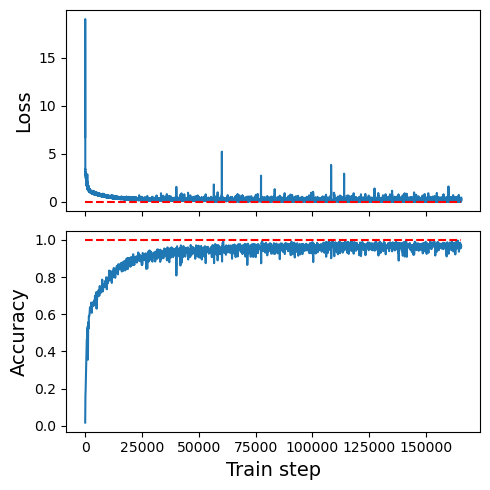

In [25]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5, 5))
axs[0].plot(train_metrics['loss_history'])
axs[0].hlines(y=0, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[0].set_ylabel('Loss', fontsize=14)
axs[1].plot(np.linspace(0, len(train_metrics['loss_history']), len(train_metrics['test_acc_history'])), train_metrics['test_acc_history'])
axs[1].hlines(y=1, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[1].set_xlabel('Train step', fontsize=14)
axs[1].set_ylabel('Accuracy', fontsize=14)
axs[1].set_xlabel('Train step', fontsize=14)
fig.tight_layout()
fig.savefig(fig_outdir + 'train_history.png')

In [38]:
dataset._df.columns

Index(['expnum', 'ra', 'dec', 'exptime', 'filter', 'propid', 'program',
       'object', 'teff', 'fwhm', 'datetime', 'az', 'zd', 'ha', 'airmass',
       'qc_fwhm', 'qc_cloud', 'qc_sky', 'qc_teff', 'night', 'timestamp',
       'sun_ra', 'sun_dec', 'sun_az', 'sun_el', 'moon_ra', 'moon_dec',
       'moon_az', 'moon_el', 'time_fraction_since_start', 'ra_cos', 'ra_sin',
       'az_cos', 'az_sin', 'ha_cos', 'ha_sin', 'sun_ra_cos', 'sun_ra_sin',
       'sun_az_cos', 'sun_az_sin', 'moon_ra_cos', 'moon_ra_sin', 'moon_az_cos',
       'moon_az_sin', 'el', 'bin'],
      dtype='object')

In [40]:
dataset.pointing_feature_names

['ra_cos',
 'ra_sin',
 'dec',
 'az_cos',
 'az_sin',
 'el',
 'airmass',
 'ha_cos',
 'ha_sin',
 'sun_ra_cos',
 'sun_ra_sin',
 'sun_dec',
 'sun_az_cos',
 'sun_az_sin',
 'sun_el',
 'moon_ra_cos',
 'moon_ra_sin',
 'moon_dec',
 'moon_az_cos',
 'moon_az_sin',
 'moon_el',
 'time_fraction_since_start']

# Roll out policy

Actually, instead of getting the trajectory, here we're just giving all of the original schedule's states, and asking what action we should pick

In [26]:
with torch.no_grad():
    q_vals = agent.algorithm.policy_net(dataset.states.to(device))
    eval_actions = torch.argmax(q_vals, dim=1).to('cpu')
    

# Plotting results

## First, visualize healpix's gridding and actual ra, dec of observed fields

In [28]:
# get index of the first observation for each night
first_obs_in_night_indices = []
for key, indices in dataset._df.groupby('night').indices.items():
    first_obs_in_night_indices.append(indices[0])

In [29]:
# Sequence of actions from target (original schedule) and policy
target_sequence = dataset.actions.detach().numpy()
eval_sequence = eval_actions

# # Given the action (bin) chosen in the original schedule and in the policy's schedule
# # obtain the angular separation between the two bins for all actions
# target_radec = np.array([dataset.binid2radec[bin_id] for bin_id in target_sequence])
# eval_radec = np.array([dataset.binid2radec[bin_id] for bin_id in eval_sequence])
# # target_angsep = np.array([angular_separation(pos1=target_radec[i]*units.deg, pos2=target_radec[i+1]*units.deg) for i in range(len(target_radec) - 1)]) / units.deg
# # eval_angsep = np.array([angular_separation(pos1=eval_radec[i]*units.deg, pos2=eval_radec[i+1]*units.deg) for i in range(len(target_radec) - 1)]) / units.deg
# target_eval_angsep = np.array([angular_separation(eval_radec[i]*units.deg, pos2=target_radec[i]*units.deg) for i in range(len(target_radec))]) / units.deg

/tmp/ipykernel_41603/415551787.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  axs[1].plot(eval_sequence - target_sequence, marker='o', alpha=.5)


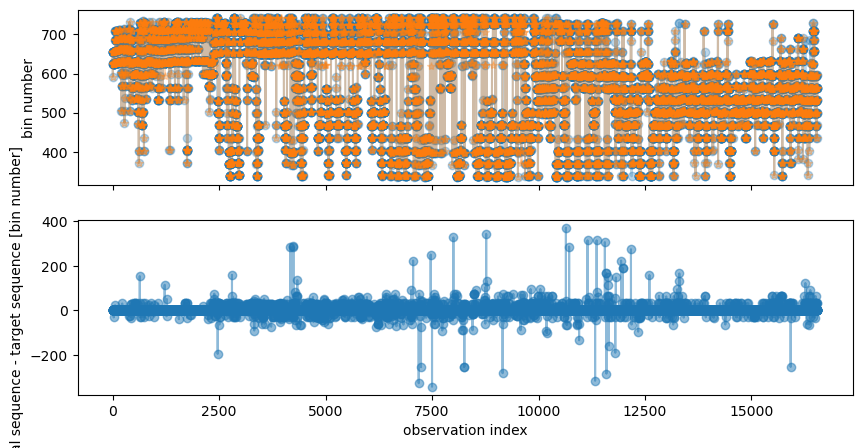

In [30]:
fig, axs = plt.subplots(2, figsize=(10,5), sharex=True)
axs[0].plot(eval_sequence, marker='o', alpha=.3)
axs[0].plot(target_sequence, marker='*', alpha=.3)
axs[0].set_ylabel('bin number')
axs[1].plot(eval_sequence - target_sequence, marker='o', alpha=.5)
axs[1].set_ylabel('Eval sequence - target sequence [bin number]')
axs[1].set_xlabel('observation index')
fig.savefig(fig_outdir + 'train_eval_and_target_bin_sequences.png')

In [53]:
df.columns

Index(['expnum', 'ra', 'dec', 'exptime', 'filter', 'propid', 'program',
       'object', 'teff', 'fwhm', 'datetime', 'az', 'zd', 'ha', 'airmass',
       'qc_fwhm', 'qc_cloud', 'qc_sky', 'qc_teff', 'night'],
      dtype='object')

Text(0.5, 0, 'teff')

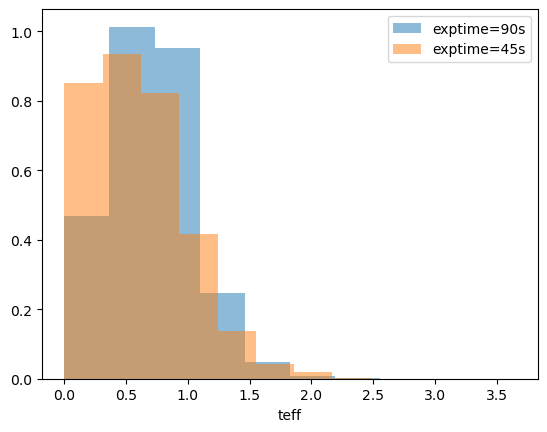

In [66]:
# plt.hist(df['teff'][df['exptime'] == 90], label='exptime=90s', density=True, alpha=.5)
plt.hist(df['qc_teff'][df['exptime'] == 90], label='exptime=90s', density=True, alpha=.5)
# plt.hist(df['teff'][df['exptime'] == 45], label='exptime=45s', density=True, alpha=.5)
plt.hist(df['qc_teff'][df['exptime'] == 45], label='exptime=45s', density=True, alpha=.5)
plt.legend()
plt.xlabel('teff')

In [73]:
df['ra']

0        301.199042
1        300.851117
2        300.460079
3        300.016742
4        302.722079
            ...    
88613     58.930033
88614     58.929917
88615     53.414579
88616     53.389708
88617     53.389546
Name: ra, Length: 88618, dtype: float64

In [80]:
[col for col in df.columns if type(df[col].values) != str and col != 'night' and col]

['expnum',
 'ra',
 'dec',
 'exptime',
 'filter',
 'propid',
 'program',
 'object',
 'teff',
 'fwhm',
 'datetime',
 'az',
 'zd',
 'ha',
 'airmass',
 'qc_fwhm',
 'qc_cloud',
 'qc_sky',
 'qc_teff']

In [82]:
[df[key].values.dtype for key in df.columns]

[dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('<M8[ns]'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('<M8[ns]')]

In [87]:
corr_mat = df[[col for col in df.columns if (df[col].values.dtype == np.float64 or df[col].values.dtype == np.int64) and col != 'qc_fwhm' and col != 'qc_teff']].corr()

In [88]:
corr_mat.style.background_gradient(cmap='coolwarm').format(precision=2)

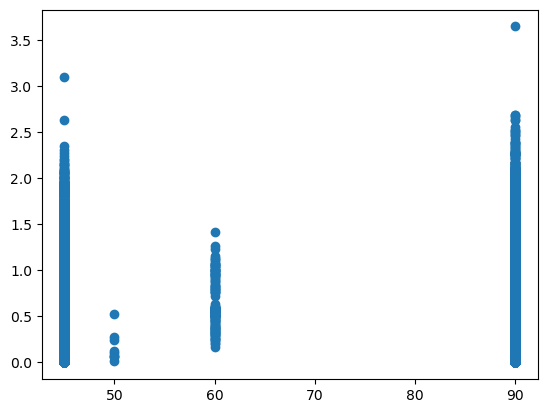

In [92]:
plt.scatter(df['exptime'], df['teff'])

In [54]:
for obj, g in df.groupby('object'):
    print(obj, g[['exptime', 'teff']])

        exptime  teff
31705       90  0.44
31706       90  0.42
31707       90  0.41
31708       90  0.36
31709       90  0.47
31710       90  0.34
31711       90  0.43
31712       90  0.41
31713       90  0.51
31714       90  0.49
31715       90  0.58
31716       90  0.60
31717       90  0.62
31718       90  0.61
31719       90  0.51
31720       90  0.54
31721       90  0.44
31722       90  0.51
Alhambra-8 hex 001 tiling 1        exptime  teff
47509       90  0.63
47510       90  0.59
47783       90  0.60
47784       90  0.81
47785       45  1.00
Alhambra-8 hex 001 tiling 10        exptime  teff
47527       90  0.59
47528       90  0.61
47810       90  0.79
47811       90  0.93
47812       45  1.25
Alhambra-8 hex 001 tiling 2        exptime  teff
47511       90  0.71
47512       90  0.70
47786       90  0.81
47787       90  0.84
47788       45  1.03
Alhambra-8 hex 001 tiling 3        exptime  teff
47513       90  0.71
47514       90  0.59
47789       90  0.79
47790       90  1.02
4779

In [48]:
for obj_name, g in dataset._df.groupby('object'):
    print(obj_name, g[['exptime', 't']])

DES survey hex -102-410 tiling 1 16652    90
16653    90
16862    45
17274    45
18272    90
20686    90
Name: exptime, dtype: int32
DES survey hex -102-410 tiling 3 17872    90
18676    90
Name: exptime, dtype: int32
DES survey hex -102-410 tiling 4 16226    90
16655    45
17452    90
17645    90
Name: exptime, dtype: int32
DES survey hex -103-542 tiling 1 15362    90
16842    45
19635    45
21387    45
Name: exptime, dtype: int32
DES survey hex -103-542 tiling 2 15953    90
18267    90
18684    90
Name: exptime, dtype: int32
DES survey hex -103-542 tiling 3 15356    90
Name: exptime, dtype: int32
DES survey hex -103-542 tiling 4 15650    90
15652    90
19433    45
22134    45
Name: exptime, dtype: int32
DES survey hex -105-653 tiling 2 15093    90
15094    90
15494    90
16001    90
16836    45
18503    90
21848    45
Name: exptime, dtype: int32
DES survey hex -105-653 tiling 4 15095    90
15096    90
15097    45
21844    90
23051    90
Name: exptime, dtype: int32
DES survey hex -107

In [44]:
dataset._df.columns

Index(['expnum', 'ra', 'dec', 'exptime', 'filter', 'propid', 'program',
       'object', 'teff', 'fwhm', 'datetime', 'az', 'zd', 'ha', 'airmass',
       'qc_fwhm', 'qc_cloud', 'qc_sky', 'qc_teff', 'night', 'timestamp',
       'sun_ra', 'sun_dec', 'sun_az', 'sun_el', 'moon_ra', 'moon_dec',
       'moon_az', 'moon_el', 'time_fraction_since_start', 'ra_cos', 'ra_sin',
       'az_cos', 'az_sin', 'ha_cos', 'ha_sin', 'sun_ra_cos', 'sun_ra_sin',
       'sun_az_cos', 'sun_az_sin', 'moon_ra_cos', 'moon_ra_sin', 'moon_az_cos',
       'moon_az_sin', 'el', 'bin'],
      dtype='object')

In [31]:
test_dataset = OfflineDECamDataset(
    df, 
    binning_method=binning_method,
    nside=nside,
    bin_space=bin_space,
    specific_years=[2015],
    specific_months=[12],
    include_default_features=include_default_features,
    include_bin_features=include_bin_features,
    do_z_score_norm=do_z_score_norm,
    do_cyclical_norm=do_cyclical_norm,
)

In [32]:
with torch.no_grad():
    test_q_vals = agent.algorithm.policy_net(test_dataset.states.to(device))
    test_eval_actions = torch.argmax(test_q_vals, dim=1).to('cpu')

test_target_sequence = test_dataset.actions.detach().numpy()
test_eval_sequence = test_eval_actions.detach().numpy()

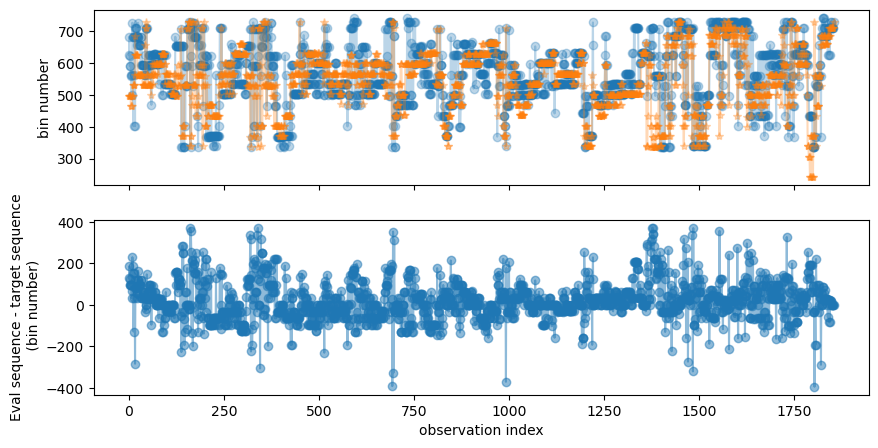

In [33]:
fig, axs = plt.subplots(2, figsize=(10,5), sharex=True)
axs[0].plot(test_eval_sequence, marker='o', alpha=.3)
axs[0].plot(test_target_sequence, marker='*', alpha=.3)
axs[0].set_ylabel('bin number')
axs[1].plot(test_eval_sequence - test_target_sequence, marker='o', alpha=.5)
axs[1].set_ylabel('Eval sequence - target sequence\n (bin number)')
axs[1].set_xlabel('observation index')
fig.savefig(fig_outdir + 'test_eval_and_target_bin_sequences.png')

In [31]:
import random

In [32]:
test_eval_bin_radecs = np.array([test_dataset.bin2radec[bin_id] for bin_id in test_eval_sequence])
test_target_bin_radecs = np.array([test_dataset.bin2radec[bin_id] for bin_id in test_target_sequence])

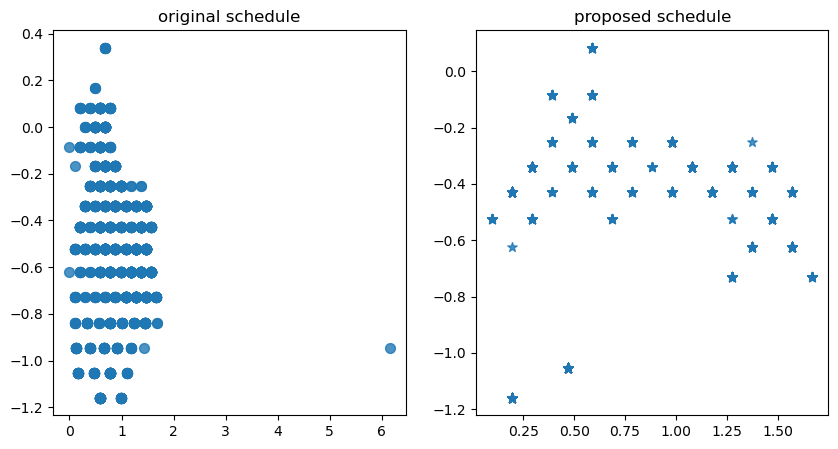

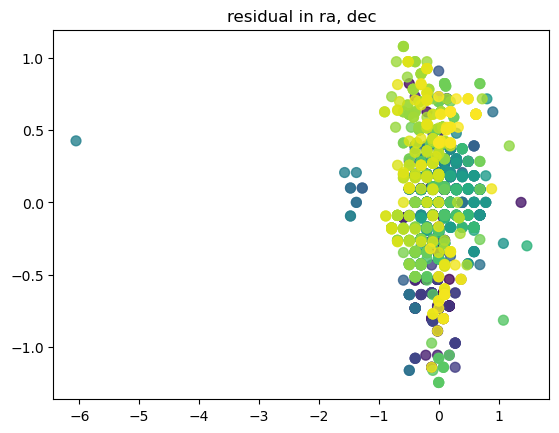

In [33]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
axs[0].scatter(test_target_bin_radecs[:, 0], test_target_bin_radecs[:, 1], s=50, alpha=.8)
axs[1].scatter(test_eval_bin_radecs[:, 0], test_eval_bin_radecs[:, 1], alpha=.8, s=50, marker='*')
axs[0].set_title('original schedule')
axs[1].set_title('proposed schedule')
plt.show();

plt.scatter(test_eval_bin_radecs[:, 0] - test_target_bin_radecs[:, 0], test_eval_bin_radecs[:, 1] - test_target_bin_radecs[:, 1], s=50, c=np.arange(len(test_dataset)), alpha=.8)
plt.title('residual in ra, dec')
plt.show();
